In [1830]:
import pandas as pd
import numpy as np
import pickle
import random

from scipy.stats import mode

from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN, KMeans
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedKFold

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

In [1831]:
import warnings
warnings.simplefilter('ignore')

**Загружаем функции**

In [1832]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [1833]:
def balance_df_by_target(df, target_name):

    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1

    for i in range(disbalance_coeff):
        sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
        df = df.append(sample, ignore_index=True)

    return df.sample(frac=1) 

In [1834]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [1835]:
def emissions_del(signs):
    max_value = train_df[signs].agg('std') * 3 + train_df[signs].agg('mean')
    print(max_value)
    if train_df[signs].agg('median') == 0:
        my_mm = round(train_df[signs].agg('mean'))
        train_df.loc[train_df[signs] > max_value, [signs]] = my_mm
        test_df.loc[test_df[signs] > max_value, [signs]] = my_mm
    else:
        my_mm = round(train_df[signs].agg('median'))
        train_df.loc[train_df[signs] > max_value, [signs]] = my_mm
        test_df.loc[test_df[signs] > max_value, [signs]] = my_mm
    train_df[signs].fillna(my_mm, inplace = True)
    test_df[signs].fillna(my_mm, inplace = True)  

**Загрузка и проверка датасета**

In [1836]:
train_df = pd.read_csv('course_project_train.csv')
test_df = pd.read_csv('course_project_test.csv')

In [1837]:
train_df.head(2)

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1


**Снижение размерности данных**

In [1838]:
train_df = reduce_mem_usage(train_df)
test_df = reduce_mem_usage(test_df)
test_df.head(2)

Memory usage of dataframe is 0.97 MB
Memory usage after optimization is: 0.38 MB
Decreased by 60.9%
Memory usage of dataframe is 0.31 MB
Memory usage after optimization is: 0.13 MB
Decreased by 58.9%


,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
0,Rent,NaN,4 years,0.0,9.0,12.500000,220968.0,0.0,70.0,0.0,debt consolidation,Short Term,162470.0,105906.0,6813.0,NaN
1,Rent,231838.0,1 year,0.0,6.0,32.700001,55946.0,0.0,8.0,0.0,educational expenses,Short Term,78298.0,46037.0,2318.0,699.0


**Описание датасета**

* **Home Ownership** - домовладение
            Home Mortgage    Ипотека на дом
            Rent             Арендует
            Own Home         Владеет домом
            Have Mortgage    Есть ипотека

* **Annual Income** - годовой доход
* **Years in current job** - количество лет на текущем месте работы
* **Tax Liens** - налоговые обременения
* **Number of Open Accounts** - количество открытых счетов
* **Years of Credit History** - количество лет кредитной истории
* **Maximum Open Credit** - наибольший открытый кредит
* **Number of Credit Problems** - количество проблем с кредитом
* **Months since last delinquent** - количество месяцев с последней просрочки платежа
* **Bankruptcies** - банкротства
* **Purpose** - цель кредита
            debt consolidation       консолидация долга
            other                    другие
            home improvements        благоустройство дома
            business loan            бизнес-кредит
            buy a car                купить машину
            medical bills            медицинские счета
            major purchase           крупная покупка
            take a trip              отправиться в путешествие
            buy house                купить дом
            small business           малый бизнес
            wedding                  свадьба
            moving                   переезд
            educational expenses     расходы на образование
            vacation                 отпуск
            renewable energy         возобновляемая энергия
            
* **Term** - срок кредита
* **Current Loan Amount** - текущая сумма кредита
* **Current Credit Balance** - текущий кредитный баланс
* **Monthly Debt** - ежемесячный долг
* **Credit Default** - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)


In [1839]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype   
---  ------                        --------------  -----   
 0   Home Ownership                7500 non-null   category
 1   Annual Income                 5943 non-null   float32 
 2   Years in current job          7129 non-null   category
 3   Tax Liens                     7500 non-null   float32 
 4   Number of Open Accounts       7500 non-null   float32 
 5   Years of Credit History       7500 non-null   float32 
 6   Maximum Open Credit           7500 non-null   float32 
 7   Number of Credit Problems     7500 non-null   float32 
 8   Months since last delinquent  3419 non-null   float32 
 9   Bankruptcies                  7486 non-null   float32 
 10  Purpose                       7500 non-null   category
 11  Term                          7500 non-null   category
 12  Current Loan Amount           7500 non-null   fl

In [1840]:
TARGET_NAME = 'Credit Default'

In [1841]:
FUTURE_NAMES = test_df.columns.values
FUTURE_NAMES

array(['Home Ownership', 'Annual Income', 'Years in current job',
       'Tax Liens', 'Number of Open Accounts', 'Years of Credit History',
       'Maximum Open Credit', 'Number of Credit Problems',
       'Months since last delinquent', 'Bankruptcies', 'Purpose', 'Term',
       'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt',
       'Credit Score'], dtype=object)

****

**EDA**

In [1842]:
train_df.isnull().sum()

Home Ownership                     0
Annual Income                   1557
Years in current job             371
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    4081
Bankruptcies                      14
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                    1557
Credit Default                     0
dtype: int64

In [1843]:
test_df.isnull().sum()

Home Ownership                     0
Annual Income                    513
Years in current job              86
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    1358
Bankruptcies                       3
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                     513
dtype: int64

In [1844]:
train_df.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,5.943000e+03,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.0000,3419.000000,7486.000000,7500.0,7.500000e+03,7500.000000,5943.000000,7500.000000
mean,1.366390e+06,0.030133,11.130934,18.317446,9.451526e+05,0.1700,34.692600,0.117152,11873135.0,2.898332e+05,18314.453125,1151.087524,0.281733
std,8.453384e+05,0.271613,4.908937,7.041938,1.602614e+07,0.4986,21.688801,0.347197,31926302.0,3.178713e+05,11926.758789,1604.447510,0.449874
min,1.645970e+05,0.000000,2.000000,4.000000,0.000000e+00,0.0000,0.000000,0.000000,11242.0,0.000000e+00,0.000000,585.000000,0.000000
25%,8.443410e+05,0.000000,8.000000,13.500000,2.792295e+05,0.0000,16.000000,0.000000,180169.0,1.142565e+05,10067.500000,711.000000,0.000000
50%,1.168386e+06,0.000000,10.000000,17.000000,4.781590e+05,0.0000,32.000000,0.000000,309573.0,2.093230e+05,16076.500000,731.000000,0.000000
75%,1.640137e+06,0.000000,14.000000,21.799999,7.935015e+05,0.0000,50.000000,0.000000,519882.0,3.604062e+05,23818.000000,743.000000,1.000000
max,1.014934e+07,7.000000,43.000000,57.700001,1.304726e+09,7.0000,118.000000,4.000000,100000000.0,6.506797e+06,136679.000000,7510.000000,1.000000


In [1845]:
for cat_colname in train_df.select_dtypes(include='category').columns:
    print(str(cat_colname) + '\n\n' + str(train_df[cat_colname].value_counts()) + '\n' + '*' * 100 + '\n')

Home Ownership

Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: Home Ownership, dtype: int64
****************************************************************************************************

Years in current job

10+ years    2332
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
8 years       339
9 years       259
Name: Years in current job, dtype: int64
****************************************************************************************************

Purpose

debt consolidation      5944
other                    665
home improvements        412
business loan            129
buy a car                 96
medical bills             71
major purchase            40
take a trip               37
buy house                 34
small business            26
wedding                   15
moving                    11
educational expenses      10
vacation  

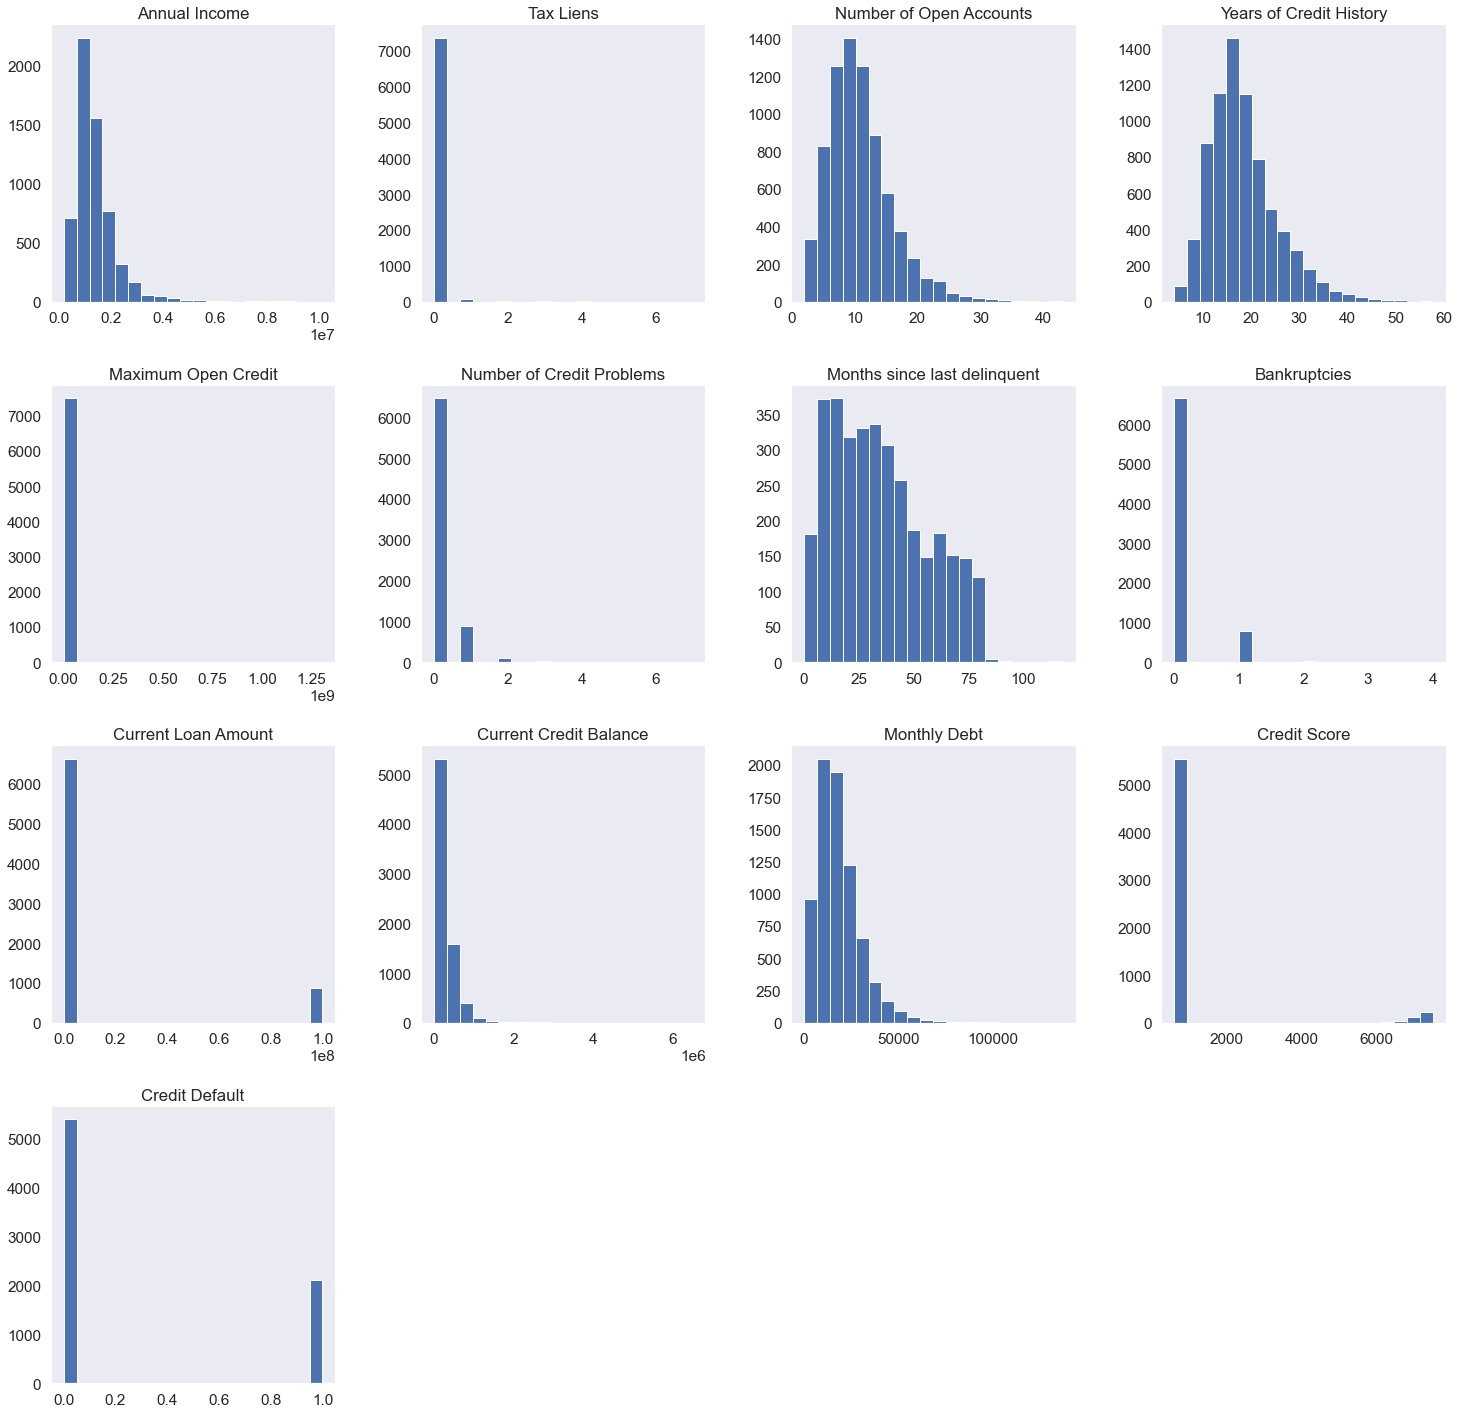

In [1846]:
train_df.hist(figsize=(25,25), bins=20, grid=False);

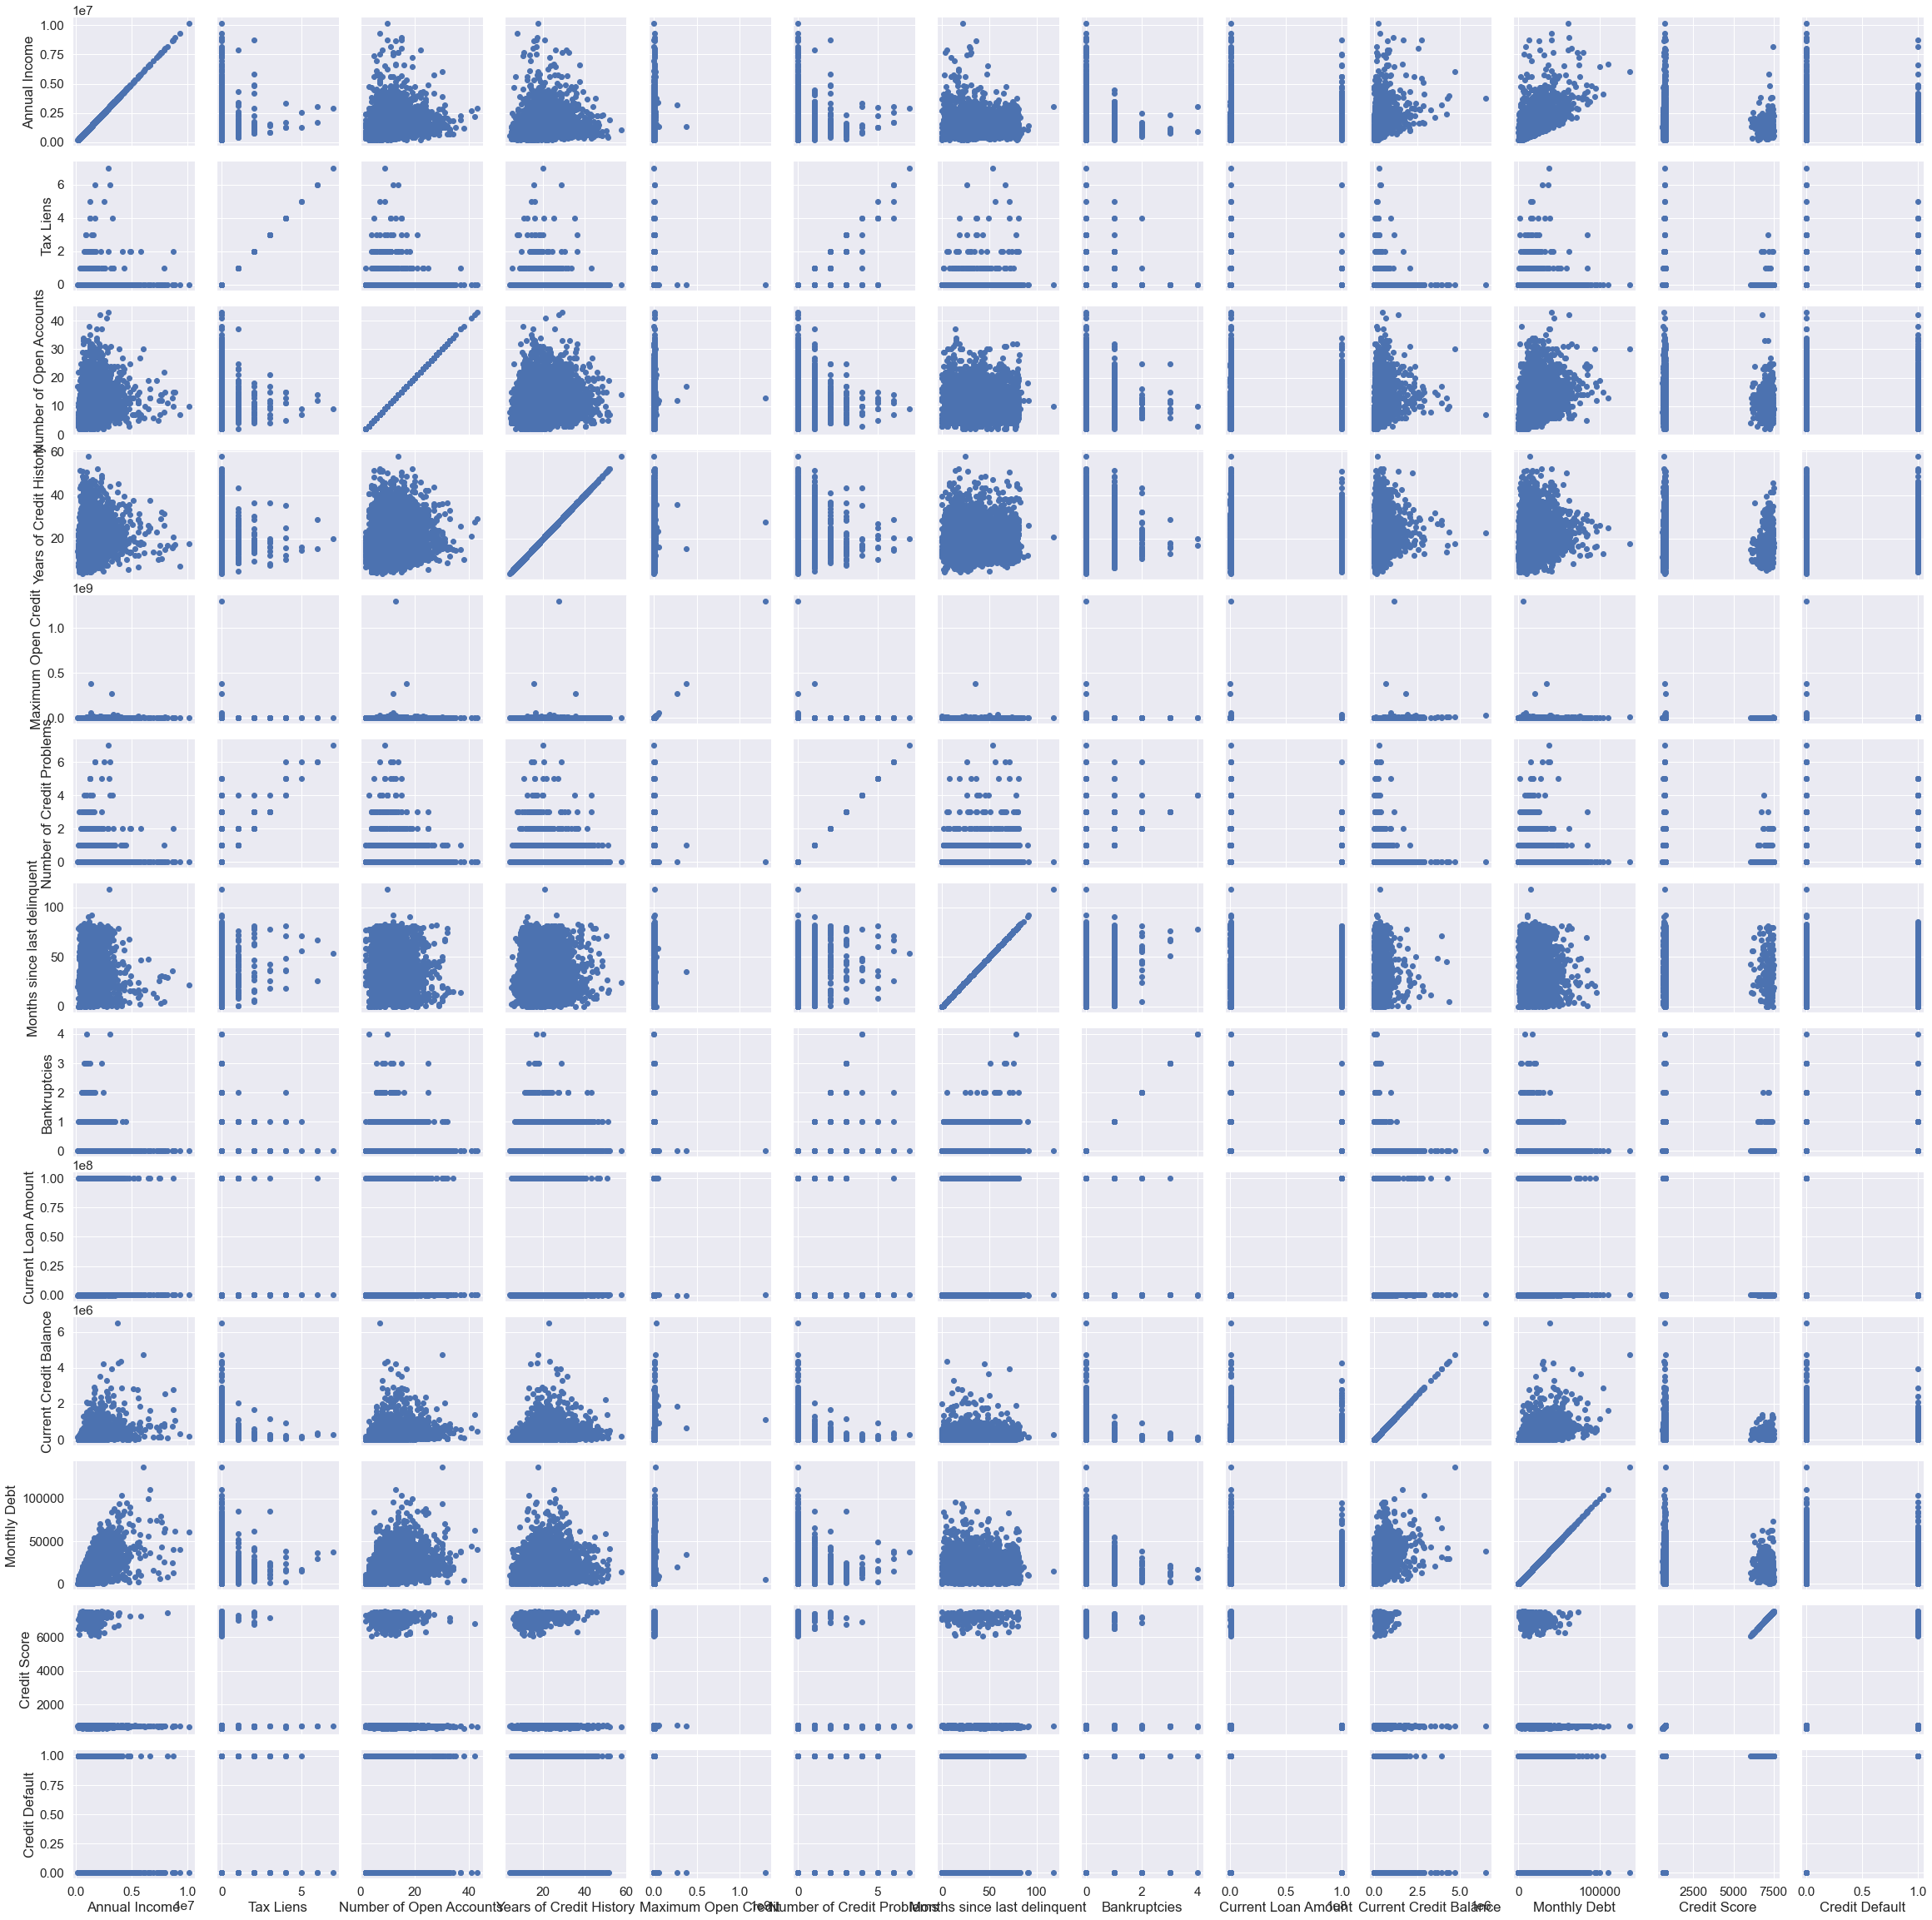

In [1847]:
pair_greed_plot = sns.PairGrid(train_df)
pair_greed_plot.map(plt.scatter)

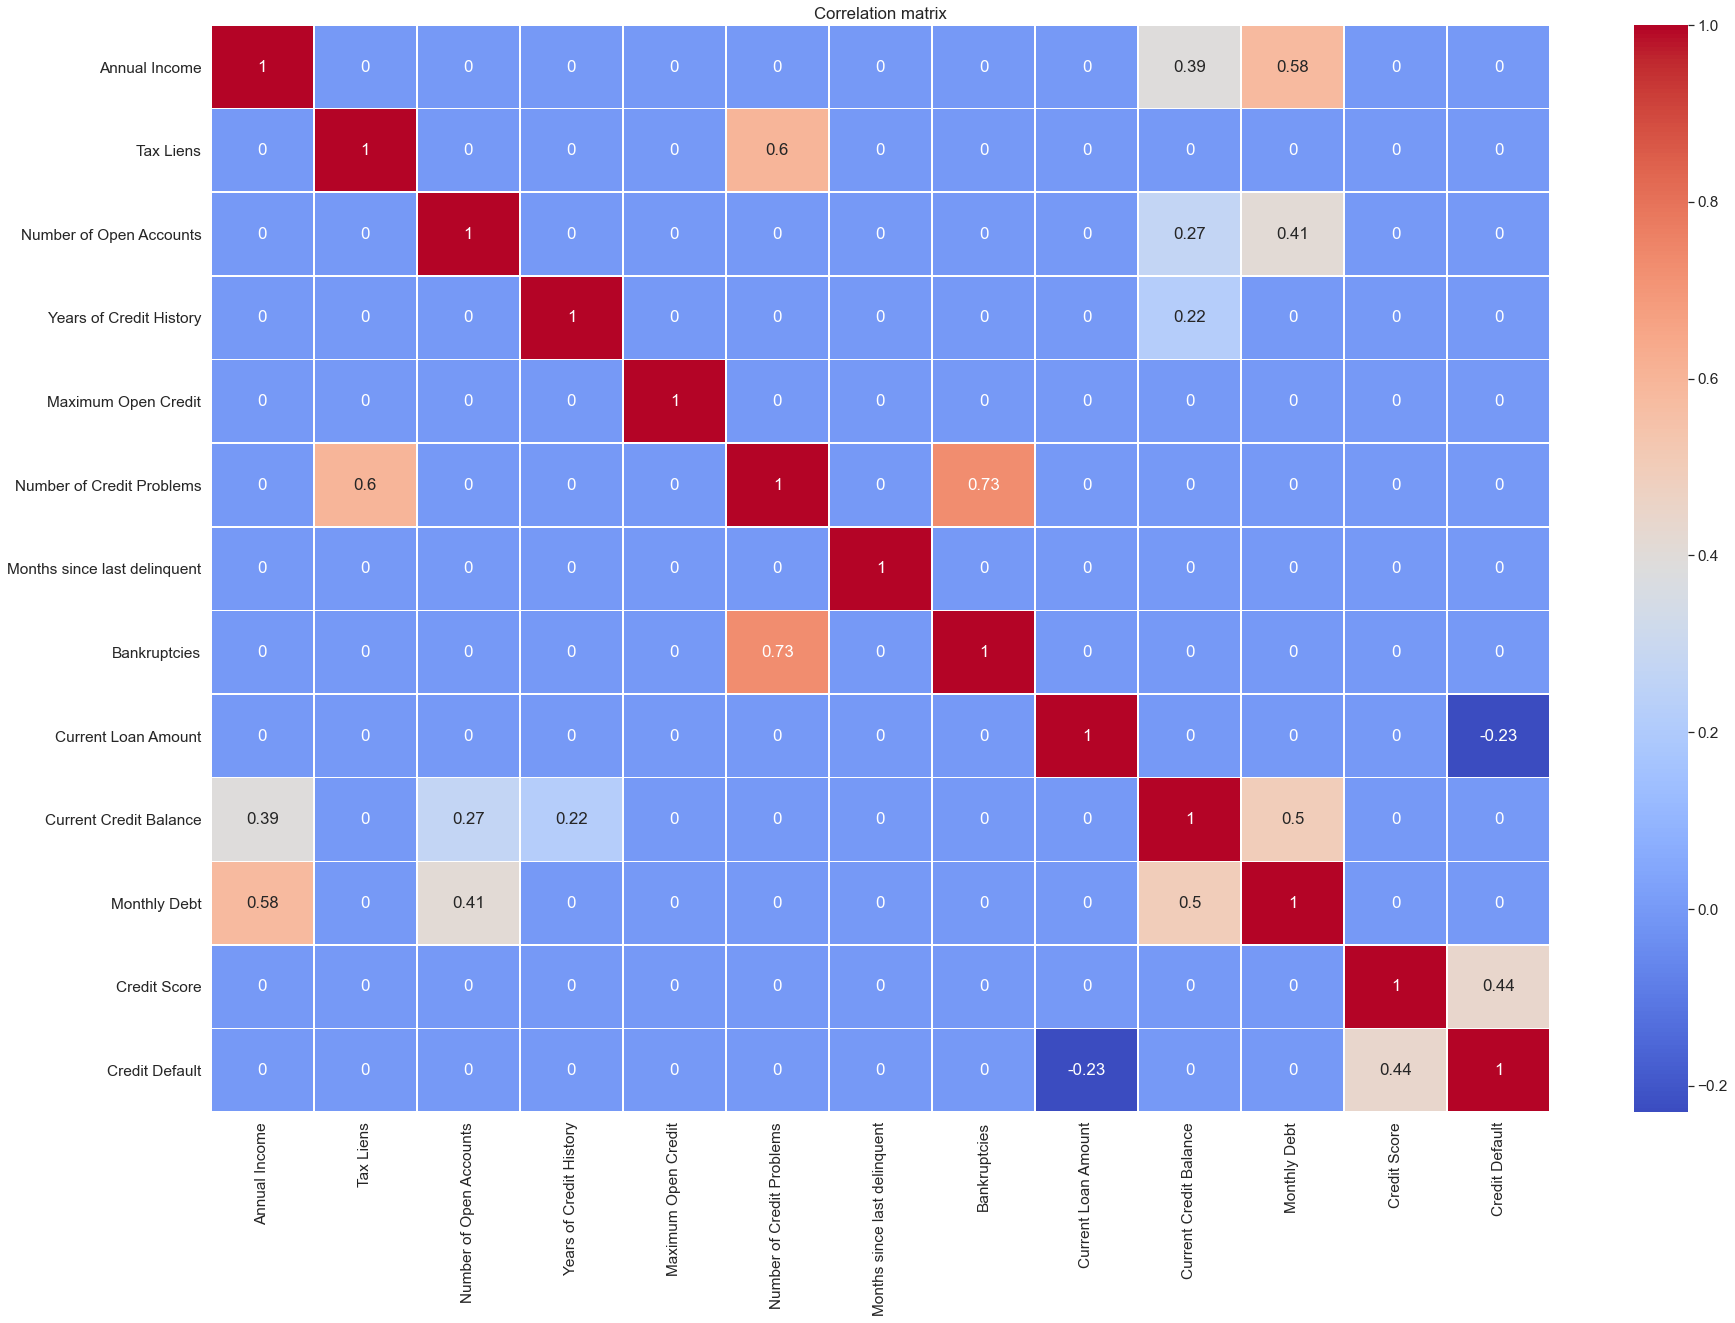

In [1848]:
plt.figure(figsize = (30,20))

sns.set(font_scale=1.4)

corr_matrix = train_df.corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.2] = 0

sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='coolwarm')

plt.title('Correlation matrix')
plt.show()

In [1849]:
scaler = RobustScaler()

colnames = train_df.select_dtypes(include=['number']).columns
train_df_scaled = pd.DataFrame(scaler.fit_transform(train_df.select_dtypes(include=['number'])), columns=colnames)
train_df_scaled.head(2)

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,-0.862406,0.0,0.166667,1.120482,0.404068,1.0,NaN,1.0,293.454834,-0.657880,-0.593615,0.5625,0.0
1,-0.179567,0.0,0.833333,-0.204819,1.368091,0.0,NaN,0.0,-0.131302,0.754212,0.167012,0.1875,1.0


In [1850]:
train_df['Maximum Open Credit'].max()

1304726144.0

In [1851]:
train_df_scaled.loc[train_df_scaled['Maximum Open Credit'] > 20] = train_df_scaled['Maximum Open Credit'].median()
train_df_scaled.loc[train_df_scaled['Current Loan Amount'] > 200] = train_df_scaled['Current Loan Amount'].median()
train_df_scaled.loc[train_df_scaled['Credit Score'] > 100] = train_df_scaled['Credit Score'].median()

данные признаки содержат серьезные выбросы

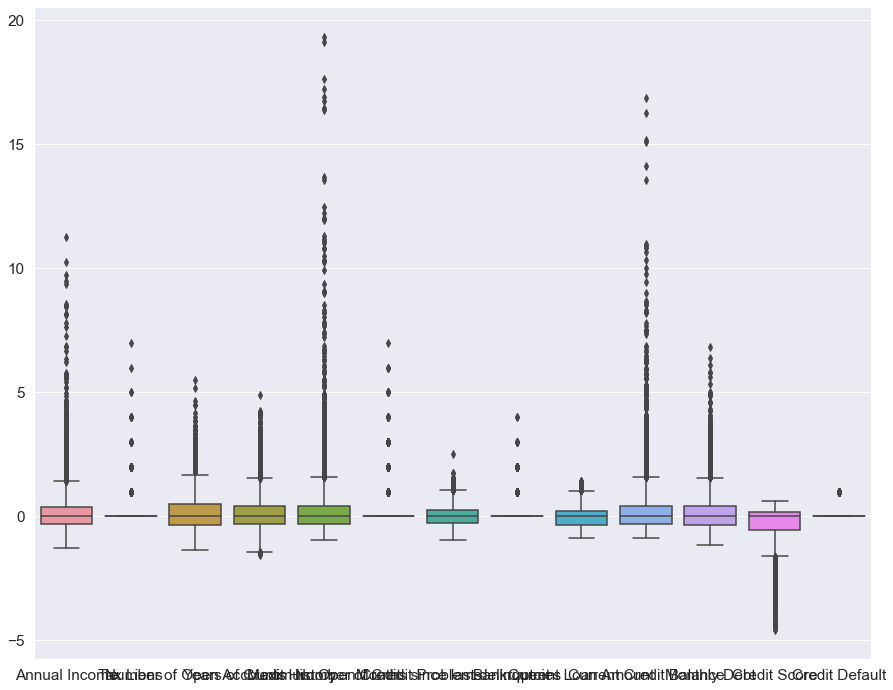

In [1852]:
f, ax = plt.subplots(figsize=(15, 12))
fig = sns.boxplot(data=train_df_scaled)
#fig.axis(ymin=0, ymax=800000);
#plt.xticks(rotation=90);

**Подробное иследование каждого признака + работа с выбросами**

**Credit Default(TARGET_NAME)**

In [1853]:
train_df[TARGET_NAME].value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

я подозреваю что сама цель данной модели это предсказание максимальной суммы просрочки кредита в следующем временном отрезке.

In [1854]:
train_df.groupby(TARGET_NAME)['Monthly Debt'].sum()

Credit Default
0    97916400.0
1    39442000.0
Name: Monthly Debt, dtype: float32

In [1855]:
39442000.0 / 97916400.0 * 100

40.28130119162878

*выборка не сбалансированная*

**Home Ownership**

In [1856]:
future_name = 'Home Ownership'

In [1857]:
train_df[future_name].value_counts()

Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: Home Ownership, dtype: int64

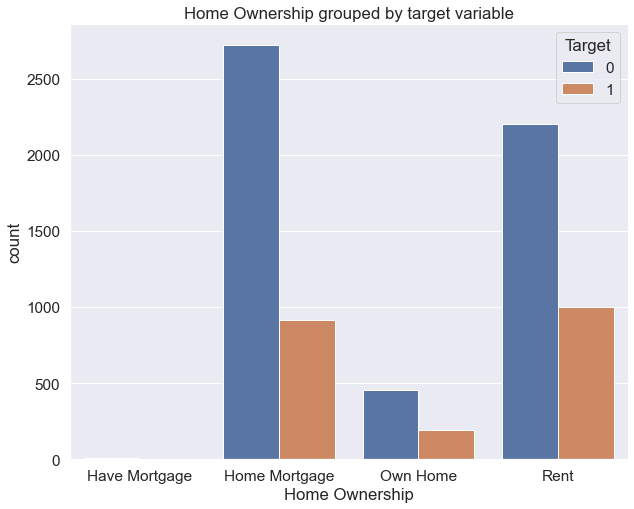

In [1858]:
plt.figure(figsize=(10, 8))

sns.countplot(x=future_name, hue=TARGET_NAME, data=train_df)
plt.title(f'{future_name} grouped by target variable')
plt.legend(title='Target', loc='upper right')

plt.show()

In [1859]:
train_df[[TARGET_NAME, 'Home Ownership']].groupby('Home Ownership').agg(['sum', 'mean', 'count'])

Credit Default                
                          sum      mean count
Home Ownership                               
Have Mortgage             2.0  0.166667    12
Home Mortgage           916.0  0.251856  3637
Own Home                192.0  0.296754   647
Rent                   1003.0  0.313046  3204

In [1860]:
pd.crosstab(train_df['Home Ownership'], train_df[TARGET_NAME], margins=True).style.background_gradient(cmap='autumn_r')

Credit Default,0,1,All
Home Ownership,,,
Have Mortgage,10,2,12
Home Mortgage,2721,916,3637
Own Home,455,192,647
Rent,2201,1003,3204
All,5387,2113,7500


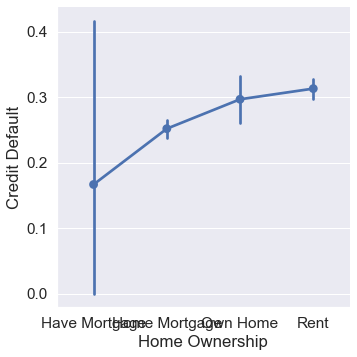

In [1861]:
sns.catplot('Home Ownership', TARGET_NAME, kind='point', data=train_df)

**Annual Income**

In [1862]:
future_name = 'Annual Income'

In [1863]:
train_df[future_name].describe()

count    5.943000e+03
mean     1.366390e+06
std      8.453384e+05
min      1.645970e+05
25%      8.443410e+05
50%      1.168386e+06
75%      1.640137e+06
max      1.014934e+07
Name: Annual Income, dtype: float64

median - 1168386.0
mean - 1366389.75
mode - 969475.0


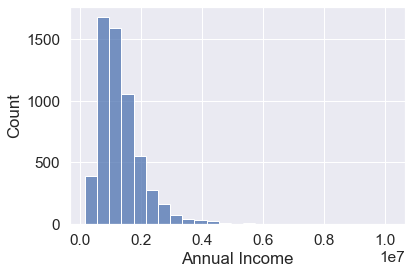

In [1864]:
print(f'median - {np.quantile(train_df[future_name].dropna(), q=0.5)}\nmean - {np.mean(train_df[future_name])}\nmode - {mode(train_df[future_name])[0][0]}')
sns.histplot(train_df[future_name], bins=25);

In [1865]:
train_df[[TARGET_NAME, future_name]].groupby(TARGET_NAME).agg('mean')

,Annual Income
Credit Default,
0,1418046.625
1,1224243.000


In [1866]:
train_df.loc[(train_df[future_name] > train_df[future_name].dropna().mean() + 3*train_df[future_name].dropna().std()) & (train_df[TARGET_NAME] != 0)] 

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
1202,Home Mortgage,4181805.0,2 years,2.0,15.0,18.799999,886842.0,2.0,NaN,0.0,debt consolidation,Short Term,645612.0,618849.0,20560.0,706.0,1
2535,Home Mortgage,4120226.0,10+ years,0.0,15.0,13.000000,3931620.0,0.0,NaN,0.0,debt consolidation,Long Term,542146.0,2889577.0,104036.0,656.0,1
4271,Home Mortgage,5798040.0,< 1 year,2.0,7.0,18.500000,622204.0,2.0,47.0,0.0,debt consolidation,Long Term,716100.0,438482.0,10002.0,7220.0,1
4439,Home Mortgage,4831700.0,2 years,0.0,15.0,28.000000,722788.0,0.0,23.0,0.0,business loan,Short Term,537086.0,493753.0,89789.0,690.0,1
4491,Home Mortgage,8200229.0,2 years,0.0,11.0,16.700001,333630.0,0.0,29.0,0.0,debt consolidation,Short Term,117040.0,116128.0,8610.0,7440.0,1
5396,Home Mortgage,8710740.0,2 years,2.0,15.0,16.500000,3162896.0,2.0,NaN,0.0,debt consolidation,Short Term,560340.0,1663545.0,40215.0,735.0,1
5677,Home Mortgage,4051845.0,5 years,0.0,6.0,23.400000,625834.0,1.0,NaN,0.0,other,Short Term,335126.0,509143.0,65167.0,689.0,1
6727,Home Mortgage,4867800.0,9 years,0.0,25.0,30.900000,1838166.0,0.0,NaN,0.0,debt consolidation,Long Term,631268.0,771533.0,83158.0,734.0,1
6997,Home Mortgage,4824100.0,10+ years,0.0,13.0,13.500000,616902.0,0.0,NaN,0.0,home improvements,Short Term,782012.0,442738.0,32603.0,7240.0,1
7036,Rent,6620208.0,3 years,0.0,16.0,24.799999,1233342.0,0.0,NaN,0.0,wedding,Long Term,473462.0,724318.0,74588.0,733.0,1


эти данные будут путать модель. так как при высоком доходе просрочить кредит за гранью добра и зла

In [1867]:
cat_list = [ _ for _ in range(10)]
train_df_EDA[future_name] = pd.qcut(train_df[future_name], q=10, labels=cat_list)
train_df_EDA[future_name]

0         0
1         3
2         1
3         2
4         2
       ... 
7495      0
7496      7
7497      8
7498    NaN
7499    NaN
Name: Annual Income, Length: 7500, dtype: category
Categories (10, int64): [0 < 1 < 2 < 3 ... 6 < 7 < 8 < 9]

In [1868]:
train_df_EDA = pd.DataFrame()
train_df_EDA[future_name] = pd.qcut(train_df[future_name], q=10, labels=cat_list)
train_df_EDA['Monthly Debt'] = pd.qcut(train_df['Monthly Debt'], q=10, labels=cat_list)
train_df_EDA['Credit Default'] = train_df['Credit Default']

In [1869]:
plt_EDA = train_df_EDA.pivot_table(values='Credit Default', index=[future_name, 'Monthly Debt'], aggfunc=['mean', 'sum', 'count'])
plt_EDA

mean            sum          count
                           Credit Default Credit Default Credit Default
Annual Income Monthly Debt                                             
0             0                  0.281106             61            217
              1                  0.321918             47            146
              2                  0.359649             41            114
              3                  0.376812             26             69
              4                  0.314286             11             35
...                                   ...            ...            ...
9             5                  0.214286              6             28
              6                  0.102564              4             39
              7                  0.155172              9             58
              8                  0.149533             16            107
              9                  0.199248             53            266

[100 rows x 3 columns]

<AxesSubplot:xlabel='Annual Income', ylabel='Monthly Debt'>

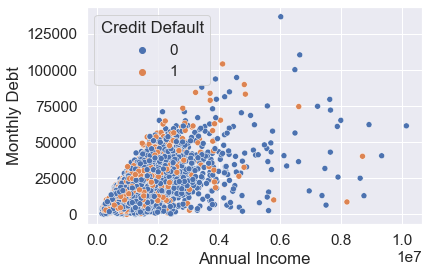

In [1870]:
sns.scatterplot(data=train_df, x="Annual Income", y="Monthly Debt", hue="Credit Default")

In [1871]:
scaler = StandardScaler()

train_df_log = pd.DataFrame()

df_for_scale = pd.DataFrame(scaler.fit_transform(train_df[["Annual Income", "Monthly Debt"]].dropna()), columns=["Annual Income", "Monthly Debt"])
train_df_log[future_name] = np.log(df_for_scale['Annual Income']+ 1)
train_df_log[future_name]

0            NaN
1      -0.516357
2      -1.300322
3      -1.090876
4      -1.197840
          ...   
5938    1.006241
5939   -0.137763
5940         NaN
5941    0.180880
5942    0.473957
Name: Annual Income, Length: 5943, dtype: float32

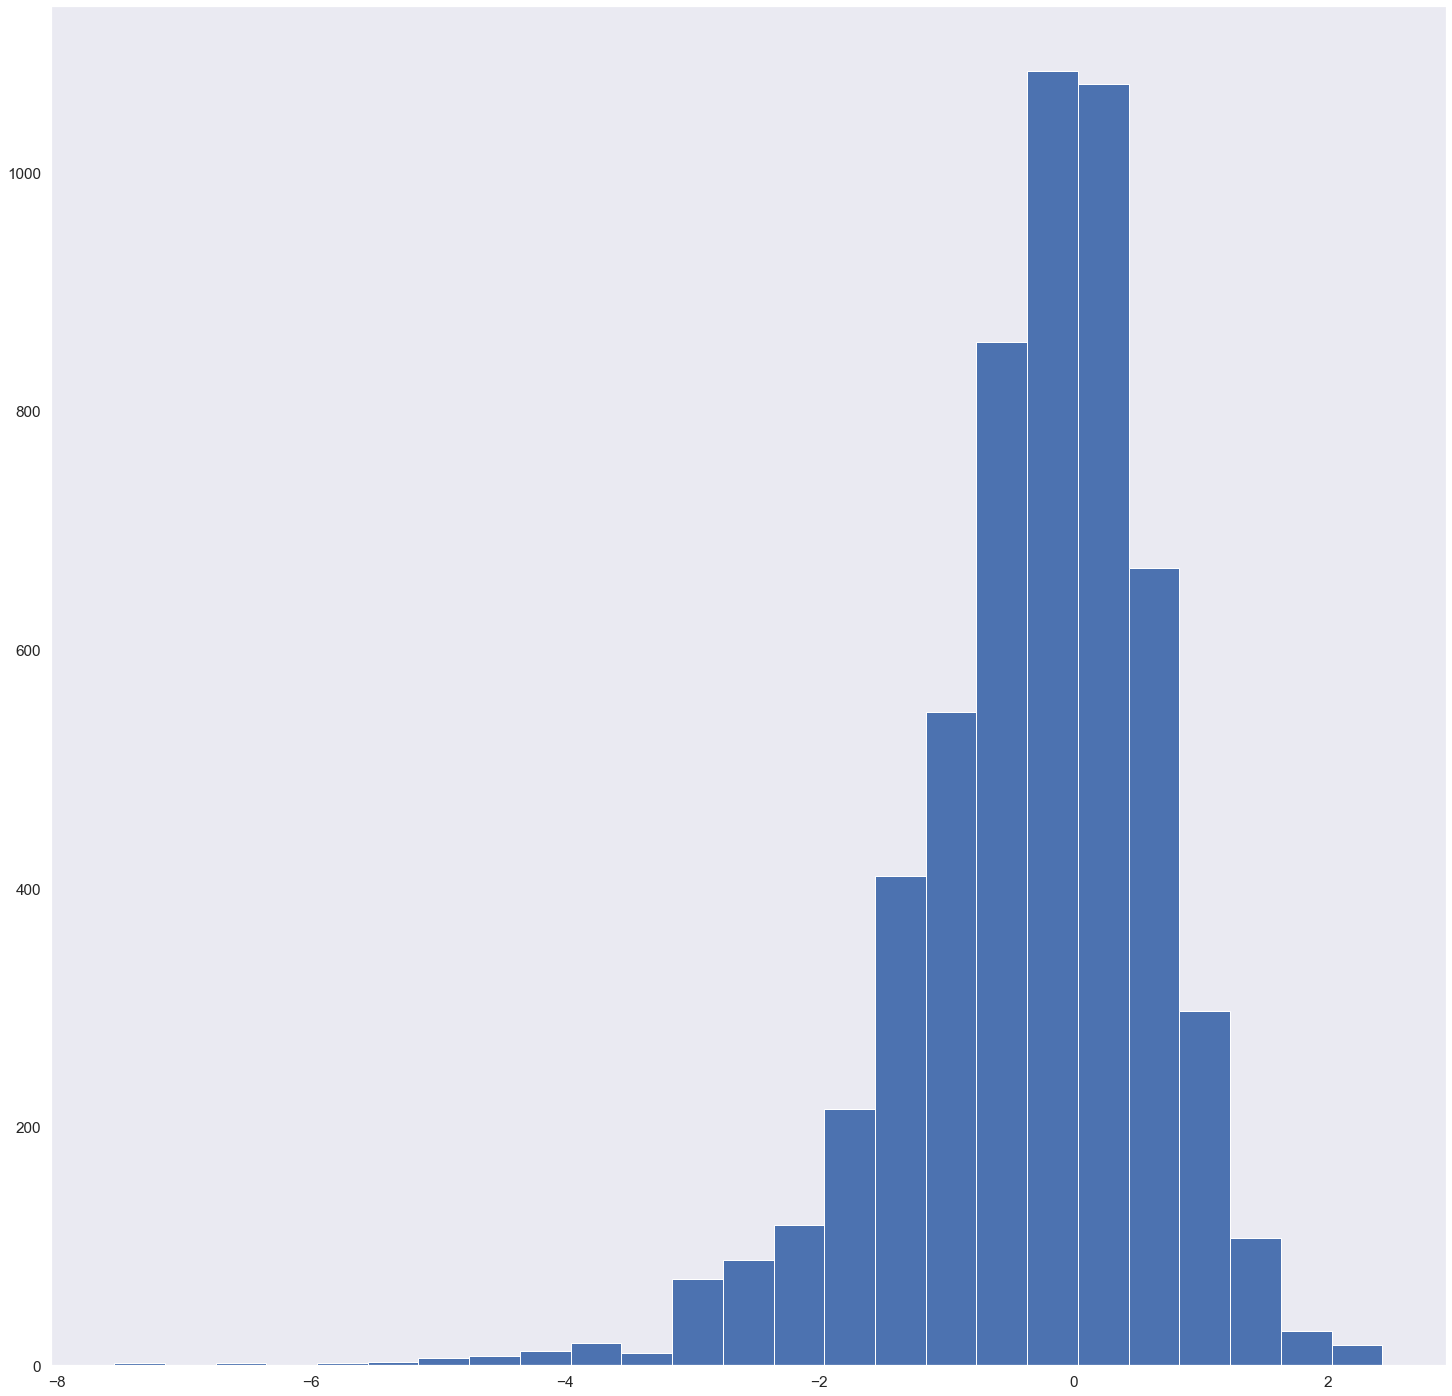

In [1872]:
train_df_log[future_name].hist(figsize=(25,25), bins=25, grid=False);

определение прожиточного минимума по дванным(денег которых ему хватает за вычетом кредита)

In [1873]:
_ = train_df[[TARGET_NAME, future_name]].groupby(TARGET_NAME).agg(['mean', 'min']) / 12
_

Annual Income              
                         mean           min
Credit Default                             
0               118170.554688  13716.416992
1               102020.250000  16169.000000

In [1874]:
_ = (train_df.loc[train_df[TARGET_NAME]==0, future_name] / 12 - train_df['Monthly Debt']).min()
_

10294.9169921875

In [1875]:
train_df.loc[(train_df[future_name] / 12 < (train_df['Monthly Debt'] + _)) & (train_df[TARGET_NAME] == 1)].value_counts()

Series([], dtype: int64)

очень странно что 3514 дали кредит на путеществие при таком малом соотрношении дохода к размеру кредита

**Years in current job**

In [1876]:
future_name = 'Years in current job'

In [1877]:
train_df[future_name].value_counts()

10+ years    2332
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
8 years       339
9 years       259
Name: Years in current job, dtype: int64

<AxesSubplot:>

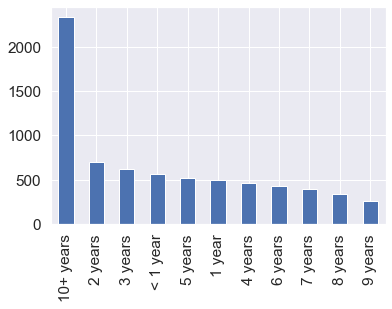

In [1878]:
train_df[future_name].value_counts().plot(kind="bar")

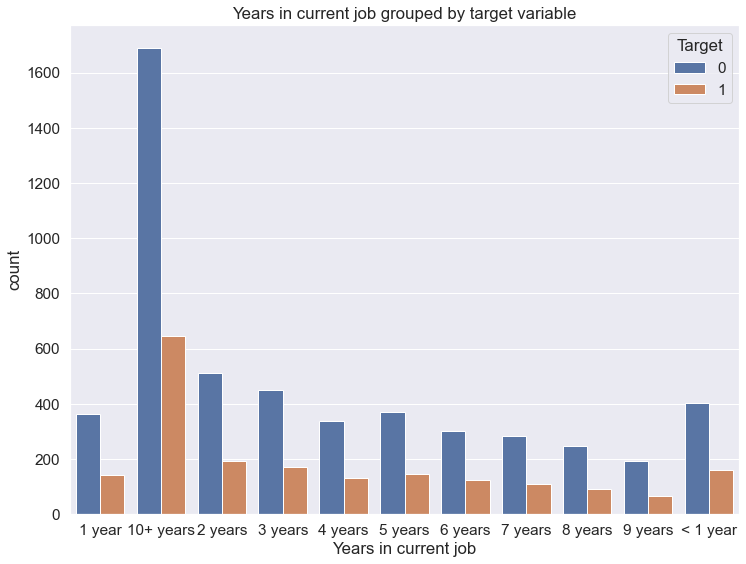

In [1879]:
plt.figure(figsize=(12, 9))

sns.countplot(x=future_name, hue=TARGET_NAME, data=train_df)
plt.title(f'{future_name} grouped by target variable')
plt.legend(title='Target', loc='upper right')

plt.show()

In [1880]:
train_df[[TARGET_NAME, future_name]].groupby(future_name).agg(['sum', 'mean', 'count'])

Credit Default                
                                sum      mean count
Years in current job                               
1 year                        142.0  0.281746   504
10+ years                     644.0  0.276158  2332
2 years                       193.0  0.273759   705
3 years                       170.0  0.274194   620
4 years                       131.0  0.279318   469
5 years                       145.0  0.281008   516
6 years                       124.0  0.291080   426
7 years                       111.0  0.280303   396
8 years                        92.0  0.271386   339
9 years                        65.0  0.250965   259
< 1 year                      159.0  0.282416   563

In [1881]:
pd.crosstab(train_df[TARGET_NAME], train_df[future_name], margins=True).style.background_gradient(cmap='autumn_r')

Years in current job,1 year,10+ years,2 years,3 years,4 years,5 years,6 years,7 years,8 years,9 years,< 1 year,All
Credit Default,,,,,,,,,,,,
0,362,1688,512,450,338,371,302,285,247,194,404,5153
1,142,644,193,170,131,145,124,111,92,65,159,1976
All,504,2332,705,620,469,516,426,396,339,259,563,7129


**Tax Liens Налоговые залоги**

In [1882]:
future_name = 'Tax Liens'

In [1883]:
train_df[future_name].describe()

count    7500.000000
mean        0.030133
std         0.271613
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         7.000000
Name: Tax Liens, dtype: float64

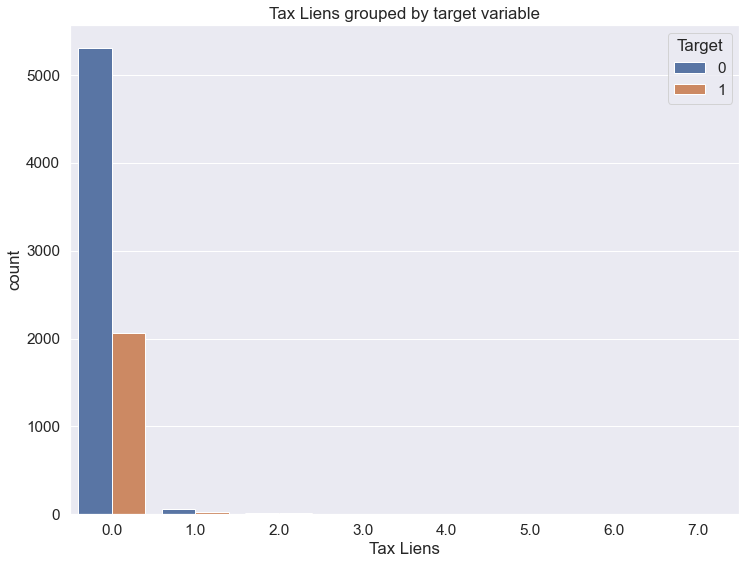

In [1884]:
plt.figure(figsize=(12, 9))

sns.countplot(x=future_name, hue=TARGET_NAME, data=train_df)
plt.title(f'{future_name} grouped by target variable')
plt.legend(title='Target', loc='upper right')

plt.show()

In [1885]:
train_df[future_name].value_counts()

0.0    7366
1.0      83
2.0      30
3.0      10
4.0       6
6.0       2
5.0       2
7.0       1
Name: Tax Liens, dtype: int64

In [1886]:
pd.crosstab(train_df[TARGET_NAME], train_df[future_name], margins=True).style.background_gradient(cmap='autumn_r')

Tax Liens,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,All
Credit Default,,,,,,,,,
0,5301,59,15,5,3,1,2,1,5387
1,2065,24,15,5,3,1,0,0,2113
All,7366,83,30,10,6,2,2,1,7500


In [1887]:
train_df[[TARGET_NAME, future_name]].groupby(future_name).agg(['sum', 'mean', 'count'])

Credit Default                
                     sum      mean count
Tax Liens                               
0.0               2065.0  0.280342  7366
1.0                 24.0  0.289157    83
2.0                 15.0  0.500000    30
3.0                  5.0  0.500000    10
4.0                  3.0  0.500000     6
5.0                  1.0  0.500000     2
6.0                  0.0  0.000000     2
7.0                  0.0  0.000000     1

Tax Liens странный признак, надо проверить его корреляцию с другими после обработки выбросов и пропусков сейчас же он коррелирует только с Number of Credit Problems

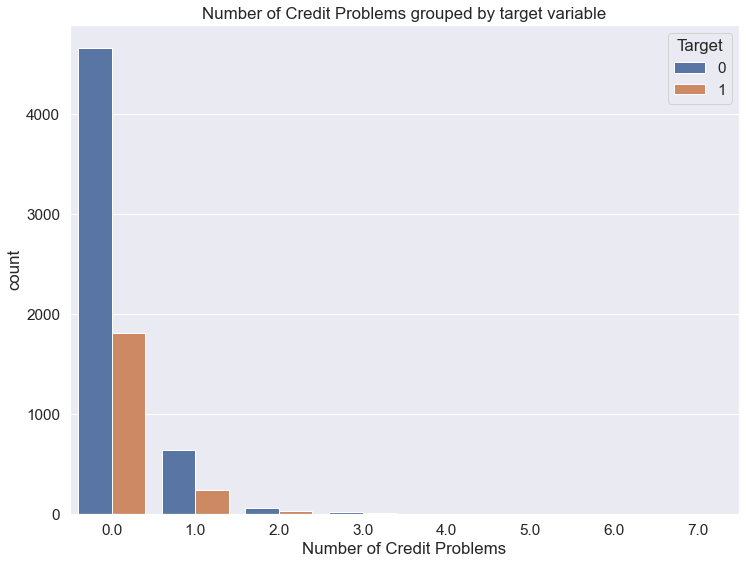

In [1888]:
plt.figure(figsize=(12, 9))

sns.countplot(x='Number of Credit Problems', hue=TARGET_NAME, data=train_df)
plt.title('Number of Credit Problems grouped by target variable')
plt.legend(title='Target', loc='upper right')

plt.show()

In [1889]:
train_df[[TARGET_NAME, 'Number of Credit Problems']].groupby('Number of Credit Problems').agg(['sum', 'mean', 'count'])

Credit Default                
                                     sum      mean count
Number of Credit Problems                               
0.0                               1815.0  0.280569  6469
1.0                                241.0  0.273243   882
2.0                                 33.0  0.354839    93
3.0                                 14.0  0.400000    35
4.0                                  6.0  0.666667     9
5.0                                  4.0  0.571429     7
6.0                                  0.0  0.000000     4
7.0                                  0.0  0.000000     1

In [1890]:
train_df.pivot_table(values=TARGET_NAME, index=[future_name, 'Number of Credit Problems'], aggfunc=['sum', 'mean', 'count'])

sum           mean  \
                                    Credit Default Credit Default   
Tax Liens Number of Credit Problems                                 
0.0       0.0                               1815.0       0.280569   
          1.0                                223.0       0.269976   
          2.0                                 18.0       0.367347   
          3.0                                  5.0       0.333333   
          4.0                                  3.0       0.750000   
          5.0                                  1.0       0.333333   
1.0       1.0                                 18.0       0.321429   
          2.0                                  5.0       0.192308   
          4.0                                  1.0       1.000000   
2.0       2.0                                 10.0       0.555556   
          3.0                                  5.0       0.454545   
          4.0                                  0.0       0.000000   
3.0       3.0                                  4.0       0.444444   
          4.0                                  1.0       1.000000   
4.0       4.0                                  1.0       0.500000   
          5.0                                  2.0       0.666667   
          6.0                                  0.0       0.000000   
5.0       5.0                                  1.0       1.000000   
          6.0                                  0.0       0.000000   
6.0       6.0                                  0.0       0.000000   
7.0       7.0                                  0.0       0.000000   

                                             count  
                                    Credit Default  
Tax Liens Number of Credit Problems                 
0.0       0.0                                 6469  
          1.0                                  826  
          2.0                                   49  
          3.0                                   15  
          4.0                                    4  
          5.0                                    3  
1.0       1.0                                   56  
          2.0                                   26  
          4.0                                    1  
2.0       2.0                                   18  
          3.0                                   11  
          4.0                                    1  
3.0       3.0                                    9  
          4.0                                    1  
4.0       4.0                                    2  
          5.0                                    3  
          6.0                                    1  
5.0       5.0                                    1  
          6.0                                    1  
6.0       6.0                                    2  
7.0       7.0                                    1

**Number of Open Accounts Количество открытых счетов**

In [1891]:
future_name = 'Number of Open Accounts'

In [1892]:
train_df[future_name].describe()

count    7500.000000
mean       11.130934
std         4.908937
min         2.000000
25%         8.000000
50%        10.000000
75%        14.000000
max        43.000000
Name: Number of Open Accounts, dtype: float64

median - 10.0
mean - 11.13093376159668
mode - 9.0


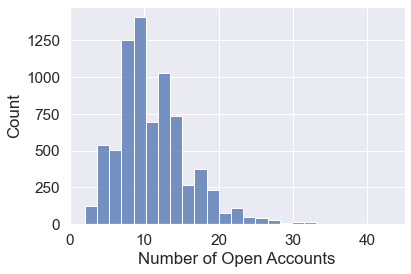

In [1893]:
print(f'median - {np.quantile(train_df[future_name].dropna(), q=0.5)}\nmean - {np.mean(train_df[future_name])}\nmode - {mode(train_df[future_name])[0][0]}')
sns.histplot(train_df[future_name], bins=25);

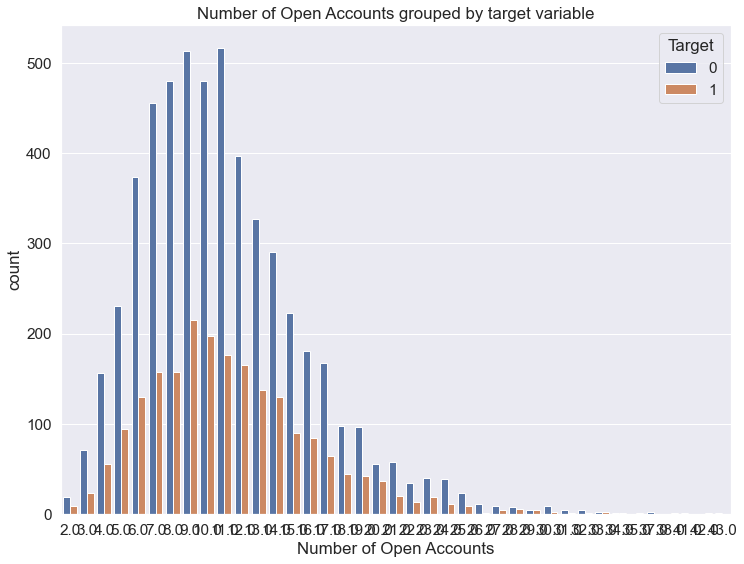

In [1894]:
plt.figure(figsize=(12, 9))

sns.countplot(x=future_name, hue=TARGET_NAME, data=train_df)
plt.title(f'{future_name} grouped by target variable')
plt.legend(title='Target', loc='upper right')

plt.show()

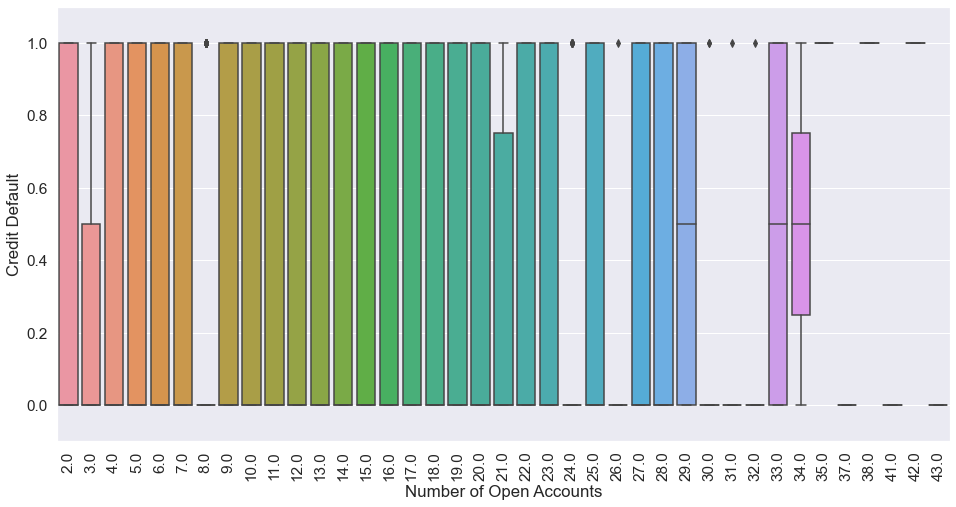

In [1895]:
data = pd.concat([train_df[TARGET_NAME], train_df[future_name]], axis=1)
f, ax = plt.subplots(figsize=(16, 8))
fig = sns.boxplot(x=future_name, y=TARGET_NAME, data=data)
fig.axis(ymin=-0.1, ymax=1.1);
plt.xticks(rotation=90);

In [1896]:
train_df[[TARGET_NAME, future_name]].groupby(TARGET_NAME).agg(['mean', 'sum', 'count'])

Number of Open Accounts               
                                  mean      sum count
Credit Default                                       
0                            11.042138  59484.0  5387
1                            11.357312  23998.0  2113

**Years of Credit History**

In [1897]:
future_name = 'Years of Credit History'

In [1898]:
train_df[future_name].describe()

count    7500.000000
mean       18.317446
std         7.041938
min         4.000000
25%        13.500000
50%        17.000000
75%        21.799999
max        57.700001
Name: Years of Credit History, dtype: float64

In [1899]:
train_df.loc[train_df[future_name] > train_df[future_name].quantile(0.75), TARGET_NAME].agg(['sum', 'mean', 'count'])

sum       505.000000
mean        0.269621
count    1873.000000
Name: Credit Default, dtype: float64

люди с длительной кредитной историей реже просрочивают кредит

In [1900]:
train_df.loc[train_df[future_name] > train_df[future_name].quantile(0.99), TARGET_NAME].agg(['sum', 'mean', 'count'])

sum      25.000000
mean      0.333333
count    75.000000
Name: Credit Default, dtype: float64

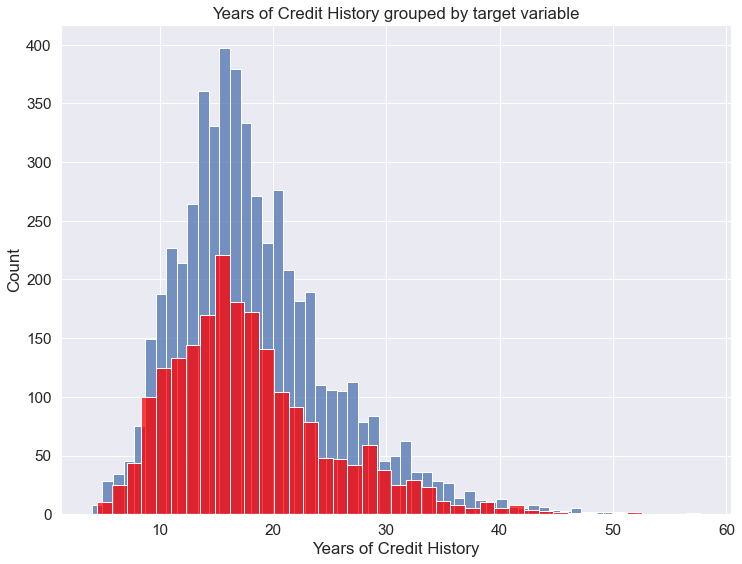

In [1901]:
plt.figure(figsize=(12, 9))

sns.histplot(train_df.loc[train_df[TARGET_NAME] == 0, future_name])
sns.histplot(train_df.loc[train_df[TARGET_NAME] == 1, future_name], color='Red')
plt.title(f'{future_name} grouped by target variable')

plt.show()

In [1902]:
train_df[[TARGET_NAME, future_name]].groupby(TARGET_NAME).agg('mean')

,Years of Credit History
Credit Default,
0,18.408167
1,18.086227


**Maximum Open Credit**

In [1903]:
future_name = 'Maximum Open Credit'

In [1904]:
train_df[future_name].describe()

count    7.500000e+03
mean     9.451526e+05
std      1.602614e+07
min      0.000000e+00
25%      2.792295e+05
50%      4.781590e+05
75%      7.935015e+05
max      1.304726e+09
Name: Maximum Open Credit, dtype: float64

In [1905]:
train_df.loc[train_df[future_name] > train_df[future_name].quantile(0.99), TARGET_NAME].agg(['sum', 'mean', 'count'])

sum       9.00
mean      0.12
count    75.00
Name: Credit Default, dtype: float64

In [1906]:
train_df.loc[train_df[future_name] > train_df[future_name].quantile(0.99), TARGET_NAME]

44      0
85      0
133     0
162     0
301     0
       ..
7144    0
7278    0
7377    0
7388    0
7473    0
Name: Credit Default, Length: 75, dtype: int8

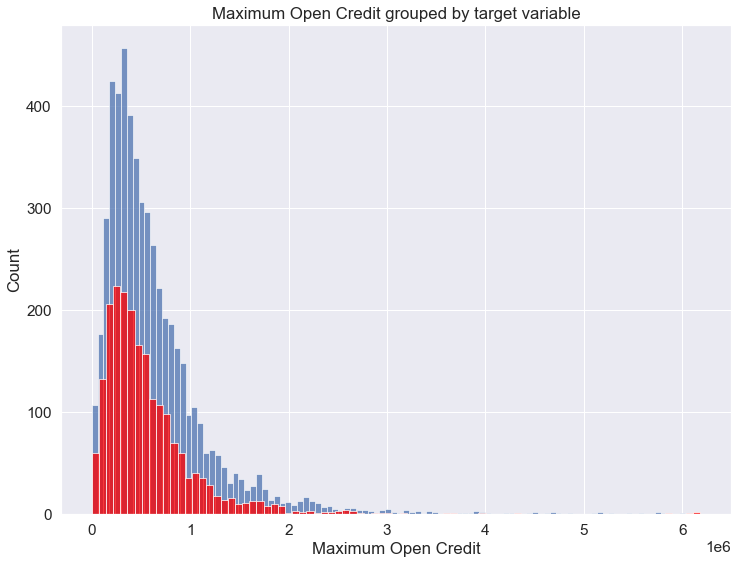

In [1907]:
plt.figure(figsize=(12, 9))

sns.histplot(train_df.loc[(train_df[TARGET_NAME] == 0) & (train_df[future_name] < train_df[future_name].quantile(0.995)), future_name])
sns.histplot(train_df.loc[(train_df[TARGET_NAME] == 1) & (train_df[future_name] < train_df[future_name].quantile(0.995)), future_name], color='Red')
plt.title(f'{future_name} grouped by target variable')

plt.show()

median - 478159.0
mean - 945152.625
mode - 0.0


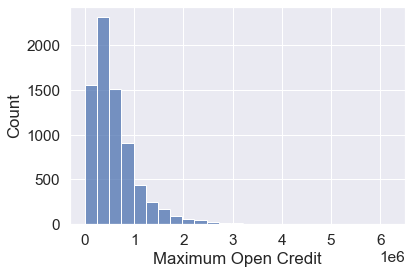

In [1908]:
print(f'median - {np.quantile(train_df[future_name].dropna(), q=0.5)}\nmean - {np.mean(train_df[future_name])}\nmode - {mode(train_df[future_name])[0][0]}')
sns.histplot(train_df.loc[train_df[future_name] < train_df[future_name].quantile(0.995), future_name], bins=25);

очень сильно мешает выброс сильно сбивая

In [1909]:
train_df.loc[(train_df[TARGET_NAME] == 1) & (train_df[future_name] > train_df[future_name].quantile(0.995))]

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
3316,Home Mortgage,NaN,9 years,0.0,17.0,28.4,6619316.0,0.0,NaN,0.0,debt consolidation,Long Term,522874.0,3944514.0,65905.0,NaN,1
5618,Home Mortgage,2814508.0,6 years,0.0,17.0,16.6,6639358.0,0.0,48.0,0.0,debt consolidation,Short Term,516934.0,1221339.0,73412.0,7460.0,1


это два выброса скорее всего

In [1910]:
train_df.loc[train_df[TARGET_NAME] == 1]

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
1,Own Home,1025487.0,10+ years,0.0,15.0,15.300000,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
5,Rent,NaN,7 years,0.0,12.0,14.600000,366784.0,0.0,NaN,0.0,other,Long Term,337304.0,165680.0,18692.0,NaN,1
7,Rent,1040060.0,10+ years,0.0,13.0,12.000000,330374.0,0.0,18.0,0.0,other,Short Term,250888.0,89015.0,19761.0,705.0,1
9,Home Mortgage,NaN,1 year,0.0,10.0,24.600000,511302.0,0.0,6.0,0.0,debt consolidation,Long Term,572880.0,205333.0,17613.0,NaN,1
13,Rent,2066364.0,10+ years,0.0,11.0,17.700001,1654026.0,0.0,NaN,0.0,debt consolidation,Long Term,549780.0,1037077.0,21869.0,728.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7487,Home Mortgage,1542952.0,10+ years,0.0,7.0,12.500000,232364.0,0.0,59.0,0.0,debt consolidation,Long Term,267982.0,198873.0,15430.0,695.0,1
7489,Home Mortgage,1394942.0,10+ years,0.0,15.0,27.200001,1441396.0,0.0,35.0,0.0,debt consolidation,Short Term,753764.0,496698.0,16972.0,742.0,1
7490,Own Home,1368000.0,10+ years,0.0,20.0,26.700001,897842.0,0.0,69.0,0.0,debt consolidation,Short Term,683650.0,517199.0,29868.0,688.0,1
7493,Rent,1257610.0,8 years,0.0,14.0,16.500000,821480.0,0.0,58.0,0.0,debt consolidation,Long Term,448052.0,167428.0,27562.0,676.0,1


**Number of Credit Problems**

In [1911]:
future_name = 'Number of Credit Problems'

In [1912]:
train_df[future_name].describe()

count    7500.0000
mean        0.1700
std         0.4986
min         0.0000
25%         0.0000
50%         0.0000
75%         0.0000
max         7.0000
Name: Number of Credit Problems, dtype: float64

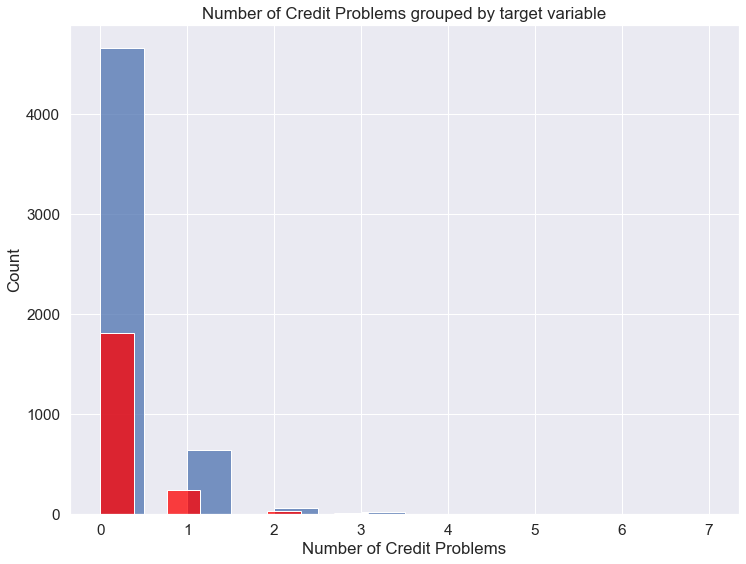

In [1913]:
plt.figure(figsize=(12, 9))

sns.histplot(train_df.loc[train_df[TARGET_NAME] == 0, future_name])
sns.histplot(train_df.loc[train_df[TARGET_NAME] == 1, future_name], color='Red')
plt.title(f'{future_name} grouped by target variable')

plt.show()

In [1914]:
pd.crosstab(train_df[TARGET_NAME], train_df[future_name], margins=True).style.background_gradient(cmap='autumn_r')

Number of Credit Problems,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,All
Credit Default,,,,,,,,,
0,4654,641,60,21,3,3,4,1,5387
1,1815,241,33,14,6,4,0,0,2113
All,6469,882,93,35,9,7,4,1,7500


In [1915]:
train_df[[TARGET_NAME, future_name]].groupby(TARGET_NAME).agg(['mean', 'sum', 'count'])

Number of Credit Problems             
                                    mean    sum count
Credit Default                                       
0                               0.163727  882.0  5387
1                               0.185991  393.0  2113

сдесь модель должна сама разобратся

**Months since last delinquent**

In [1916]:
future_name = 'Months since last delinquent'

In [1917]:
train_df[future_name].describe()

count    3419.000000
mean       34.692600
std        21.688801
min         0.000000
25%        16.000000
50%        32.000000
75%        50.000000
max       118.000000
Name: Months since last delinquent, dtype: float64

In [1918]:
train_df.loc[train_df[future_name].isnull(), TARGET_NAME].agg(['mean', 'count'])

mean        0.276893
count    4081.000000
Name: Credit Default, dtype: float64

я подозреваю что NaN в этом признаке, это те кто только что получили кредит + не заполненные данные

**Bankruptcies**

In [1919]:
future_name = 'Bankruptcies'

In [1920]:
train_df[future_name].describe()

count    7486.000000
mean        0.117152
std         0.347197
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         4.000000
Name: Bankruptcies, dtype: float64

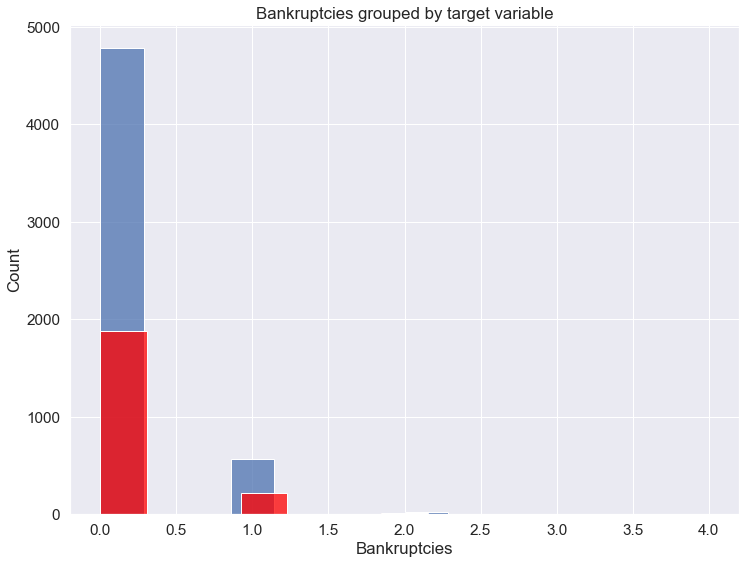

In [1921]:
plt.figure(figsize=(12, 9))

sns.histplot(train_df.loc[train_df[TARGET_NAME] == 0, future_name])
sns.histplot(train_df.loc[train_df[TARGET_NAME] == 1, future_name], color='Red')
plt.title(f'{future_name} grouped by target variable')

plt.show()

In [1922]:
train_df[[TARGET_NAME, future_name]].groupby(TARGET_NAME).agg(['mean', 'sum', 'count'])

Bankruptcies             
                       mean    sum count
Credit Default                          
0                  0.116794  628.0  5377
1                  0.118065  249.0  2109

**Purpose**

In [1923]:
future_name = 'Purpose'

In [1924]:
train_df[future_name].value_counts()

debt consolidation      5944
other                    665
home improvements        412
business loan            129
buy a car                 96
medical bills             71
major purchase            40
take a trip               37
buy house                 34
small business            26
wedding                   15
moving                    11
educational expenses      10
vacation                   8
renewable energy           2
Name: Purpose, dtype: int64

In [1925]:
train_df[[TARGET_NAME, future_name]].groupby(future_name).agg(['mean', 'sum', 'count'])

Credit Default              
                               mean     sum count
Purpose                                          
business loan              0.426357    55.0   129
buy a car                  0.250000    24.0    96
buy house                  0.264706     9.0    34
debt consolidation         0.278264  1654.0  5944
educational expenses       0.100000     1.0    10
home improvements          0.262136   108.0   412
major purchase             0.225000     9.0    40
medical bills              0.309859    22.0    71
moving                     0.181818     2.0    11
other                      0.296241   197.0   665
renewable energy           1.000000     2.0     2
small business             0.538462    14.0    26
take a trip                0.270270    10.0    37
vacation                   0.250000     2.0     8
wedding                    0.266667     4.0    15

**Term**

In [1926]:
future_name = 'Term'

In [1927]:
train_df[future_name].value_counts()

Short Term    5556
Long Term     1944
Name: Term, dtype: int64

**Current Loan Amount**

In [1928]:
future_name = 'Current Loan Amount'

In [1929]:
train_df[future_name].describe()

count         7500.0
mean      11873135.0
std       31926302.0
min          11242.0
25%         180169.0
50%         309573.0
75%         519882.0
max      100000000.0
Name: Current Loan Amount, dtype: float64

In [1930]:
train_df[future_name].value_counts()

100000000.0    870
89298.0          6
218064.0         6
216106.0         5
265826.0         5
              ... 
222860.0         1
104324.0         1
201080.0         1
427812.0         1
191136.0         1
Name: Current Loan Amount, Length: 5386, dtype: int64

1 строчка это выбросы. Скорее всего это ошибка при заполнении таблиц. нужно заменить на медиану

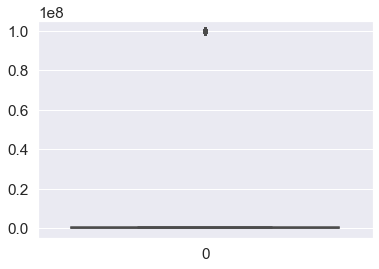

In [1931]:
sns.boxplot(data = train_df[future_name])
plt.show()

**Current Credit Balance**

текущий кредитный баланс: 

сумма вашей задолженности по кредитной карте 

    или
    
сумма денег на банковском счете

In [1932]:
future_name = 'Current Credit Balance'

In [1933]:
train_df[future_name].describe()

count    7.500000e+03
mean     2.898332e+05
std      3.178713e+05
min      0.000000e+00
25%      1.142565e+05
50%      2.093230e+05
75%      3.604062e+05
max      6.506797e+06
Name: Current Credit Balance, dtype: float64

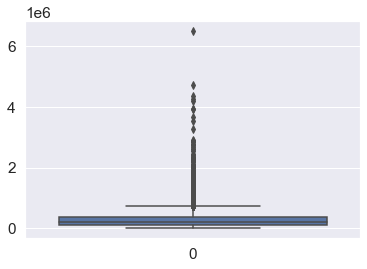

In [1934]:
sns.boxplot(data = train_df[future_name])
plt.show()

In [1935]:
train_df[[TARGET_NAME, future_name]].groupby(TARGET_NAME).agg(['median', 'sum', 'count'])

Current Credit Balance                    
                               median           sum count
Credit Default                                           
0                            209285.0  1.582266e+09  5387
1                            210102.0  5.914828e+08  2113

**Monthly Debt**

In [1936]:
future_name = 'Monthly Debt'

In [1937]:
train_df[future_name].describe()

count      7500.000000
mean      18314.453125
std       11926.758789
min           0.000000
25%       10067.500000
50%       16076.500000
75%       23818.000000
max      136679.000000
Name: Monthly Debt, dtype: float64

In [1938]:
train_df[[TARGET_NAME, future_name]].groupby(TARGET_NAME).agg(['median', 'count'])

Monthly Debt      
                     median count
Credit Default                   
0                   15939.0  5387
1                   16390.0  2113

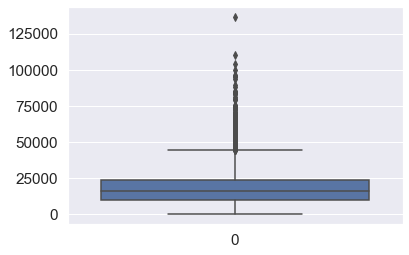

In [1939]:
sns.boxplot(data = train_df[future_name])
plt.show()

**Credit Score**

In [1940]:
future_name = 'Credit Score'

In [1941]:
train_df[future_name].describe()

count    5943.000000
mean     1151.087524
std      1604.447510
min       585.000000
25%       711.000000
50%       731.000000
75%       743.000000
max      7510.000000
Name: Credit Score, dtype: float64

In [1942]:
train_df[[TARGET_NAME, future_name]].groupby(TARGET_NAME).agg(['median', 'count'])

Credit Score      
                     median count
Credit Default                   
0                     732.0  4359
1                     730.5  1584

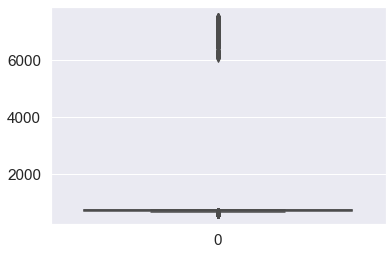

In [1943]:
sns.boxplot(data = train_df[future_name])
plt.show()

**Выводы EDA**

0 - Выборка не сбалансированная

1 - Во всех данных присутствуют выбросы, надо разбиратся

2 - Есть NaN в 

            Annual Income                   
            Years in current job             
            Months since last delinquent    
            Bankruptcies                    
            Credit Score  
            
3 - 'Home Ownership' признак не сильно влияет на целевую переменную можно заменить на признак среднего по просрочке кредита(чтоб не плодить дамми переменные).

4 - Annual Income удалить строки с высоким доходом и просрочкой кредита 
                Создать признаки : сигментировать доход и ежемесячный платеж(по квантилям), Признак среднего по доходу и    емесечному платежу(от признаков по квантилям) NaN заполнить по формуле макс кредит / высчитанное значение (рассчитать для групп)за исключением если есть NaN в Years in current job, тогда оба 0
                
5 - Tax Liens странный признак, надо проверить его корреляцию с другими после обработки выбросов и пропусков
его стоит оставить на откуп модели, вместе с 'Number of Credit Problems' возможно данные признаки будут плохо влиять на целевую переменную и их надо будет удалить

6 - Maximum Open Credit, Current Loan Amount, Credit Score содержат серьезные выбросы

7 - Years of Credit History выбросы сносить не надо

8- Maximum Open Credit разобратся с просрочкой при максимальном размере(это 2 выброса)(удалить 2 строки), но вопрос в кредитном рейтинге

9 - Months since last delinquent NaN заполнить 0лями

10 - Bankruptcies заполнить 0

11 - Purpose можно заменить на признак среднего по просрочке кредита(чтоб не плодить дамми переменные).

12 - Current Loan Amount 100000000.0  значения заменить на максимальное

13 - Current Credit Balance переделать выбросы превышающие 3 сигмы на медиану(рассчитанную отдельно для целевой переменной)

14 - Credit Score все что выше 4000 удалить нафиг

**Обработка выбросов и пропусков**

Обработка выбросов

In [1944]:
future_name = 'Annual Income'
_ = train_df.loc[(train_df[future_name] > train_df[future_name].dropna().mean() + 
              3*train_df[future_name].dropna().std()) & (train_df[TARGET_NAME] != 0)].index
_

Int64Index([1202, 2535, 4271, 4439, 4491, 5396, 5677, 6727, 6997, 7036, 7410], dtype='int64')

In [1945]:
train_df.drop(_, inplace=True)

проверка, есть в тесте люди с высоким доходом и ежемесячным платежом превышающим доход

In [1946]:
test_df[(test_df[future_name] > 4120226) & test_df['Monthly Debt']*12 > 4120226]

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score


In [1950]:
train_df['Current Credit Balance'].describe()

count    7.489000e+03
mean     2.626807e+05
std      2.116265e+05
min      0.000000e+00
25%      1.141520e+05
50%      2.092660e+05
75%      3.459520e+05
max      1.235969e+06
Name: Current Credit Balance, dtype: float64

In [1951]:
for el in ['Maximum Open Credit', 'Credit Score', 'Current Credit Balance']:
    print(train_df[el].max())
    emissions_del(el)
    print(train_df[el].max())

40923896.0
3913517.9375
3908388.0
751.0
795.9144096374512
751.0
1235969.0
897560.046875
894748.0


In [1952]:
train_df[(train_df['Current Loan Amount'] == 100000000.0)&(train_df[TARGET_NAME]==1)]

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default


In [1953]:
train_df['Current Loan Amount'].quantile(0.88)

785979.0399999999

In [1954]:
train_df.loc[train_df['Current Loan Amount'] == 100000000.0, 'Current Loan Amount'] = train_df['Current Loan Amount'].quantile(0.88)

In [1955]:
test_df.loc[test_df['Current Loan Amount'] == 100000000.0, 'Current Loan Amount'] = train_df['Current Loan Amount'].quantile(0.88)

In [1956]:
test_df[test_df['Current Loan Amount'] == 100000000.0]

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score


In [1957]:
future_name = 'Maximum Open Credit'

In [1958]:
_ = train_df.loc[(train_df[TARGET_NAME] == 1) & (train_df[future_name] > train_df[future_name].quantile(0.995))].index

In [1959]:
train_df.drop(_, inplace=True)

In [1960]:
test_df.loc[test_df[future_name] > train_df[future_name].quantile(0.995)]

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
45,Home Mortgage,1768729.0,10+ years,0.0,11.0,19.700001,3462558.0,0.0,NaN,0.0,debt consolidation,Short Term,785962.8125,209266.0,29184.0,737.0
187,Home Mortgage,1823867.0,5 years,0.0,14.0,24.000000,3826020.0,0.0,NaN,0.0,debt consolidation,Short Term,449328.0000,209266.0,26613.0,742.0
288,Home Mortgage,1540216.0,10+ years,0.0,25.0,23.799999,2975060.0,0.0,NaN,0.0,debt consolidation,Long Term,378972.0000,565250.0,42741.0,740.0
833,Home Mortgage,2125948.0,10+ years,0.0,16.0,23.400000,3161884.0,0.0,NaN,0.0,debt consolidation,Short Term,626604.0000,786448.0,32952.0,747.0
968,Rent,1976570.0,10+ years,0.0,12.0,22.500000,3538656.0,0.0,NaN,0.0,debt consolidation,Long Term,448756.0000,209266.0,17888.0,723.0
1104,Home Mortgage,2725436.0,< 1 year,0.0,7.0,28.900000,3803932.0,0.0,NaN,0.0,debt consolidation,Short Term,405746.0000,209266.0,18056.0,748.0
1467,Home Mortgage,NaN,10+ years,0.0,18.0,23.600000,3321406.0,0.0,48.0,0.0,debt consolidation,Long Term,660924.0000,209266.0,23848.0,731.0
1686,Home Mortgage,835848.0,10+ years,0.0,9.0,23.600000,3434464.0,0.0,43.0,0.0,home improvements,Short Term,139788.0000,848312.0,18876.0,722.0
1976,Home Mortgage,3228195.0,9 years,0.0,16.0,31.000000,2811534.0,0.0,NaN,0.0,debt consolidation,Long Term,764918.0000,209266.0,66447.0,722.0
2153,Home Mortgage,NaN,10+ years,0.0,20.0,24.900000,3366792.0,0.0,NaN,0.0,debt consolidation,Short Term,664224.0000,209266.0,53875.0,731.0


обработка пропусков

            Annual Income                   
            Years in current job             
            Months since last delinquent    
            Bankruptcies                    
            Credit Score  

In [1961]:
future_name = 'Annual Income'

In [1962]:
train_df.loc[(train_df[future_name].isnull()) & 
             (train_df['Years in current job'].isnull()), [future_name]] = 0

In [1963]:
test_df.loc[(test_df[future_name].isnull()) & 
             (test_df['Years in current job'].isnull()), [future_name]] = 0

In [1964]:
An_mean = train_df.loc[train_df[future_name].notnull(), future_name].mean()
An_mean

1341470.125

In [1965]:
Ma_mean = train_df.loc[train_df['Maximum Open Credit'].notnull(), 'Maximum Open Credit'].mean()
Ma_mean

603965.0625

In [1966]:
_ = An_mean / Ma_mean
_

2.2211055047575705

In [1967]:
train_df.loc[train_df[future_name].isnull(), 'Maximum Open Credit']

5       366784.0
8            0.0
9       511302.0
10      256322.0
16      899492.0
          ...   
7470    431310.0
7482    645062.0
7492    423984.0
7494    301554.0
7499    480832.0
Name: Maximum Open Credit, Length: 1481, dtype: float32

In [1968]:
train_df.loc[train_df[future_name].isnull(), future_name] = train_df.loc[train_df[future_name].isnull(), 'Maximum Open Credit'] * _

In [1969]:
train_df.loc[train_df[future_name] == 0, future_name] = train_df[future_name].mean()

In [1970]:
test_df.loc[test_df[future_name].isnull(), future_name] = test_df.loc[test_df[future_name].isnull(), 'Maximum Open Credit'] * _

In [1971]:
test_df.loc[test_df[future_name] == 0, future_name]  = train_df[future_name].mean()

In [1972]:
future_name = 'Years in current job'

In [1973]:
train_df[future_name].fillna('< 1 year', inplace = True)
test_df[future_name].fillna('< 1 year', inplace = True)

In [1974]:
future_name = 'Months since last delinquent'

In [1975]:
train_df[future_name].fillna(0, inplace = True)
test_df[future_name].fillna(0, inplace = True)

In [1976]:
future_name = 'Bankruptcies'

In [1977]:
train_df[future_name].fillna(0, inplace = True)
test_df[future_name].fillna(0, inplace = True)

In [1978]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7484 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype   
---  ------                        --------------  -----   
 0   Home Ownership                7484 non-null   category
 1   Annual Income                 7484 non-null   float32 
 2   Years in current job          7484 non-null   category
 3   Tax Liens                     7484 non-null   float32 
 4   Number of Open Accounts       7484 non-null   float32 
 5   Years of Credit History       7484 non-null   float32 
 6   Maximum Open Credit           7484 non-null   float32 
 7   Number of Credit Problems     7484 non-null   float32 
 8   Months since last delinquent  7484 non-null   float32 
 9   Bankruptcies                  7484 non-null   float32 
 10  Purpose                       7484 non-null   category
 11  Term                          7484 non-null   category
 12  Current Loan Amount           7484 non-null   fl

In [1979]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype   
---  ------                        --------------  -----   
 0   Home Ownership                2500 non-null   category
 1   Annual Income                 2500 non-null   float32 
 2   Years in current job          2500 non-null   category
 3   Tax Liens                     2500 non-null   float32 
 4   Number of Open Accounts       2500 non-null   float32 
 5   Years of Credit History       2500 non-null   float32 
 6   Maximum Open Credit           2500 non-null   float32 
 7   Number of Credit Problems     2500 non-null   float32 
 8   Months since last delinquent  2500 non-null   float32 
 9   Bankruptcies                  2500 non-null   float32 
 10  Purpose                       2500 non-null   category
 11  Term                          2500 non-null   category
 12  Current Loan Amount           2500 non-null   fl

Future Engineering

In [1980]:
future_name = 'Annual Income'

In [1981]:
cat_list = [ _ for _ in range(10)]
train_df['Annual_Income_group'] = pd.qcut(train_df[future_name], q=10, labels=cat_list)
train_df['Monthly Debt_group'] = pd.qcut(train_df['Monthly Debt'], q=10, labels=cat_list)
train_df[['Annual_Income_group', 'Monthly Debt_group']]

,Annual_Income_group,Monthly Debt_group
0,0,1
1,4,5
2,2,4
3,2,3
4,2,1
...,...,...
7495,0,0
7496,7,3
7497,8,3
7498,5,9


In [1982]:
test_df['Annual_Income_group'] = pd.qcut(test_df[future_name], q=10, labels=cat_list)
test_df['Monthly Debt_group'] = pd.qcut(test_df['Monthly Debt'], q=10, labels=cat_list)

In [1983]:
Annual_Income_MoDept_med_by_target = train_df.pivot_table(values='Credit Default', 
                                                              index=['Annual_Income_group', 'Monthly Debt_group'], aggfunc='mean').rename(columns={'Credit Default':'Annual_Income_MoDept_med_by_target'})
Annual_Income_MoDept_med_by_target.reset_index(inplace=True)
Annual_Income_MoDept_med_by_target

,Annual_Income_group,Monthly Debt_group,Annual_Income_MoDept_med_by_target
0,0,0,0.293651
1,0,1,0.402597
2,0,2,0.401786
3,0,3,0.369048
4,0,4,0.300000
...,...,...,...
95,9,5,0.228571
96,9,6,0.152542
97,9,7,0.146341
98,9,8,0.181102


In [1984]:
test_df = test_df.merge(Annual_Income_MoDept_med_by_target, on=['Annual_Income_group', 'Monthly Debt_group'], how='left')
train_df = train_df.merge(Annual_Income_MoDept_med_by_target, on=['Annual_Income_group', 'Monthly Debt_group'], how='left')
train_df.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default,Annual_Income_group,Monthly Debt_group,Annual_Income_MoDept_med_by_target
0,Own Home,482087.0,< 1 year,0.0,11.0,26.299999,685960.0,1.0,0.0,1.0,debt consolidation,Short Term,785979.0625,47386.0,7914.0,749.0,0,0,1,0.402597
1,Own Home,1025487.0,10+ years,0.0,15.0,15.300000,1181730.0,0.0,0.0,0.0,debt consolidation,Long Term,264968.0000,394972.0,18373.0,737.0,1,4,5,0.302083
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.000000,1182434.0,0.0,0.0,0.0,debt consolidation,Short Term,785979.0625,308389.0,13651.0,742.0,0,2,4,0.245283
3,Own Home,805068.0,6 years,0.0,8.0,22.500000,147400.0,1.0,0.0,1.0,debt consolidation,Short Term,121396.0000,95855.0,11338.0,694.0,0,2,3,0.347826
4,Rent,776264.0,8 years,0.0,13.0,13.600000,385836.0,1.0,0.0,0.0,debt consolidation,Short Term,125840.0000,93309.0,7180.0,719.0,0,2,1,0.244898


In [1985]:
future_name = 'Purpose'

In [1986]:
med_price_by_Purpose = train_df.groupby(['Purpose'], as_index=False).agg({TARGET_NAME:'mean'}).rename(columns={TARGET_NAME:'MedPriceByPurpose'})
med_price_by_Purpose.head(10)

,Purpose,MedPriceByPurpose
0,business loan,0.417323
1,buy a car,0.250000
2,buy house,0.264706
3,debt consolidation,0.276926
4,educational expenses,0.100000
5,home improvements,0.260341
6,major purchase,0.225000
7,medical bills,0.309859
8,moving,0.181818
9,other,0.295181


In [1987]:
test_df = test_df.merge(med_price_by_Purpose, on=['Purpose'], how='left')
train_df = train_df.merge(med_price_by_Purpose, on=['Purpose'], how='left')
train_df.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,...,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default,Annual_Income_group,Monthly Debt_group,Annual_Income_MoDept_med_by_target,MedPriceByPurpose
0,Own Home,482087.0,< 1 year,0.0,11.0,26.299999,685960.0,1.0,0.0,1.0,...,Short Term,785979.0625,47386.0,7914.0,749.0,0,0,1,0.402597,0.276926
1,Own Home,1025487.0,10+ years,0.0,15.0,15.300000,1181730.0,0.0,0.0,0.0,...,Long Term,264968.0000,394972.0,18373.0,737.0,1,4,5,0.302083,0.276926
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.000000,1182434.0,0.0,0.0,0.0,...,Short Term,785979.0625,308389.0,13651.0,742.0,0,2,4,0.245283,0.276926
3,Own Home,805068.0,6 years,0.0,8.0,22.500000,147400.0,1.0,0.0,1.0,...,Short Term,121396.0000,95855.0,11338.0,694.0,0,2,3,0.347826,0.276926
4,Rent,776264.0,8 years,0.0,13.0,13.600000,385836.0,1.0,0.0,0.0,...,Short Term,125840.0000,93309.0,7180.0,719.0,0,2,1,0.244898,0.276926


In [1988]:
train_df_finished = train_df.drop('Purpose', axis=1)
test_df_finished = test_df.drop('Purpose', axis=1)

создание дамми переменых

In [1989]:
train_df_dm_TNSE = train_df_finished.drop(TARGET_NAME, axis=1)

In [1990]:
train_objs_num = len(train_df_dm_TNSE)
dataset = pd.concat(objs=[train_df_dm_TNSE, test_df_finished], axis=0)
dataset_preprocessed = pd.get_dummies(dataset)
train_df_dm = dataset_preprocessed[:train_objs_num]
test_df_dm = dataset_preprocessed[train_objs_num:]
train_df_dm.head(2)

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,...,Monthly Debt_group_0,Monthly Debt_group_1,Monthly Debt_group_2,Monthly Debt_group_3,Monthly Debt_group_4,Monthly Debt_group_5,Monthly Debt_group_6,Monthly Debt_group_7,Monthly Debt_group_8,Monthly Debt_group_9
0,482087.0,0.0,11.0,26.299999,685960.0,1.0,0.0,1.0,785979.0625,47386.0,...,0,1,0,0,0,0,0,0,0,0
1,1025487.0,0.0,15.0,15.300000,1181730.0,0.0,0.0,0.0,264968.0000,394972.0,...,0,0,0,0,0,1,0,0,0,0


**Добавление меток кластера**

подготовка данных

In [1991]:
scaler = RobustScaler()

colnames = train_df_dm.columns
train_df_dm_scaled = pd.DataFrame(scaler.fit_transform(train_df_dm), columns=colnames)
test_df_dm_scaled = pd.DataFrame(scaler.transform(test_df_dm), columns=colnames)
train_df_dm_scaled.head(2)

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,...,Monthly Debt_group_0,Monthly Debt_group_1,Monthly Debt_group_2,Monthly Debt_group_3,Monthly Debt_group_4,Monthly Debt_group_5,Monthly Debt_group_6,Monthly Debt_group_7,Monthly Debt_group_8,Monthly Debt_group_9
0,-0.820407,0.0,0.166667,1.120482,0.416888,1.0,0.0,1.0,1.410991,-0.741674,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.169525,0.0,0.833333,-0.204819,1.406676,0.0,0.0,0.0,-0.129974,0.853269,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [1992]:
dim_reducer = TSNE(n_components=2, learning_rate=250, random_state=42, perplexity=30)
train_df_dm_scaled_tsne = dim_reducer.fit_transform(train_df_dm_scaled)       

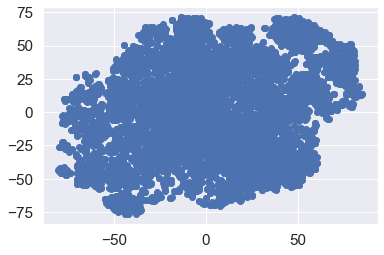

In [1993]:
plt.scatter(train_df_dm_scaled_tsne[:, 0], train_df_dm_scaled_tsne[:, 1])

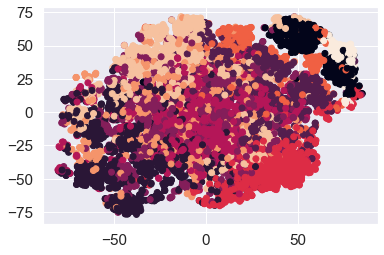

In [1994]:
kmeans = KMeans(n_clusters=10, random_state=42)

labels_train = kmeans.fit_predict(train_df_dm_scaled)

plt.scatter(train_df_dm_scaled_tsne[:, 0], train_df_dm_scaled_tsne[:, 1], c=labels_train)

plt.show()

In [1995]:
labels_test = kmeans.predict(test_df_dm_scaled)

In [1996]:
labels_train = pd.Series(labels_train, name='clusters')
labels_test = pd.Series(labels_test, name='clusters')

clusters_dummies = pd.get_dummies(labels_train, drop_first=True, prefix='clusters')

train_df_cluster = pd.concat([train_df_dm, clusters_dummies], axis=1)

clusters_dummies_test = pd.get_dummies(labels_test, drop_first=True, prefix='clusters')

test_df_cluster = pd.concat([test_df_dm, clusters_dummies_test], axis=1)

In [1997]:
train_df_cluster.head(2)

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,...,Monthly Debt_group_9,clusters_1,clusters_2,clusters_3,clusters_4,clusters_5,clusters_6,clusters_7,clusters_8,clusters_9
0,482087.0,0.0,11.0,26.299999,685960.0,1.0,0.0,1.0,785979.0625,47386.0,...,0,0,0,0,0,0,0,1,0,0
1,1025487.0,0.0,15.0,15.300000,1181730.0,0.0,0.0,0.0,264968.0000,394972.0,...,0,0,0,0,1,0,0,0,0,0


**Выделение главных компонент**

In [1998]:
pca = PCA(n_components=3, random_state=100)

train_pca = pca.fit_transform(train_df_dm_scaled)
test_pca = pca.transform(test_df_dm_scaled)

In [1999]:
X_train_pca = pd.DataFrame(train_pca, columns=['pca1', 'pca2', 'pca3'])
X_test_pca = pd.DataFrame(test_pca, columns=['pca1', 'pca2', 'pca3'])

In [2000]:
train_df_dm_finished = pd.concat([train_df_cluster, X_train_pca], axis=1)

test_df_dm_finished = pd.concat([test_df_cluster, X_test_pca], axis=1)
test_df_dm_finished

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,...,clusters_3,clusters_4,clusters_5,clusters_6,clusters_7,clusters_8,clusters_9,pca1,pca2,pca3
0,490793.25,0.0,9.0,12.500000,220968.0,0.0,70.0,0.0,162470.0000,105906.0,...,1,0,0,0,0,0,0,-2.258240,-0.312542,-0.463529
1,231838.00,0.0,6.0,32.700001,55946.0,0.0,8.0,0.0,78298.0000,46037.0,...,0,0,0,0,1,0,0,-2.329413,0.821046,0.149280
2,1152540.00,0.0,10.0,13.700000,204600.0,0.0,0.0,0.0,200178.0000,146490.0,...,0,1,0,0,0,0,0,-0.864246,-0.444241,0.057189
3,1220313.00,0.0,16.0,17.000000,456302.0,0.0,70.0,0.0,217382.0000,213199.0,...,1,0,0,0,0,0,0,0.045070,-0.499066,-0.990663
4,2340952.00,0.0,11.0,23.600000,1207272.0,0.0,0.0,0.0,777634.0000,425391.0,...,0,0,0,0,0,0,0,2.950268,1.126401,0.323397
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,1020053.00,0.0,14.0,29.100000,559152.0,1.0,68.0,1.0,785962.8125,162735.0,...,1,0,0,0,0,0,0,0.002647,-0.835279,-0.813751
2496,3859792.75,0.0,15.0,17.000000,1737780.0,0.0,77.0,0.0,468512.0000,209266.0,...,0,0,0,0,0,0,0,3.482534,-0.407449,1.326996
2497,1171806.00,0.0,48.0,12.800000,1706430.0,0.0,0.0,0.0,430496.0000,676438.0,...,0,0,0,1,0,0,0,3.483589,1.709319,-4.689442
2498,723520.00,0.0,14.0,28.799999,945780.0,0.0,0.0,0.0,257774.0000,391248.0,...,0,0,0,0,1,0,0,0.082938,-1.137346,-1.686288


**Обучение и оценка модели**

In [2001]:
#colnames = train_df_dm_finished.columns
#train_df_dm_finished = pd.DataFrame(scaler.fit_transform(train_df_dm_finished), columns=colnames)
#test_df_dm_finished = pd.DataFrame(scaler.transform(test_df_dm_finished), columns=colnames)
#train_df_dm_scaled.head(2)

In [2002]:
import catboost as catb

In [2003]:
X = train_df_dm_finished
y = train_df[TARGET_NAME]

In [2004]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.30, random_state=21)

In [2050]:
df_for_balancing = pd.concat([X_train, y_train], axis=1)
df_balanced = balance_df_by_target(df_for_balancing, TARGET_NAME)
    
df_balanced[TARGET_NAME].value_counts()

0    3760
1    2956
Name: Credit Default, dtype: int64

In [2051]:
model_catb = catb.CatBoostClassifier(class_weights=[1, 3], random_state=21)

In [2052]:
#params = {'n_estimators':[725, 750, 775],
          #'max_depth':[3,],
   # 'learning_rate': [0.03, 0.1, 0.15]}

In [2053]:
cv=StratifiedKFold(n_splits=5, random_state=21, shuffle=True)

In [2054]:
params = {#'learning_rate': [0.03, 0.1, 0.15],
          'l2_leaf_reg': [3, 4, 5]}
gs = GridSearchCV(model_catb, params, scoring="roc_auc", cv=cv)
gs.fit(X, y)


0:	learn: 0.6860991	total: 13.4ms	remaining: 13.4s
1:	learn: 0.6794960	total: 25.3ms	remaining: 12.6s
2:	learn: 0.6740793	total: 43ms	remaining: 14.3s
3:	learn: 0.6676121	total: 56.5ms	remaining: 14.1s
4:	learn: 0.6620507	total: 70.7ms	remaining: 14.1s
5:	learn: 0.6573136	total: 82.8ms	remaining: 13.7s
6:	learn: 0.6524191	total: 95.8ms	remaining: 13.6s
7:	learn: 0.6476199	total: 111ms	remaining: 13.8s
8:	learn: 0.6432405	total: 127ms	remaining: 13.9s
9:	learn: 0.6396423	total: 140ms	remaining: 13.9s
10:	learn: 0.6366144	total: 154ms	remaining: 13.8s
11:	learn: 0.6339046	total: 169ms	remaining: 13.9s
12:	learn: 0.6305543	total: 191ms	remaining: 14.5s
13:	learn: 0.6279009	total: 205ms	remaining: 14.4s
14:	learn: 0.6248623	total: 221ms	remaining: 14.5s
15:	learn: 0.6225050	total: 257ms	remaining: 15.8s
16:	learn: 0.6207565	total: 272ms	remaining: 15.7s
17:	learn: 0.6185969	total: 293ms	remaining: 16s
18:	learn: 0.6164474	total: 303ms	remaining: 15.7s
19:	learn: 0.6149228	total: 313ms	rema

174:	learn: 0.5341935	total: 2.33s	remaining: 11s
175:	learn: 0.5339054	total: 2.35s	remaining: 11s
176:	learn: 0.5335268	total: 2.37s	remaining: 11s
177:	learn: 0.5331737	total: 2.37s	remaining: 11s
178:	learn: 0.5327744	total: 2.38s	remaining: 10.9s
179:	learn: 0.5324611	total: 2.4s	remaining: 10.9s
180:	learn: 0.5320514	total: 2.4s	remaining: 10.9s
181:	learn: 0.5318425	total: 2.41s	remaining: 10.9s
182:	learn: 0.5315682	total: 2.42s	remaining: 10.8s
183:	learn: 0.5312926	total: 2.43s	remaining: 10.8s
184:	learn: 0.5310004	total: 2.44s	remaining: 10.8s
185:	learn: 0.5307065	total: 2.48s	remaining: 10.9s
186:	learn: 0.5302696	total: 2.69s	remaining: 11.7s
187:	learn: 0.5301050	total: 2.73s	remaining: 11.8s
188:	learn: 0.5299670	total: 2.77s	remaining: 11.9s
189:	learn: 0.5298340	total: 2.85s	remaining: 12.2s
190:	learn: 0.5295797	total: 2.87s	remaining: 12.2s
191:	learn: 0.5293985	total: 2.9s	remaining: 12.2s
192:	learn: 0.5290701	total: 2.92s	remaining: 12.2s
193:	learn: 0.5288523	t

342:	learn: 0.4876632	total: 5.48s	remaining: 10.5s
343:	learn: 0.4872310	total: 5.49s	remaining: 10.5s
344:	learn: 0.4869019	total: 5.5s	remaining: 10.4s
345:	learn: 0.4866154	total: 5.51s	remaining: 10.4s
346:	learn: 0.4863226	total: 5.52s	remaining: 10.4s
347:	learn: 0.4858439	total: 5.53s	remaining: 10.4s
348:	learn: 0.4856410	total: 5.54s	remaining: 10.3s
349:	learn: 0.4852236	total: 5.54s	remaining: 10.3s
350:	learn: 0.4849141	total: 5.56s	remaining: 10.3s
351:	learn: 0.4847124	total: 5.57s	remaining: 10.3s
352:	learn: 0.4843894	total: 5.58s	remaining: 10.2s
353:	learn: 0.4840884	total: 5.58s	remaining: 10.2s
354:	learn: 0.4837270	total: 5.59s	remaining: 10.2s
355:	learn: 0.4834259	total: 5.6s	remaining: 10.1s
356:	learn: 0.4831659	total: 5.61s	remaining: 10.1s
357:	learn: 0.4828692	total: 5.62s	remaining: 10.1s
358:	learn: 0.4825695	total: 5.63s	remaining: 10.1s
359:	learn: 0.4822285	total: 5.64s	remaining: 10s
360:	learn: 0.4820104	total: 5.65s	remaining: 9.99s
361:	learn: 0.48

519:	learn: 0.4307812	total: 7.19s	remaining: 6.64s
520:	learn: 0.4304393	total: 7.2s	remaining: 6.62s
521:	learn: 0.4301034	total: 7.21s	remaining: 6.6s
522:	learn: 0.4299315	total: 7.22s	remaining: 6.58s
523:	learn: 0.4296702	total: 7.23s	remaining: 6.56s
524:	learn: 0.4292321	total: 7.24s	remaining: 6.55s
525:	learn: 0.4289304	total: 7.25s	remaining: 6.53s
526:	learn: 0.4286516	total: 7.26s	remaining: 6.51s
527:	learn: 0.4284391	total: 7.26s	remaining: 6.49s
528:	learn: 0.4282280	total: 7.27s	remaining: 6.48s
529:	learn: 0.4280011	total: 7.28s	remaining: 6.46s
530:	learn: 0.4278305	total: 7.29s	remaining: 6.44s
531:	learn: 0.4277021	total: 7.3s	remaining: 6.42s
532:	learn: 0.4273663	total: 7.31s	remaining: 6.41s
533:	learn: 0.4269688	total: 7.32s	remaining: 6.39s
534:	learn: 0.4267329	total: 7.33s	remaining: 6.37s
535:	learn: 0.4265344	total: 7.34s	remaining: 6.35s
536:	learn: 0.4262949	total: 7.35s	remaining: 6.34s
537:	learn: 0.4259716	total: 7.36s	remaining: 6.32s
538:	learn: 0.4

685:	learn: 0.3869489	total: 8.74s	remaining: 4s
686:	learn: 0.3866168	total: 8.75s	remaining: 3.99s
687:	learn: 0.3863974	total: 8.76s	remaining: 3.97s
688:	learn: 0.3860905	total: 8.77s	remaining: 3.96s
689:	learn: 0.3857086	total: 8.78s	remaining: 3.94s
690:	learn: 0.3855061	total: 8.79s	remaining: 3.93s
691:	learn: 0.3851858	total: 8.8s	remaining: 3.92s
692:	learn: 0.3850062	total: 8.81s	remaining: 3.9s
693:	learn: 0.3847327	total: 8.81s	remaining: 3.89s
694:	learn: 0.3845145	total: 8.82s	remaining: 3.87s
695:	learn: 0.3842540	total: 8.84s	remaining: 3.86s
696:	learn: 0.3840666	total: 8.84s	remaining: 3.84s
697:	learn: 0.3838742	total: 8.85s	remaining: 3.83s
698:	learn: 0.3836643	total: 8.86s	remaining: 3.81s
699:	learn: 0.3834068	total: 8.87s	remaining: 3.8s
700:	learn: 0.3832140	total: 8.88s	remaining: 3.79s
701:	learn: 0.3829183	total: 8.89s	remaining: 3.77s
702:	learn: 0.3825976	total: 8.9s	remaining: 3.76s
703:	learn: 0.3823388	total: 8.91s	remaining: 3.75s
704:	learn: 0.38216

848:	learn: 0.3492668	total: 10.3s	remaining: 1.82s
849:	learn: 0.3490351	total: 10.3s	remaining: 1.81s
850:	learn: 0.3488884	total: 10.3s	remaining: 1.8s
851:	learn: 0.3486089	total: 10.3s	remaining: 1.78s
852:	learn: 0.3484752	total: 10.3s	remaining: 1.77s
853:	learn: 0.3483255	total: 10.3s	remaining: 1.76s
854:	learn: 0.3482183	total: 10.3s	remaining: 1.75s
855:	learn: 0.3480057	total: 10.3s	remaining: 1.73s
856:	learn: 0.3478446	total: 10.3s	remaining: 1.72s
857:	learn: 0.3476105	total: 10.3s	remaining: 1.71s
858:	learn: 0.3474798	total: 10.4s	remaining: 1.7s
859:	learn: 0.3472337	total: 10.4s	remaining: 1.69s
860:	learn: 0.3469768	total: 10.4s	remaining: 1.68s
861:	learn: 0.3467264	total: 10.4s	remaining: 1.66s
862:	learn: 0.3465374	total: 10.4s	remaining: 1.65s
863:	learn: 0.3463345	total: 10.4s	remaining: 1.64s
864:	learn: 0.3462175	total: 10.4s	remaining: 1.63s
865:	learn: 0.3460672	total: 10.4s	remaining: 1.61s
866:	learn: 0.3458617	total: 10.4s	remaining: 1.6s
867:	learn: 0.3

10:	learn: 0.6405806	total: 108ms	remaining: 9.67s
11:	learn: 0.6381233	total: 119ms	remaining: 9.83s
12:	learn: 0.6347420	total: 128ms	remaining: 9.72s
13:	learn: 0.6314339	total: 137ms	remaining: 9.63s
14:	learn: 0.6287926	total: 144ms	remaining: 9.48s
15:	learn: 0.6267939	total: 156ms	remaining: 9.58s
16:	learn: 0.6255789	total: 164ms	remaining: 9.48s
17:	learn: 0.6223613	total: 172ms	remaining: 9.38s
18:	learn: 0.6204859	total: 184ms	remaining: 9.51s
19:	learn: 0.6178074	total: 192ms	remaining: 9.4s
20:	learn: 0.6163019	total: 201ms	remaining: 9.37s
21:	learn: 0.6147274	total: 210ms	remaining: 9.35s
22:	learn: 0.6127192	total: 219ms	remaining: 9.28s
23:	learn: 0.6107703	total: 226ms	remaining: 9.19s
24:	learn: 0.6097533	total: 237ms	remaining: 9.23s
25:	learn: 0.6084805	total: 249ms	remaining: 9.31s
26:	learn: 0.6075050	total: 261ms	remaining: 9.4s
27:	learn: 0.6058459	total: 269ms	remaining: 9.34s
28:	learn: 0.6049328	total: 280ms	remaining: 9.37s
29:	learn: 0.6039901	total: 288ms

184:	learn: 0.5365676	total: 1.84s	remaining: 8.12s
185:	learn: 0.5362514	total: 1.85s	remaining: 8.11s
186:	learn: 0.5360528	total: 1.86s	remaining: 8.09s
187:	learn: 0.5357187	total: 1.87s	remaining: 8.08s
188:	learn: 0.5354799	total: 1.88s	remaining: 8.06s
189:	learn: 0.5351887	total: 1.89s	remaining: 8.05s
190:	learn: 0.5350159	total: 1.9s	remaining: 8.03s
191:	learn: 0.5345547	total: 1.91s	remaining: 8.03s
192:	learn: 0.5344370	total: 1.92s	remaining: 8.01s
193:	learn: 0.5342454	total: 1.92s	remaining: 8s
194:	learn: 0.5340658	total: 1.93s	remaining: 7.99s
195:	learn: 0.5338724	total: 1.94s	remaining: 7.97s
196:	learn: 0.5335131	total: 1.95s	remaining: 7.95s
197:	learn: 0.5331136	total: 1.96s	remaining: 7.93s
198:	learn: 0.5327599	total: 1.97s	remaining: 7.93s
199:	learn: 0.5324831	total: 1.98s	remaining: 7.91s
200:	learn: 0.5323062	total: 1.99s	remaining: 7.9s
201:	learn: 0.5321259	total: 2s	remaining: 7.88s
202:	learn: 0.5319153	total: 2.01s	remaining: 7.9s
203:	learn: 0.5316972

350:	learn: 0.4877572	total: 3.35s	remaining: 6.19s
351:	learn: 0.4874204	total: 3.36s	remaining: 6.18s
352:	learn: 0.4870969	total: 3.37s	remaining: 6.17s
353:	learn: 0.4867555	total: 3.38s	remaining: 6.17s
354:	learn: 0.4864383	total: 3.39s	remaining: 6.16s
355:	learn: 0.4860324	total: 3.4s	remaining: 6.15s
356:	learn: 0.4855111	total: 3.41s	remaining: 6.14s
357:	learn: 0.4852029	total: 3.42s	remaining: 6.13s
358:	learn: 0.4848705	total: 3.43s	remaining: 6.12s
359:	learn: 0.4846194	total: 3.44s	remaining: 6.11s
360:	learn: 0.4842813	total: 3.44s	remaining: 6.09s
361:	learn: 0.4839294	total: 3.45s	remaining: 6.08s
362:	learn: 0.4835250	total: 3.46s	remaining: 6.07s
363:	learn: 0.4832136	total: 3.47s	remaining: 6.06s
364:	learn: 0.4828982	total: 3.48s	remaining: 6.05s
365:	learn: 0.4825653	total: 3.48s	remaining: 6.04s
366:	learn: 0.4822155	total: 3.5s	remaining: 6.03s
367:	learn: 0.4817572	total: 3.5s	remaining: 6.02s
368:	learn: 0.4814396	total: 3.51s	remaining: 6.01s
369:	learn: 0.4

518:	learn: 0.4337607	total: 4.88s	remaining: 4.53s
519:	learn: 0.4335142	total: 4.89s	remaining: 4.52s
520:	learn: 0.4332104	total: 4.9s	remaining: 4.51s
521:	learn: 0.4328766	total: 4.91s	remaining: 4.5s
522:	learn: 0.4325879	total: 4.92s	remaining: 4.49s
523:	learn: 0.4323930	total: 4.93s	remaining: 4.48s
524:	learn: 0.4321616	total: 4.94s	remaining: 4.47s
525:	learn: 0.4319052	total: 4.95s	remaining: 4.46s
526:	learn: 0.4316171	total: 4.96s	remaining: 4.45s
527:	learn: 0.4314335	total: 4.97s	remaining: 4.44s
528:	learn: 0.4312014	total: 4.97s	remaining: 4.43s
529:	learn: 0.4308320	total: 4.99s	remaining: 4.42s
530:	learn: 0.4305525	total: 4.99s	remaining: 4.41s
531:	learn: 0.4302688	total: 5s	remaining: 4.4s
532:	learn: 0.4300147	total: 5.01s	remaining: 4.39s
533:	learn: 0.4297469	total: 5.02s	remaining: 4.38s
534:	learn: 0.4295478	total: 5.03s	remaining: 4.37s
535:	learn: 0.4294321	total: 5.04s	remaining: 4.36s
536:	learn: 0.4291486	total: 5.05s	remaining: 4.35s
537:	learn: 0.4288

684:	learn: 0.3907467	total: 6.38s	remaining: 2.93s
685:	learn: 0.3905910	total: 6.39s	remaining: 2.92s
686:	learn: 0.3902508	total: 6.4s	remaining: 2.92s
687:	learn: 0.3900220	total: 6.41s	remaining: 2.91s
688:	learn: 0.3897033	total: 6.42s	remaining: 2.9s
689:	learn: 0.3894536	total: 6.43s	remaining: 2.89s
690:	learn: 0.3892814	total: 6.44s	remaining: 2.88s
691:	learn: 0.3889831	total: 6.45s	remaining: 2.87s
692:	learn: 0.3887276	total: 6.45s	remaining: 2.86s
693:	learn: 0.3885206	total: 6.46s	remaining: 2.85s
694:	learn: 0.3882889	total: 6.47s	remaining: 2.84s
695:	learn: 0.3880673	total: 6.48s	remaining: 2.83s
696:	learn: 0.3878926	total: 6.49s	remaining: 2.82s
697:	learn: 0.3876977	total: 6.5s	remaining: 2.81s
698:	learn: 0.3874938	total: 6.51s	remaining: 2.8s
699:	learn: 0.3872567	total: 6.52s	remaining: 2.79s
700:	learn: 0.3868374	total: 6.53s	remaining: 2.78s
701:	learn: 0.3865994	total: 6.54s	remaining: 2.77s
702:	learn: 0.3864405	total: 6.54s	remaining: 2.77s
703:	learn: 0.38

851:	learn: 0.3540808	total: 7.93s	remaining: 1.38s
852:	learn: 0.3539430	total: 7.94s	remaining: 1.37s
853:	learn: 0.3537854	total: 7.95s	remaining: 1.36s
854:	learn: 0.3535716	total: 7.96s	remaining: 1.35s
855:	learn: 0.3533775	total: 7.97s	remaining: 1.34s
856:	learn: 0.3531737	total: 7.97s	remaining: 1.33s
857:	learn: 0.3530415	total: 7.98s	remaining: 1.32s
858:	learn: 0.3528418	total: 7.99s	remaining: 1.31s
859:	learn: 0.3526480	total: 8s	remaining: 1.3s
860:	learn: 0.3524681	total: 8.01s	remaining: 1.29s
861:	learn: 0.3522891	total: 8.02s	remaining: 1.28s
862:	learn: 0.3520269	total: 8.03s	remaining: 1.27s
863:	learn: 0.3517325	total: 8.04s	remaining: 1.26s
864:	learn: 0.3514120	total: 8.05s	remaining: 1.26s
865:	learn: 0.3512009	total: 8.06s	remaining: 1.25s
866:	learn: 0.3509794	total: 8.07s	remaining: 1.24s
867:	learn: 0.3508156	total: 8.08s	remaining: 1.23s
868:	learn: 0.3505925	total: 8.09s	remaining: 1.22s
869:	learn: 0.3503947	total: 8.1s	remaining: 1.21s
870:	learn: 0.350

25:	learn: 0.6042936	total: 240ms	remaining: 8.98s
26:	learn: 0.6030997	total: 253ms	remaining: 9.11s
27:	learn: 0.6017715	total: 270ms	remaining: 9.36s
28:	learn: 0.6001104	total: 311ms	remaining: 10.4s
29:	learn: 0.5991356	total: 324ms	remaining: 10.5s
30:	learn: 0.5977739	total: 336ms	remaining: 10.5s
31:	learn: 0.5963699	total: 353ms	remaining: 10.7s
32:	learn: 0.5951527	total: 362ms	remaining: 10.6s
33:	learn: 0.5942759	total: 372ms	remaining: 10.6s
34:	learn: 0.5935778	total: 381ms	remaining: 10.5s
35:	learn: 0.5927917	total: 391ms	remaining: 10.5s
36:	learn: 0.5916754	total: 400ms	remaining: 10.4s
37:	learn: 0.5908210	total: 409ms	remaining: 10.4s
38:	learn: 0.5898591	total: 419ms	remaining: 10.3s
39:	learn: 0.5886404	total: 427ms	remaining: 10.2s
40:	learn: 0.5877703	total: 435ms	remaining: 10.2s
41:	learn: 0.5872755	total: 444ms	remaining: 10.1s
42:	learn: 0.5861535	total: 452ms	remaining: 10.1s
43:	learn: 0.5854143	total: 460ms	remaining: 9.99s
44:	learn: 0.5846677	total: 471

199:	learn: 0.5275027	total: 1.92s	remaining: 7.69s
200:	learn: 0.5270700	total: 1.93s	remaining: 7.68s
201:	learn: 0.5267553	total: 1.94s	remaining: 7.66s
202:	learn: 0.5263431	total: 1.95s	remaining: 7.65s
203:	learn: 0.5261600	total: 1.96s	remaining: 7.64s
204:	learn: 0.5259330	total: 1.96s	remaining: 7.62s
205:	learn: 0.5254675	total: 1.97s	remaining: 7.6s
206:	learn: 0.5251557	total: 1.98s	remaining: 7.6s
207:	learn: 0.5247581	total: 1.99s	remaining: 7.58s
208:	learn: 0.5245956	total: 2s	remaining: 7.57s
209:	learn: 0.5243092	total: 2.01s	remaining: 7.55s
210:	learn: 0.5239521	total: 2.02s	remaining: 7.55s
211:	learn: 0.5237083	total: 2.03s	remaining: 7.54s
212:	learn: 0.5232794	total: 2.04s	remaining: 7.52s
213:	learn: 0.5230272	total: 2.04s	remaining: 7.51s
214:	learn: 0.5228566	total: 2.06s	remaining: 7.5s
215:	learn: 0.5225151	total: 2.06s	remaining: 7.49s
216:	learn: 0.5222232	total: 2.07s	remaining: 7.47s
217:	learn: 0.5219626	total: 2.08s	remaining: 7.47s
218:	learn: 0.5216

369:	learn: 0.4777639	total: 3.49s	remaining: 5.94s
370:	learn: 0.4774690	total: 3.5s	remaining: 5.93s
371:	learn: 0.4771862	total: 3.51s	remaining: 5.92s
372:	learn: 0.4768121	total: 3.51s	remaining: 5.91s
373:	learn: 0.4761197	total: 3.52s	remaining: 5.9s
374:	learn: 0.4757015	total: 3.53s	remaining: 5.88s
375:	learn: 0.4752925	total: 3.54s	remaining: 5.88s
376:	learn: 0.4749838	total: 3.56s	remaining: 5.88s
377:	learn: 0.4746937	total: 3.57s	remaining: 5.87s
378:	learn: 0.4744165	total: 3.58s	remaining: 5.86s
379:	learn: 0.4741931	total: 3.58s	remaining: 5.85s
380:	learn: 0.4739177	total: 3.59s	remaining: 5.84s
381:	learn: 0.4735605	total: 3.6s	remaining: 5.83s
382:	learn: 0.4732133	total: 3.61s	remaining: 5.82s
383:	learn: 0.4729875	total: 3.62s	remaining: 5.81s
384:	learn: 0.4727191	total: 3.63s	remaining: 5.8s
385:	learn: 0.4724570	total: 3.64s	remaining: 5.79s
386:	learn: 0.4722246	total: 3.65s	remaining: 5.78s
387:	learn: 0.4719026	total: 3.66s	remaining: 5.77s
388:	learn: 0.47

536:	learn: 0.4271950	total: 5s	remaining: 4.31s
537:	learn: 0.4269526	total: 5.01s	remaining: 4.3s
538:	learn: 0.4266740	total: 5.02s	remaining: 4.29s
539:	learn: 0.4264477	total: 5.03s	remaining: 4.28s
540:	learn: 0.4260692	total: 5.04s	remaining: 4.28s
541:	learn: 0.4257523	total: 5.05s	remaining: 4.27s
542:	learn: 0.4254558	total: 5.06s	remaining: 4.25s
543:	learn: 0.4252681	total: 5.07s	remaining: 4.25s
544:	learn: 0.4251102	total: 5.08s	remaining: 4.24s
545:	learn: 0.4247890	total: 5.09s	remaining: 4.23s
546:	learn: 0.4245171	total: 5.1s	remaining: 4.22s
547:	learn: 0.4242192	total: 5.11s	remaining: 4.21s
548:	learn: 0.4236515	total: 5.11s	remaining: 4.2s
549:	learn: 0.4233608	total: 5.12s	remaining: 4.19s
550:	learn: 0.4231918	total: 5.13s	remaining: 4.18s
551:	learn: 0.4229304	total: 5.14s	remaining: 4.17s
552:	learn: 0.4226666	total: 5.15s	remaining: 4.16s
553:	learn: 0.4224057	total: 5.16s	remaining: 4.15s
554:	learn: 0.4221605	total: 5.17s	remaining: 4.14s
555:	learn: 0.4218

704:	learn: 0.3840631	total: 6.55s	remaining: 2.74s
705:	learn: 0.3837926	total: 6.57s	remaining: 2.73s
706:	learn: 0.3835094	total: 6.58s	remaining: 2.73s
707:	learn: 0.3833337	total: 6.59s	remaining: 2.72s
708:	learn: 0.3831444	total: 6.6s	remaining: 2.71s
709:	learn: 0.3828456	total: 6.61s	remaining: 2.7s
710:	learn: 0.3826380	total: 6.62s	remaining: 2.69s
711:	learn: 0.3823332	total: 6.63s	remaining: 2.68s
712:	learn: 0.3819606	total: 6.63s	remaining: 2.67s
713:	learn: 0.3816833	total: 6.64s	remaining: 2.66s
714:	learn: 0.3814647	total: 6.65s	remaining: 2.65s
715:	learn: 0.3811899	total: 6.66s	remaining: 2.64s
716:	learn: 0.3809409	total: 6.67s	remaining: 2.63s
717:	learn: 0.3808050	total: 6.68s	remaining: 2.62s
718:	learn: 0.3805290	total: 6.69s	remaining: 2.61s
719:	learn: 0.3802161	total: 6.7s	remaining: 2.6s
720:	learn: 0.3799390	total: 6.7s	remaining: 2.59s
721:	learn: 0.3796996	total: 6.71s	remaining: 2.58s
722:	learn: 0.3794810	total: 6.72s	remaining: 2.58s
723:	learn: 0.379

870:	learn: 0.3454882	total: 8.07s	remaining: 1.2s
871:	learn: 0.3452834	total: 8.08s	remaining: 1.19s
872:	learn: 0.3450288	total: 8.09s	remaining: 1.18s
873:	learn: 0.3448836	total: 8.1s	remaining: 1.17s
874:	learn: 0.3446442	total: 8.11s	remaining: 1.16s
875:	learn: 0.3444913	total: 8.12s	remaining: 1.15s
876:	learn: 0.3443018	total: 8.13s	remaining: 1.14s
877:	learn: 0.3441326	total: 8.13s	remaining: 1.13s
878:	learn: 0.3438509	total: 8.14s	remaining: 1.12s
879:	learn: 0.3437414	total: 8.15s	remaining: 1.11s
880:	learn: 0.3435732	total: 8.16s	remaining: 1.1s
881:	learn: 0.3434199	total: 8.17s	remaining: 1.09s
882:	learn: 0.3430831	total: 8.18s	remaining: 1.08s
883:	learn: 0.3429191	total: 8.19s	remaining: 1.07s
884:	learn: 0.3426532	total: 8.19s	remaining: 1.06s
885:	learn: 0.3423706	total: 8.2s	remaining: 1.05s
886:	learn: 0.3421659	total: 8.21s	remaining: 1.04s
887:	learn: 0.3420905	total: 8.22s	remaining: 1.04s
888:	learn: 0.3418222	total: 8.23s	remaining: 1.03s
889:	learn: 0.34

48:	learn: 0.5787049	total: 456ms	remaining: 8.84s
49:	learn: 0.5780274	total: 468ms	remaining: 8.89s
50:	learn: 0.5773915	total: 478ms	remaining: 8.9s
51:	learn: 0.5767974	total: 488ms	remaining: 8.89s
52:	learn: 0.5762796	total: 500ms	remaining: 8.93s
53:	learn: 0.5756291	total: 510ms	remaining: 8.93s
54:	learn: 0.5749684	total: 520ms	remaining: 8.93s
55:	learn: 0.5743294	total: 532ms	remaining: 8.97s
56:	learn: 0.5738221	total: 543ms	remaining: 8.98s
57:	learn: 0.5728965	total: 553ms	remaining: 8.98s
58:	learn: 0.5723283	total: 565ms	remaining: 9.02s
59:	learn: 0.5714870	total: 576ms	remaining: 9.02s
60:	learn: 0.5708237	total: 586ms	remaining: 9.02s
61:	learn: 0.5703369	total: 599ms	remaining: 9.06s
62:	learn: 0.5699154	total: 609ms	remaining: 9.05s
63:	learn: 0.5693663	total: 619ms	remaining: 9.05s
64:	learn: 0.5688660	total: 629ms	remaining: 9.05s
65:	learn: 0.5682272	total: 641ms	remaining: 9.07s
66:	learn: 0.5677225	total: 652ms	remaining: 9.07s
67:	learn: 0.5665988	total: 663m

217:	learn: 0.5191261	total: 3.2s	remaining: 11.5s
218:	learn: 0.5189254	total: 3.21s	remaining: 11.4s
219:	learn: 0.5186172	total: 3.22s	remaining: 11.4s
220:	learn: 0.5183380	total: 3.23s	remaining: 11.4s
221:	learn: 0.5181490	total: 3.24s	remaining: 11.3s
222:	learn: 0.5179571	total: 3.24s	remaining: 11.3s
223:	learn: 0.5175742	total: 3.25s	remaining: 11.3s
224:	learn: 0.5173902	total: 3.26s	remaining: 11.2s
225:	learn: 0.5170878	total: 3.27s	remaining: 11.2s
226:	learn: 0.5167632	total: 3.28s	remaining: 11.2s
227:	learn: 0.5164786	total: 3.29s	remaining: 11.1s
228:	learn: 0.5162178	total: 3.3s	remaining: 11.1s
229:	learn: 0.5160172	total: 3.31s	remaining: 11.1s
230:	learn: 0.5158447	total: 3.32s	remaining: 11s
231:	learn: 0.5156595	total: 3.33s	remaining: 11s
232:	learn: 0.5154922	total: 3.33s	remaining: 11s
233:	learn: 0.5151254	total: 3.34s	remaining: 10.9s
234:	learn: 0.5148541	total: 3.35s	remaining: 10.9s
235:	learn: 0.5145446	total: 3.36s	remaining: 10.9s
236:	learn: 0.514392

386:	learn: 0.4702756	total: 4.73s	remaining: 7.5s
387:	learn: 0.4700242	total: 4.75s	remaining: 7.49s
388:	learn: 0.4697418	total: 4.75s	remaining: 7.47s
389:	learn: 0.4693584	total: 4.76s	remaining: 7.45s
390:	learn: 0.4690310	total: 4.77s	remaining: 7.43s
391:	learn: 0.4686957	total: 4.78s	remaining: 7.42s
392:	learn: 0.4684902	total: 4.79s	remaining: 7.4s
393:	learn: 0.4681872	total: 4.8s	remaining: 7.38s
394:	learn: 0.4678050	total: 4.81s	remaining: 7.36s
395:	learn: 0.4675340	total: 4.81s	remaining: 7.34s
396:	learn: 0.4672545	total: 4.82s	remaining: 7.33s
397:	learn: 0.4668674	total: 4.83s	remaining: 7.31s
398:	learn: 0.4666930	total: 4.84s	remaining: 7.29s
399:	learn: 0.4664412	total: 4.85s	remaining: 7.28s
400:	learn: 0.4661841	total: 4.86s	remaining: 7.26s
401:	learn: 0.4657734	total: 4.87s	remaining: 7.24s
402:	learn: 0.4654718	total: 4.88s	remaining: 7.22s
403:	learn: 0.4651482	total: 4.88s	remaining: 7.21s
404:	learn: 0.4648394	total: 4.89s	remaining: 7.19s
405:	learn: 0.4

552:	learn: 0.4203445	total: 6.26s	remaining: 5.06s
553:	learn: 0.4200728	total: 6.27s	remaining: 5.05s
554:	learn: 0.4198983	total: 6.28s	remaining: 5.04s
555:	learn: 0.4195521	total: 6.29s	remaining: 5.02s
556:	learn: 0.4192673	total: 6.3s	remaining: 5.01s
557:	learn: 0.4188689	total: 6.31s	remaining: 5s
558:	learn: 0.4186548	total: 6.32s	remaining: 4.98s
559:	learn: 0.4181812	total: 6.33s	remaining: 4.97s
560:	learn: 0.4178781	total: 6.34s	remaining: 4.96s
561:	learn: 0.4175824	total: 6.34s	remaining: 4.94s
562:	learn: 0.4172014	total: 6.35s	remaining: 4.93s
563:	learn: 0.4168725	total: 6.36s	remaining: 4.92s
564:	learn: 0.4165913	total: 6.37s	remaining: 4.91s
565:	learn: 0.4162933	total: 6.38s	remaining: 4.89s
566:	learn: 0.4162048	total: 6.39s	remaining: 4.88s
567:	learn: 0.4158257	total: 6.4s	remaining: 4.87s
568:	learn: 0.4154909	total: 6.41s	remaining: 4.85s
569:	learn: 0.4152411	total: 6.42s	remaining: 4.84s
570:	learn: 0.4148503	total: 6.42s	remaining: 4.83s
571:	learn: 0.414

725:	learn: 0.3735832	total: 7.82s	remaining: 2.95s
726:	learn: 0.3733781	total: 7.83s	remaining: 2.94s
727:	learn: 0.3731482	total: 7.84s	remaining: 2.93s
728:	learn: 0.3729246	total: 7.85s	remaining: 2.92s
729:	learn: 0.3727335	total: 7.85s	remaining: 2.9s
730:	learn: 0.3725188	total: 7.87s	remaining: 2.89s
731:	learn: 0.3722608	total: 7.87s	remaining: 2.88s
732:	learn: 0.3720511	total: 7.88s	remaining: 2.87s
733:	learn: 0.3718005	total: 7.89s	remaining: 2.86s
734:	learn: 0.3715698	total: 7.9s	remaining: 2.85s
735:	learn: 0.3713028	total: 7.92s	remaining: 2.84s
736:	learn: 0.3711373	total: 7.93s	remaining: 2.83s
737:	learn: 0.3708909	total: 7.94s	remaining: 2.82s
738:	learn: 0.3707359	total: 7.95s	remaining: 2.81s
739:	learn: 0.3705432	total: 7.95s	remaining: 2.79s
740:	learn: 0.3702684	total: 7.96s	remaining: 2.78s
741:	learn: 0.3701115	total: 7.97s	remaining: 2.77s
742:	learn: 0.3699392	total: 7.98s	remaining: 2.76s
743:	learn: 0.3696353	total: 7.99s	remaining: 2.75s
744:	learn: 0.

892:	learn: 0.3369828	total: 9.36s	remaining: 1.12s
893:	learn: 0.3368751	total: 9.36s	remaining: 1.11s
894:	learn: 0.3366214	total: 9.37s	remaining: 1.1s
895:	learn: 0.3363495	total: 9.38s	remaining: 1.09s
896:	learn: 0.3361464	total: 9.39s	remaining: 1.08s
897:	learn: 0.3360492	total: 9.4s	remaining: 1.07s
898:	learn: 0.3358291	total: 9.41s	remaining: 1.06s
899:	learn: 0.3357377	total: 9.42s	remaining: 1.05s
900:	learn: 0.3355557	total: 9.43s	remaining: 1.04s
901:	learn: 0.3353355	total: 9.44s	remaining: 1.02s
902:	learn: 0.3351020	total: 9.45s	remaining: 1.01s
903:	learn: 0.3349377	total: 9.46s	remaining: 1s
904:	learn: 0.3347364	total: 9.47s	remaining: 994ms
905:	learn: 0.3345874	total: 9.48s	remaining: 983ms
906:	learn: 0.3343991	total: 9.49s	remaining: 973ms
907:	learn: 0.3343022	total: 9.49s	remaining: 962ms
908:	learn: 0.3339794	total: 9.5s	remaining: 951ms
909:	learn: 0.3338630	total: 9.51s	remaining: 941ms
910:	learn: 0.3336969	total: 9.52s	remaining: 930ms
911:	learn: 0.3335

71:	learn: 0.5675907	total: 648ms	remaining: 8.35s
72:	learn: 0.5672479	total: 656ms	remaining: 8.33s
73:	learn: 0.5668325	total: 667ms	remaining: 8.34s
74:	learn: 0.5660654	total: 674ms	remaining: 8.32s
75:	learn: 0.5655093	total: 683ms	remaining: 8.3s
76:	learn: 0.5649754	total: 691ms	remaining: 8.28s
77:	learn: 0.5646687	total: 700ms	remaining: 8.28s
78:	learn: 0.5644810	total: 708ms	remaining: 8.26s
79:	learn: 0.5640266	total: 716ms	remaining: 8.24s
80:	learn: 0.5636941	total: 727ms	remaining: 8.25s
81:	learn: 0.5634846	total: 735ms	remaining: 8.23s
82:	learn: 0.5630712	total: 748ms	remaining: 8.27s
83:	learn: 0.5628289	total: 759ms	remaining: 8.28s
84:	learn: 0.5627703	total: 764ms	remaining: 8.23s
85:	learn: 0.5623847	total: 775ms	remaining: 8.24s
86:	learn: 0.5618502	total: 784ms	remaining: 8.22s
87:	learn: 0.5614255	total: 795ms	remaining: 8.23s
88:	learn: 0.5611824	total: 802ms	remaining: 8.21s
89:	learn: 0.5605739	total: 811ms	remaining: 8.2s
90:	learn: 0.5604516	total: 816ms

232:	learn: 0.5201024	total: 2.13s	remaining: 7.01s
233:	learn: 0.5199051	total: 2.14s	remaining: 7s
234:	learn: 0.5195949	total: 2.15s	remaining: 6.98s
235:	learn: 0.5194254	total: 2.15s	remaining: 6.98s
236:	learn: 0.5192730	total: 2.16s	remaining: 6.97s
237:	learn: 0.5189553	total: 2.18s	remaining: 6.97s
238:	learn: 0.5186683	total: 2.19s	remaining: 6.99s
239:	learn: 0.5184579	total: 2.21s	remaining: 6.99s
240:	learn: 0.5183600	total: 2.21s	remaining: 6.98s
241:	learn: 0.5181115	total: 2.23s	remaining: 6.97s
242:	learn: 0.5179456	total: 2.23s	remaining: 6.96s
243:	learn: 0.5177079	total: 2.24s	remaining: 6.95s
244:	learn: 0.5174805	total: 2.25s	remaining: 6.94s
245:	learn: 0.5172396	total: 2.26s	remaining: 6.93s
246:	learn: 0.5170422	total: 2.27s	remaining: 6.92s
247:	learn: 0.5168480	total: 2.28s	remaining: 6.9s
248:	learn: 0.5165771	total: 2.29s	remaining: 6.9s
249:	learn: 0.5163093	total: 2.29s	remaining: 6.89s
250:	learn: 0.5160736	total: 2.3s	remaining: 6.87s
251:	learn: 0.5158

400:	learn: 0.4691566	total: 3.69s	remaining: 5.51s
401:	learn: 0.4689343	total: 3.7s	remaining: 5.5s
402:	learn: 0.4686144	total: 3.71s	remaining: 5.5s
403:	learn: 0.4683273	total: 3.72s	remaining: 5.48s
404:	learn: 0.4680061	total: 3.73s	remaining: 5.47s
405:	learn: 0.4676419	total: 3.73s	remaining: 5.46s
406:	learn: 0.4673181	total: 3.75s	remaining: 5.46s
407:	learn: 0.4669711	total: 3.75s	remaining: 5.45s
408:	learn: 0.4666790	total: 3.76s	remaining: 5.44s
409:	learn: 0.4663668	total: 3.77s	remaining: 5.43s
410:	learn: 0.4659975	total: 3.78s	remaining: 5.42s
411:	learn: 0.4655559	total: 3.79s	remaining: 5.41s
412:	learn: 0.4653593	total: 3.8s	remaining: 5.4s
413:	learn: 0.4651311	total: 3.81s	remaining: 5.39s
414:	learn: 0.4647671	total: 3.82s	remaining: 5.38s
415:	learn: 0.4643977	total: 3.82s	remaining: 5.37s
416:	learn: 0.4640449	total: 3.83s	remaining: 5.36s
417:	learn: 0.4636397	total: 3.84s	remaining: 5.35s
418:	learn: 0.4632282	total: 3.85s	remaining: 5.34s
419:	learn: 0.462

565:	learn: 0.4190244	total: 5.17s	remaining: 3.97s
566:	learn: 0.4188017	total: 5.18s	remaining: 3.96s
567:	learn: 0.4185139	total: 5.19s	remaining: 3.95s
568:	learn: 0.4183069	total: 5.2s	remaining: 3.94s
569:	learn: 0.4180815	total: 5.21s	remaining: 3.93s
570:	learn: 0.4177638	total: 5.22s	remaining: 3.92s
571:	learn: 0.4174809	total: 5.23s	remaining: 3.91s
572:	learn: 0.4170900	total: 5.24s	remaining: 3.9s
573:	learn: 0.4168871	total: 5.24s	remaining: 3.89s
574:	learn: 0.4167135	total: 5.25s	remaining: 3.88s
575:	learn: 0.4166012	total: 5.26s	remaining: 3.87s
576:	learn: 0.4162333	total: 5.27s	remaining: 3.86s
577:	learn: 0.4159492	total: 5.29s	remaining: 3.86s
578:	learn: 0.4156383	total: 5.3s	remaining: 3.85s
579:	learn: 0.4151883	total: 5.31s	remaining: 3.84s
580:	learn: 0.4149929	total: 5.32s	remaining: 3.83s
581:	learn: 0.4148160	total: 5.32s	remaining: 3.82s
582:	learn: 0.4146718	total: 5.33s	remaining: 3.81s
583:	learn: 0.4144313	total: 5.34s	remaining: 3.8s
584:	learn: 0.41

729:	learn: 0.3790193	total: 6.7s	remaining: 2.48s
730:	learn: 0.3787333	total: 6.7s	remaining: 2.47s
731:	learn: 0.3783616	total: 6.71s	remaining: 2.46s
732:	learn: 0.3781146	total: 6.72s	remaining: 2.45s
733:	learn: 0.3778020	total: 6.73s	remaining: 2.44s
734:	learn: 0.3775974	total: 6.74s	remaining: 2.43s
735:	learn: 0.3773140	total: 6.75s	remaining: 2.42s
736:	learn: 0.3771216	total: 6.76s	remaining: 2.41s
737:	learn: 0.3767893	total: 6.77s	remaining: 2.4s
738:	learn: 0.3765200	total: 6.78s	remaining: 2.39s
739:	learn: 0.3763532	total: 6.79s	remaining: 2.38s
740:	learn: 0.3761070	total: 6.79s	remaining: 2.38s
741:	learn: 0.3758066	total: 6.8s	remaining: 2.37s
742:	learn: 0.3755076	total: 6.81s	remaining: 2.36s
743:	learn: 0.3753213	total: 6.82s	remaining: 2.35s
744:	learn: 0.3751362	total: 6.83s	remaining: 2.34s
745:	learn: 0.3747831	total: 6.84s	remaining: 2.33s
746:	learn: 0.3745258	total: 6.85s	remaining: 2.32s
747:	learn: 0.3742099	total: 6.86s	remaining: 2.31s
748:	learn: 0.37

900:	learn: 0.3413059	total: 8.44s	remaining: 927ms
901:	learn: 0.3410389	total: 8.45s	remaining: 919ms
902:	learn: 0.3408096	total: 8.47s	remaining: 910ms
903:	learn: 0.3406791	total: 8.49s	remaining: 901ms
904:	learn: 0.3405703	total: 8.5s	remaining: 892ms
905:	learn: 0.3403965	total: 8.51s	remaining: 883ms
906:	learn: 0.3400820	total: 8.53s	remaining: 874ms
907:	learn: 0.3398966	total: 8.54s	remaining: 865ms
908:	learn: 0.3396953	total: 8.55s	remaining: 856ms
909:	learn: 0.3394509	total: 8.56s	remaining: 846ms
910:	learn: 0.3391666	total: 8.56s	remaining: 837ms
911:	learn: 0.3389270	total: 8.57s	remaining: 827ms
912:	learn: 0.3386091	total: 8.58s	remaining: 818ms
913:	learn: 0.3383684	total: 8.59s	remaining: 808ms
914:	learn: 0.3382278	total: 8.6s	remaining: 799ms
915:	learn: 0.3380011	total: 8.61s	remaining: 790ms
916:	learn: 0.3378128	total: 8.62s	remaining: 780ms
917:	learn: 0.3376704	total: 8.63s	remaining: 771ms
918:	learn: 0.3375470	total: 8.64s	remaining: 762ms
919:	learn: 0.

64:	learn: 0.5733987	total: 650ms	remaining: 9.35s
65:	learn: 0.5728528	total: 658ms	remaining: 9.32s
66:	learn: 0.5723755	total: 666ms	remaining: 9.27s
67:	learn: 0.5716440	total: 677ms	remaining: 9.28s
68:	learn: 0.5710443	total: 685ms	remaining: 9.24s
69:	learn: 0.5706575	total: 698ms	remaining: 9.27s
70:	learn: 0.5703483	total: 710ms	remaining: 9.29s
71:	learn: 0.5699940	total: 725ms	remaining: 9.34s
72:	learn: 0.5693788	total: 743ms	remaining: 9.43s
73:	learn: 0.5689983	total: 752ms	remaining: 9.41s
74:	learn: 0.5684635	total: 760ms	remaining: 9.38s
75:	learn: 0.5678977	total: 769ms	remaining: 9.35s
76:	learn: 0.5674186	total: 779ms	remaining: 9.33s
77:	learn: 0.5670475	total: 787ms	remaining: 9.3s
78:	learn: 0.5667271	total: 795ms	remaining: 9.26s
79:	learn: 0.5661281	total: 805ms	remaining: 9.26s
80:	learn: 0.5655899	total: 813ms	remaining: 9.22s
81:	learn: 0.5652982	total: 821ms	remaining: 9.2s
82:	learn: 0.5649771	total: 829ms	remaining: 9.16s
83:	learn: 0.5645100	total: 839ms

225:	learn: 0.5233926	total: 2.39s	remaining: 8.19s
226:	learn: 0.5233164	total: 2.4s	remaining: 8.19s
227:	learn: 0.5231237	total: 2.41s	remaining: 8.17s
228:	learn: 0.5229787	total: 2.42s	remaining: 8.15s
229:	learn: 0.5226956	total: 2.43s	remaining: 8.13s
230:	learn: 0.5225820	total: 2.44s	remaining: 8.13s
231:	learn: 0.5222453	total: 2.45s	remaining: 8.12s
232:	learn: 0.5219316	total: 2.47s	remaining: 8.12s
233:	learn: 0.5216757	total: 2.47s	remaining: 8.1s
234:	learn: 0.5213376	total: 2.48s	remaining: 8.08s
235:	learn: 0.5210903	total: 2.49s	remaining: 8.07s
236:	learn: 0.5206938	total: 2.5s	remaining: 8.05s
237:	learn: 0.5205065	total: 2.51s	remaining: 8.03s
238:	learn: 0.5202039	total: 2.52s	remaining: 8.01s
239:	learn: 0.5201319	total: 2.52s	remaining: 7.99s
240:	learn: 0.5197460	total: 2.54s	remaining: 7.99s
241:	learn: 0.5196294	total: 2.54s	remaining: 7.97s
242:	learn: 0.5193999	total: 2.56s	remaining: 7.99s
243:	learn: 0.5191280	total: 2.58s	remaining: 7.98s
244:	learn: 0.5

395:	learn: 0.4745617	total: 4.08s	remaining: 6.22s
396:	learn: 0.4742519	total: 4.09s	remaining: 6.21s
397:	learn: 0.4740502	total: 4.09s	remaining: 6.19s
398:	learn: 0.4735666	total: 4.11s	remaining: 6.19s
399:	learn: 0.4733744	total: 4.12s	remaining: 6.17s
400:	learn: 0.4731223	total: 4.12s	remaining: 6.16s
401:	learn: 0.4727718	total: 4.13s	remaining: 6.15s
402:	learn: 0.4725026	total: 4.14s	remaining: 6.14s
403:	learn: 0.4722949	total: 4.15s	remaining: 6.13s
404:	learn: 0.4720078	total: 4.16s	remaining: 6.11s
405:	learn: 0.4716697	total: 4.17s	remaining: 6.1s
406:	learn: 0.4713264	total: 4.18s	remaining: 6.09s
407:	learn: 0.4711078	total: 4.19s	remaining: 6.08s
408:	learn: 0.4707285	total: 4.2s	remaining: 6.07s
409:	learn: 0.4703812	total: 4.21s	remaining: 6.05s
410:	learn: 0.4700510	total: 4.21s	remaining: 6.04s
411:	learn: 0.4696323	total: 4.22s	remaining: 6.03s
412:	learn: 0.4693196	total: 4.23s	remaining: 6.02s
413:	learn: 0.4688802	total: 4.24s	remaining: 6s
414:	learn: 0.468

562:	learn: 0.4247973	total: 5.61s	remaining: 4.35s
563:	learn: 0.4243712	total: 5.62s	remaining: 4.34s
564:	learn: 0.4240588	total: 5.63s	remaining: 4.33s
565:	learn: 0.4237886	total: 5.63s	remaining: 4.32s
566:	learn: 0.4235214	total: 5.64s	remaining: 4.31s
567:	learn: 0.4232964	total: 5.65s	remaining: 4.3s
568:	learn: 0.4230465	total: 5.66s	remaining: 4.29s
569:	learn: 0.4226569	total: 5.67s	remaining: 4.28s
570:	learn: 0.4223535	total: 5.68s	remaining: 4.26s
571:	learn: 0.4221576	total: 5.69s	remaining: 4.26s
572:	learn: 0.4219085	total: 5.7s	remaining: 4.25s
573:	learn: 0.4216077	total: 5.71s	remaining: 4.23s
574:	learn: 0.4212624	total: 5.71s	remaining: 4.22s
575:	learn: 0.4210185	total: 5.72s	remaining: 4.21s
576:	learn: 0.4207972	total: 5.73s	remaining: 4.2s
577:	learn: 0.4205562	total: 5.74s	remaining: 4.19s
578:	learn: 0.4202922	total: 5.75s	remaining: 4.18s
579:	learn: 0.4200241	total: 5.76s	remaining: 4.17s
580:	learn: 0.4195761	total: 5.76s	remaining: 4.16s
581:	learn: 0.4

727:	learn: 0.3838086	total: 7.12s	remaining: 2.66s
728:	learn: 0.3836122	total: 7.13s	remaining: 2.65s
729:	learn: 0.3832755	total: 7.14s	remaining: 2.64s
730:	learn: 0.3830487	total: 7.15s	remaining: 2.63s
731:	learn: 0.3828388	total: 7.16s	remaining: 2.62s
732:	learn: 0.3825929	total: 7.17s	remaining: 2.61s
733:	learn: 0.3823684	total: 7.18s	remaining: 2.6s
734:	learn: 0.3821096	total: 7.18s	remaining: 2.59s
735:	learn: 0.3818440	total: 7.19s	remaining: 2.58s
736:	learn: 0.3816409	total: 7.2s	remaining: 2.57s
737:	learn: 0.3814562	total: 7.21s	remaining: 2.56s
738:	learn: 0.3812465	total: 7.22s	remaining: 2.55s
739:	learn: 0.3809374	total: 7.23s	remaining: 2.54s
740:	learn: 0.3807155	total: 7.24s	remaining: 2.53s
741:	learn: 0.3803839	total: 7.25s	remaining: 2.52s
742:	learn: 0.3801922	total: 7.25s	remaining: 2.51s
743:	learn: 0.3800081	total: 7.26s	remaining: 2.5s
744:	learn: 0.3798042	total: 7.27s	remaining: 2.49s
745:	learn: 0.3795610	total: 7.28s	remaining: 2.48s
746:	learn: 0.3

889:	learn: 0.3494989	total: 8.64s	remaining: 1.07s
890:	learn: 0.3492829	total: 8.65s	remaining: 1.06s
891:	learn: 0.3490822	total: 8.65s	remaining: 1.05s
892:	learn: 0.3489559	total: 8.66s	remaining: 1.04s
893:	learn: 0.3487905	total: 8.67s	remaining: 1.03s
894:	learn: 0.3486028	total: 8.68s	remaining: 1.02s
895:	learn: 0.3483989	total: 8.69s	remaining: 1.01s
896:	learn: 0.3483083	total: 8.7s	remaining: 999ms
897:	learn: 0.3481368	total: 8.71s	remaining: 989ms
898:	learn: 0.3479867	total: 8.72s	remaining: 979ms
899:	learn: 0.3476297	total: 8.73s	remaining: 970ms
900:	learn: 0.3474086	total: 8.74s	remaining: 960ms
901:	learn: 0.3471615	total: 8.74s	remaining: 950ms
902:	learn: 0.3469103	total: 8.75s	remaining: 940ms
903:	learn: 0.3467348	total: 8.76s	remaining: 930ms
904:	learn: 0.3466122	total: 8.77s	remaining: 921ms
905:	learn: 0.3463894	total: 8.78s	remaining: 911ms
906:	learn: 0.3461256	total: 8.79s	remaining: 901ms
907:	learn: 0.3460199	total: 8.8s	remaining: 891ms
908:	learn: 0.

65:	learn: 0.5784930	total: 609ms	remaining: 8.61s
66:	learn: 0.5781846	total: 626ms	remaining: 8.71s
67:	learn: 0.5781313	total: 630ms	remaining: 8.64s
68:	learn: 0.5776399	total: 638ms	remaining: 8.61s
69:	learn: 0.5768681	total: 647ms	remaining: 8.6s
70:	learn: 0.5763661	total: 659ms	remaining: 8.63s
71:	learn: 0.5758775	total: 667ms	remaining: 8.59s
72:	learn: 0.5752623	total: 675ms	remaining: 8.57s
73:	learn: 0.5747243	total: 686ms	remaining: 8.58s
74:	learn: 0.5743806	total: 695ms	remaining: 8.56s
75:	learn: 0.5738915	total: 702ms	remaining: 8.54s
76:	learn: 0.5734944	total: 710ms	remaining: 8.52s
77:	learn: 0.5729750	total: 723ms	remaining: 8.55s
78:	learn: 0.5727193	total: 731ms	remaining: 8.52s
79:	learn: 0.5722976	total: 739ms	remaining: 8.5s
80:	learn: 0.5717629	total: 749ms	remaining: 8.49s
81:	learn: 0.5711899	total: 757ms	remaining: 8.48s
82:	learn: 0.5706529	total: 765ms	remaining: 8.45s
83:	learn: 0.5702675	total: 773ms	remaining: 8.43s
84:	learn: 0.5693254	total: 784ms

229:	learn: 0.5261409	total: 2.15s	remaining: 7.19s
230:	learn: 0.5259540	total: 2.16s	remaining: 7.18s
231:	learn: 0.5256910	total: 2.17s	remaining: 7.17s
232:	learn: 0.5254797	total: 2.18s	remaining: 7.17s
233:	learn: 0.5250420	total: 2.19s	remaining: 7.16s
234:	learn: 0.5248741	total: 2.19s	remaining: 7.14s
235:	learn: 0.5245503	total: 2.2s	remaining: 7.13s
236:	learn: 0.5243049	total: 2.21s	remaining: 7.13s
237:	learn: 0.5241054	total: 2.22s	remaining: 7.12s
238:	learn: 0.5238315	total: 2.23s	remaining: 7.1s
239:	learn: 0.5235449	total: 2.24s	remaining: 7.09s
240:	learn: 0.5232379	total: 2.25s	remaining: 7.09s
241:	learn: 0.5231256	total: 2.26s	remaining: 7.07s
242:	learn: 0.5228908	total: 2.27s	remaining: 7.06s
243:	learn: 0.5227794	total: 2.28s	remaining: 7.06s
244:	learn: 0.5224592	total: 2.29s	remaining: 7.05s
245:	learn: 0.5222160	total: 2.29s	remaining: 7.03s
246:	learn: 0.5219901	total: 2.3s	remaining: 7.03s
247:	learn: 0.5216733	total: 2.31s	remaining: 7.01s
248:	learn: 0.5

388:	learn: 0.4785083	total: 3.64s	remaining: 5.72s
389:	learn: 0.4782017	total: 3.65s	remaining: 5.71s
390:	learn: 0.4778797	total: 3.66s	remaining: 5.7s
391:	learn: 0.4775088	total: 3.67s	remaining: 5.7s
392:	learn: 0.4772165	total: 3.68s	remaining: 5.69s
393:	learn: 0.4768901	total: 3.69s	remaining: 5.67s
394:	learn: 0.4766051	total: 3.7s	remaining: 5.67s
395:	learn: 0.4763583	total: 3.71s	remaining: 5.65s
396:	learn: 0.4761368	total: 3.72s	remaining: 5.64s
397:	learn: 0.4757056	total: 3.72s	remaining: 5.63s
398:	learn: 0.4755609	total: 3.73s	remaining: 5.63s
399:	learn: 0.4752384	total: 3.74s	remaining: 5.62s
400:	learn: 0.4749405	total: 3.75s	remaining: 5.61s
401:	learn: 0.4745865	total: 3.76s	remaining: 5.6s
402:	learn: 0.4742780	total: 3.77s	remaining: 5.58s
403:	learn: 0.4739701	total: 3.78s	remaining: 5.57s
404:	learn: 0.4735630	total: 3.79s	remaining: 5.56s
405:	learn: 0.4732936	total: 3.79s	remaining: 5.55s
406:	learn: 0.4729094	total: 3.81s	remaining: 5.54s
407:	learn: 0.47

553:	learn: 0.4304996	total: 5.14s	remaining: 4.14s
554:	learn: 0.4302190	total: 5.15s	remaining: 4.13s
555:	learn: 0.4300464	total: 5.16s	remaining: 4.12s
556:	learn: 0.4297010	total: 5.17s	remaining: 4.11s
557:	learn: 0.4293251	total: 5.17s	remaining: 4.1s
558:	learn: 0.4291657	total: 5.18s	remaining: 4.09s
559:	learn: 0.4289470	total: 5.19s	remaining: 4.08s
560:	learn: 0.4286620	total: 5.2s	remaining: 4.07s
561:	learn: 0.4284283	total: 5.21s	remaining: 4.06s
562:	learn: 0.4281782	total: 5.22s	remaining: 4.05s
563:	learn: 0.4280512	total: 5.23s	remaining: 4.04s
564:	learn: 0.4277281	total: 5.24s	remaining: 4.03s
565:	learn: 0.4274930	total: 5.24s	remaining: 4.02s
566:	learn: 0.4271736	total: 5.25s	remaining: 4.01s
567:	learn: 0.4269176	total: 5.26s	remaining: 4s
568:	learn: 0.4266514	total: 5.27s	remaining: 3.99s
569:	learn: 0.4262652	total: 5.28s	remaining: 3.98s
570:	learn: 0.4259843	total: 5.29s	remaining: 3.98s
571:	learn: 0.4257197	total: 5.3s	remaining: 3.96s
572:	learn: 0.4253

721:	learn: 0.3865708	total: 6.69s	remaining: 2.58s
722:	learn: 0.3864724	total: 6.7s	remaining: 2.57s
723:	learn: 0.3861768	total: 6.71s	remaining: 2.56s
724:	learn: 0.3860271	total: 6.72s	remaining: 2.55s
725:	learn: 0.3857482	total: 6.73s	remaining: 2.54s
726:	learn: 0.3854674	total: 6.74s	remaining: 2.53s
727:	learn: 0.3852233	total: 6.75s	remaining: 2.52s
728:	learn: 0.3849286	total: 6.75s	remaining: 2.51s
729:	learn: 0.3846445	total: 6.76s	remaining: 2.5s
730:	learn: 0.3844622	total: 6.77s	remaining: 2.49s
731:	learn: 0.3843061	total: 6.78s	remaining: 2.48s
732:	learn: 0.3840931	total: 6.79s	remaining: 2.47s
733:	learn: 0.3839356	total: 6.8s	remaining: 2.46s
734:	learn: 0.3836040	total: 6.8s	remaining: 2.45s
735:	learn: 0.3832636	total: 6.82s	remaining: 2.44s
736:	learn: 0.3830212	total: 6.83s	remaining: 2.44s
737:	learn: 0.3828157	total: 6.83s	remaining: 2.42s
738:	learn: 0.3826401	total: 6.84s	remaining: 2.42s
739:	learn: 0.3824492	total: 6.85s	remaining: 2.41s
740:	learn: 0.38

898:	learn: 0.3492126	total: 8.41s	remaining: 945ms
899:	learn: 0.3490846	total: 8.43s	remaining: 936ms
900:	learn: 0.3490466	total: 8.43s	remaining: 927ms
901:	learn: 0.3488819	total: 8.44s	remaining: 917ms
902:	learn: 0.3486795	total: 8.45s	remaining: 908ms
903:	learn: 0.3484500	total: 8.46s	remaining: 899ms
904:	learn: 0.3481975	total: 8.47s	remaining: 889ms
905:	learn: 0.3480687	total: 8.48s	remaining: 880ms
906:	learn: 0.3479452	total: 8.49s	remaining: 870ms
907:	learn: 0.3477943	total: 8.5s	remaining: 861ms
908:	learn: 0.3475907	total: 8.51s	remaining: 852ms
909:	learn: 0.3474478	total: 8.52s	remaining: 842ms
910:	learn: 0.3471315	total: 8.53s	remaining: 833ms
911:	learn: 0.3471003	total: 8.54s	remaining: 824ms
912:	learn: 0.3469973	total: 8.54s	remaining: 814ms
913:	learn: 0.3468086	total: 8.55s	remaining: 805ms
914:	learn: 0.3466362	total: 8.56s	remaining: 796ms
915:	learn: 0.3464380	total: 8.57s	remaining: 786ms
916:	learn: 0.3462327	total: 8.58s	remaining: 777ms
917:	learn: 0

64:	learn: 0.5730812	total: 612ms	remaining: 8.8s
65:	learn: 0.5725073	total: 621ms	remaining: 8.78s
66:	learn: 0.5721010	total: 629ms	remaining: 8.76s
67:	learn: 0.5715229	total: 638ms	remaining: 8.74s
68:	learn: 0.5711288	total: 650ms	remaining: 8.77s
69:	learn: 0.5706765	total: 659ms	remaining: 8.75s
70:	learn: 0.5701822	total: 667ms	remaining: 8.73s
71:	learn: 0.5699448	total: 677ms	remaining: 8.73s
72:	learn: 0.5695572	total: 686ms	remaining: 8.71s
73:	learn: 0.5690344	total: 693ms	remaining: 8.68s
74:	learn: 0.5685017	total: 702ms	remaining: 8.66s
75:	learn: 0.5680570	total: 714ms	remaining: 8.68s
76:	learn: 0.5676462	total: 722ms	remaining: 8.65s
77:	learn: 0.5673064	total: 731ms	remaining: 8.64s
78:	learn: 0.5669586	total: 739ms	remaining: 8.62s
79:	learn: 0.5665773	total: 751ms	remaining: 8.64s
80:	learn: 0.5661107	total: 759ms	remaining: 8.61s
81:	learn: 0.5657434	total: 767ms	remaining: 8.59s
82:	learn: 0.5653592	total: 778ms	remaining: 8.6s
83:	learn: 0.5648947	total: 787ms

241:	learn: 0.5194095	total: 2.35s	remaining: 7.37s
242:	learn: 0.5192121	total: 2.36s	remaining: 7.37s
243:	learn: 0.5190091	total: 2.37s	remaining: 7.35s
244:	learn: 0.5188679	total: 2.38s	remaining: 7.34s
245:	learn: 0.5186716	total: 2.39s	remaining: 7.32s
246:	learn: 0.5183135	total: 2.4s	remaining: 7.32s
247:	learn: 0.5181290	total: 2.41s	remaining: 7.31s
248:	learn: 0.5179657	total: 2.42s	remaining: 7.3s
249:	learn: 0.5174639	total: 2.43s	remaining: 7.29s
250:	learn: 0.5171835	total: 2.44s	remaining: 7.28s
251:	learn: 0.5168975	total: 2.45s	remaining: 7.26s
252:	learn: 0.5167000	total: 2.46s	remaining: 7.25s
253:	learn: 0.5164371	total: 2.47s	remaining: 7.25s
254:	learn: 0.5162001	total: 2.48s	remaining: 7.23s
255:	learn: 0.5158562	total: 2.48s	remaining: 7.22s
256:	learn: 0.5156078	total: 2.5s	remaining: 7.22s
257:	learn: 0.5154519	total: 2.5s	remaining: 7.2s
258:	learn: 0.5151857	total: 2.51s	remaining: 7.19s
259:	learn: 0.5148148	total: 2.52s	remaining: 7.18s
260:	learn: 0.514

404:	learn: 0.4709602	total: 3.9s	remaining: 5.72s
405:	learn: 0.4706491	total: 3.9s	remaining: 5.71s
406:	learn: 0.4703122	total: 3.91s	remaining: 5.7s
407:	learn: 0.4698750	total: 3.92s	remaining: 5.69s
408:	learn: 0.4696012	total: 3.93s	remaining: 5.68s
409:	learn: 0.4692857	total: 3.94s	remaining: 5.67s
410:	learn: 0.4690719	total: 3.95s	remaining: 5.66s
411:	learn: 0.4687488	total: 3.96s	remaining: 5.65s
412:	learn: 0.4682959	total: 3.97s	remaining: 5.64s
413:	learn: 0.4679081	total: 3.98s	remaining: 5.63s
414:	learn: 0.4675125	total: 3.99s	remaining: 5.62s
415:	learn: 0.4671737	total: 4s	remaining: 5.61s
416:	learn: 0.4667247	total: 4.01s	remaining: 5.6s
417:	learn: 0.4664683	total: 4.02s	remaining: 5.59s
418:	learn: 0.4661583	total: 4.03s	remaining: 5.58s
419:	learn: 0.4657941	total: 4.03s	remaining: 5.57s
420:	learn: 0.4656033	total: 4.04s	remaining: 5.56s
421:	learn: 0.4653092	total: 4.05s	remaining: 5.55s
422:	learn: 0.4649829	total: 4.06s	remaining: 5.54s
423:	learn: 0.46469

565:	learn: 0.4240364	total: 5.41s	remaining: 4.15s
566:	learn: 0.4237651	total: 5.42s	remaining: 4.14s
567:	learn: 0.4235107	total: 5.43s	remaining: 4.13s
568:	learn: 0.4232998	total: 5.44s	remaining: 4.12s
569:	learn: 0.4230021	total: 5.45s	remaining: 4.11s
570:	learn: 0.4228221	total: 5.46s	remaining: 4.1s
571:	learn: 0.4224123	total: 5.46s	remaining: 4.09s
572:	learn: 0.4220093	total: 5.47s	remaining: 4.08s
573:	learn: 0.4219052	total: 5.48s	remaining: 4.07s
574:	learn: 0.4217031	total: 5.49s	remaining: 4.06s
575:	learn: 0.4215500	total: 5.5s	remaining: 4.05s
576:	learn: 0.4213351	total: 5.51s	remaining: 4.04s
577:	learn: 0.4211357	total: 5.52s	remaining: 4.03s
578:	learn: 0.4209305	total: 5.53s	remaining: 4.02s
579:	learn: 0.4207311	total: 5.54s	remaining: 4.01s
580:	learn: 0.4204541	total: 5.55s	remaining: 4s
581:	learn: 0.4202325	total: 5.55s	remaining: 3.99s
582:	learn: 0.4199394	total: 5.56s	remaining: 3.98s
583:	learn: 0.4197022	total: 5.57s	remaining: 3.97s
584:	learn: 0.419

732:	learn: 0.3837350	total: 6.94s	remaining: 2.53s
733:	learn: 0.3833998	total: 6.95s	remaining: 2.52s
734:	learn: 0.3831177	total: 6.96s	remaining: 2.51s
735:	learn: 0.3829695	total: 6.97s	remaining: 2.5s
736:	learn: 0.3827981	total: 6.98s	remaining: 2.49s
737:	learn: 0.3826641	total: 6.98s	remaining: 2.48s
738:	learn: 0.3823675	total: 7s	remaining: 2.47s
739:	learn: 0.3823538	total: 7s	remaining: 2.46s
740:	learn: 0.3820614	total: 7.01s	remaining: 2.45s
741:	learn: 0.3818119	total: 7.02s	remaining: 2.44s
742:	learn: 0.3816124	total: 7.03s	remaining: 2.43s
743:	learn: 0.3814077	total: 7.04s	remaining: 2.42s
744:	learn: 0.3810415	total: 7.05s	remaining: 2.41s
745:	learn: 0.3807546	total: 7.06s	remaining: 2.4s
746:	learn: 0.3803771	total: 7.06s	remaining: 2.39s
747:	learn: 0.3802286	total: 7.07s	remaining: 2.38s
748:	learn: 0.3800643	total: 7.08s	remaining: 2.37s
749:	learn: 0.3798040	total: 7.09s	remaining: 2.36s
750:	learn: 0.3796502	total: 7.1s	remaining: 2.35s
751:	learn: 0.3794668

906:	learn: 0.3463279	total: 8.66s	remaining: 888ms
907:	learn: 0.3461707	total: 8.67s	remaining: 879ms
908:	learn: 0.3459397	total: 8.68s	remaining: 869ms
909:	learn: 0.3456641	total: 8.69s	remaining: 860ms
910:	learn: 0.3455504	total: 8.7s	remaining: 850ms
911:	learn: 0.3452934	total: 8.71s	remaining: 841ms
912:	learn: 0.3450590	total: 8.72s	remaining: 831ms
913:	learn: 0.3448693	total: 8.73s	remaining: 822ms
914:	learn: 0.3446779	total: 8.75s	remaining: 813ms
915:	learn: 0.3444941	total: 8.76s	remaining: 803ms
916:	learn: 0.3443263	total: 8.77s	remaining: 794ms
917:	learn: 0.3441604	total: 8.78s	remaining: 785ms
918:	learn: 0.3440616	total: 8.8s	remaining: 776ms
919:	learn: 0.3438001	total: 8.82s	remaining: 767ms
920:	learn: 0.3435216	total: 8.83s	remaining: 757ms
921:	learn: 0.3432609	total: 8.84s	remaining: 748ms
922:	learn: 0.3430288	total: 8.85s	remaining: 738ms
923:	learn: 0.3428653	total: 8.86s	remaining: 729ms
924:	learn: 0.3425413	total: 8.87s	remaining: 720ms
925:	learn: 0.

86:	learn: 0.5597415	total: 768ms	remaining: 8.05s
87:	learn: 0.5593640	total: 776ms	remaining: 8.04s
88:	learn: 0.5588233	total: 784ms	remaining: 8.02s
89:	learn: 0.5586031	total: 791ms	remaining: 8s
90:	learn: 0.5578843	total: 802ms	remaining: 8.01s
91:	learn: 0.5575718	total: 810ms	remaining: 8s
92:	learn: 0.5572726	total: 818ms	remaining: 7.98s
93:	learn: 0.5568578	total: 826ms	remaining: 7.96s
94:	learn: 0.5565293	total: 838ms	remaining: 7.98s
95:	learn: 0.5561572	total: 846ms	remaining: 7.96s
96:	learn: 0.5557625	total: 854ms	remaining: 7.95s
97:	learn: 0.5554461	total: 865ms	remaining: 7.96s
98:	learn: 0.5549689	total: 874ms	remaining: 7.95s
99:	learn: 0.5545526	total: 881ms	remaining: 7.93s
100:	learn: 0.5542521	total: 889ms	remaining: 7.91s
101:	learn: 0.5540621	total: 899ms	remaining: 7.92s
102:	learn: 0.5537362	total: 909ms	remaining: 7.92s
103:	learn: 0.5534354	total: 925ms	remaining: 7.97s
104:	learn: 0.5528462	total: 937ms	remaining: 7.99s
105:	learn: 0.5523256	total: 979

258:	learn: 0.5089227	total: 2.48s	remaining: 7.11s
259:	learn: 0.5084714	total: 2.5s	remaining: 7.11s
260:	learn: 0.5083456	total: 2.5s	remaining: 7.09s
261:	learn: 0.5081455	total: 2.51s	remaining: 7.08s
262:	learn: 0.5077412	total: 2.52s	remaining: 7.07s
263:	learn: 0.5074945	total: 2.53s	remaining: 7.06s
264:	learn: 0.5071949	total: 2.54s	remaining: 7.04s
265:	learn: 0.5070420	total: 2.55s	remaining: 7.03s
266:	learn: 0.5066390	total: 2.56s	remaining: 7.02s
267:	learn: 0.5064157	total: 2.57s	remaining: 7.01s
268:	learn: 0.5061318	total: 2.57s	remaining: 6.99s
269:	learn: 0.5057880	total: 2.58s	remaining: 6.98s
270:	learn: 0.5054898	total: 2.59s	remaining: 6.98s
271:	learn: 0.5052173	total: 2.6s	remaining: 6.96s
272:	learn: 0.5050766	total: 2.61s	remaining: 6.95s
273:	learn: 0.5048813	total: 2.62s	remaining: 6.94s
274:	learn: 0.5046274	total: 2.63s	remaining: 6.93s
275:	learn: 0.5043490	total: 2.64s	remaining: 6.92s
276:	learn: 0.5042310	total: 2.64s	remaining: 6.9s
277:	learn: 0.50

422:	learn: 0.4625353	total: 3.99s	remaining: 5.44s
423:	learn: 0.4622145	total: 4s	remaining: 5.43s
424:	learn: 0.4619062	total: 4.01s	remaining: 5.42s
425:	learn: 0.4616652	total: 4.02s	remaining: 5.41s
426:	learn: 0.4613937	total: 4.03s	remaining: 5.4s
427:	learn: 0.4611462	total: 4.03s	remaining: 5.39s
428:	learn: 0.4609355	total: 4.04s	remaining: 5.38s
429:	learn: 0.4607456	total: 4.05s	remaining: 5.37s
430:	learn: 0.4605146	total: 4.06s	remaining: 5.36s
431:	learn: 0.4602741	total: 4.07s	remaining: 5.35s
432:	learn: 0.4599429	total: 4.08s	remaining: 5.34s
433:	learn: 0.4598103	total: 4.09s	remaining: 5.33s
434:	learn: 0.4594667	total: 4.1s	remaining: 5.32s
435:	learn: 0.4592013	total: 4.11s	remaining: 5.31s
436:	learn: 0.4588489	total: 4.12s	remaining: 5.3s
437:	learn: 0.4586038	total: 4.13s	remaining: 5.29s
438:	learn: 0.4581622	total: 4.13s	remaining: 5.28s
439:	learn: 0.4577966	total: 4.14s	remaining: 5.27s
440:	learn: 0.4573368	total: 4.15s	remaining: 5.26s
441:	learn: 0.4569

586:	learn: 0.4155606	total: 5.49s	remaining: 3.86s
587:	learn: 0.4152498	total: 5.5s	remaining: 3.85s
588:	learn: 0.4149811	total: 5.51s	remaining: 3.84s
589:	learn: 0.4147520	total: 5.51s	remaining: 3.83s
590:	learn: 0.4145155	total: 5.52s	remaining: 3.82s
591:	learn: 0.4142852	total: 5.53s	remaining: 3.81s
592:	learn: 0.4140183	total: 5.54s	remaining: 3.8s
593:	learn: 0.4137614	total: 5.55s	remaining: 3.79s
594:	learn: 0.4136201	total: 5.56s	remaining: 3.78s
595:	learn: 0.4131989	total: 5.57s	remaining: 3.78s
596:	learn: 0.4129066	total: 5.58s	remaining: 3.77s
597:	learn: 0.4126841	total: 5.59s	remaining: 3.76s
598:	learn: 0.4124928	total: 5.59s	remaining: 3.75s
599:	learn: 0.4122502	total: 5.61s	remaining: 3.74s
600:	learn: 0.4119741	total: 5.61s	remaining: 3.73s
601:	learn: 0.4116771	total: 5.62s	remaining: 3.72s
602:	learn: 0.4114535	total: 5.63s	remaining: 3.71s
603:	learn: 0.4111074	total: 5.64s	remaining: 3.7s
604:	learn: 0.4108441	total: 5.65s	remaining: 3.69s
605:	learn: 0.4

750:	learn: 0.3750816	total: 7s	remaining: 2.32s
751:	learn: 0.3748353	total: 7.01s	remaining: 2.31s
752:	learn: 0.3746064	total: 7.02s	remaining: 2.3s
753:	learn: 0.3742980	total: 7.03s	remaining: 2.29s
754:	learn: 0.3741086	total: 7.04s	remaining: 2.28s
755:	learn: 0.3738935	total: 7.04s	remaining: 2.27s
756:	learn: 0.3736511	total: 7.05s	remaining: 2.26s
757:	learn: 0.3733811	total: 7.06s	remaining: 2.25s
758:	learn: 0.3730801	total: 7.07s	remaining: 2.25s
759:	learn: 0.3727825	total: 7.08s	remaining: 2.24s
760:	learn: 0.3725722	total: 7.09s	remaining: 2.23s
761:	learn: 0.3722719	total: 7.1s	remaining: 2.22s
762:	learn: 0.3720535	total: 7.11s	remaining: 2.21s
763:	learn: 0.3718152	total: 7.12s	remaining: 2.2s
764:	learn: 0.3715346	total: 7.13s	remaining: 2.19s
765:	learn: 0.3712904	total: 7.13s	remaining: 2.18s
766:	learn: 0.3710372	total: 7.14s	remaining: 2.17s
767:	learn: 0.3708879	total: 7.15s	remaining: 2.16s
768:	learn: 0.3706280	total: 7.16s	remaining: 2.15s
769:	learn: 0.3703

919:	learn: 0.3393647	total: 8.53s	remaining: 742ms
920:	learn: 0.3391271	total: 8.54s	remaining: 733ms
921:	learn: 0.3390764	total: 8.55s	remaining: 723ms
922:	learn: 0.3389435	total: 8.56s	remaining: 714ms
923:	learn: 0.3386868	total: 8.57s	remaining: 705ms
924:	learn: 0.3385571	total: 8.58s	remaining: 695ms
925:	learn: 0.3383660	total: 8.59s	remaining: 686ms
926:	learn: 0.3381476	total: 8.59s	remaining: 677ms
927:	learn: 0.3378819	total: 8.6s	remaining: 667ms
928:	learn: 0.3376156	total: 8.61s	remaining: 658ms
929:	learn: 0.3374887	total: 8.62s	remaining: 649ms
930:	learn: 0.3372442	total: 8.63s	remaining: 640ms
931:	learn: 0.3370154	total: 8.64s	remaining: 630ms
932:	learn: 0.3368276	total: 8.65s	remaining: 621ms
933:	learn: 0.3366678	total: 8.66s	remaining: 612ms
934:	learn: 0.3364582	total: 8.67s	remaining: 602ms
935:	learn: 0.3363060	total: 8.68s	remaining: 593ms
936:	learn: 0.3361079	total: 8.68s	remaining: 584ms
937:	learn: 0.3359372	total: 8.69s	remaining: 575ms
938:	learn: 0

85:	learn: 0.5633874	total: 784ms	remaining: 8.33s
86:	learn: 0.5630779	total: 793ms	remaining: 8.32s
87:	learn: 0.5622857	total: 801ms	remaining: 8.3s
88:	learn: 0.5617995	total: 812ms	remaining: 8.31s
89:	learn: 0.5613739	total: 820ms	remaining: 8.29s
90:	learn: 0.5611394	total: 829ms	remaining: 8.28s
91:	learn: 0.5606832	total: 836ms	remaining: 8.25s
92:	learn: 0.5602724	total: 849ms	remaining: 8.28s
93:	learn: 0.5597625	total: 858ms	remaining: 8.27s
94:	learn: 0.5593606	total: 865ms	remaining: 8.24s
95:	learn: 0.5590501	total: 876ms	remaining: 8.25s
96:	learn: 0.5585950	total: 883ms	remaining: 8.22s
97:	learn: 0.5583913	total: 892ms	remaining: 8.21s
98:	learn: 0.5580180	total: 900ms	remaining: 8.19s
99:	learn: 0.5576326	total: 911ms	remaining: 8.2s
100:	learn: 0.5573841	total: 919ms	remaining: 8.18s
101:	learn: 0.5569887	total: 935ms	remaining: 8.23s
102:	learn: 0.5565564	total: 948ms	remaining: 8.25s
103:	learn: 0.5563755	total: 973ms	remaining: 8.38s
104:	learn: 0.5561788	total: 

244:	learn: 0.5174577	total: 2.31s	remaining: 7.13s
245:	learn: 0.5170164	total: 2.32s	remaining: 7.12s
246:	learn: 0.5167958	total: 2.33s	remaining: 7.12s
247:	learn: 0.5164612	total: 2.34s	remaining: 7.11s
248:	learn: 0.5162167	total: 2.35s	remaining: 7.09s
249:	learn: 0.5158389	total: 2.36s	remaining: 7.08s
250:	learn: 0.5156297	total: 2.37s	remaining: 7.08s
251:	learn: 0.5153285	total: 2.38s	remaining: 7.06s
252:	learn: 0.5146992	total: 2.39s	remaining: 7.05s
253:	learn: 0.5143514	total: 2.4s	remaining: 7.05s
254:	learn: 0.5140862	total: 2.41s	remaining: 7.04s
255:	learn: 0.5139617	total: 2.42s	remaining: 7.03s
256:	learn: 0.5138589	total: 2.42s	remaining: 7.01s
257:	learn: 0.5135667	total: 2.44s	remaining: 7.01s
258:	learn: 0.5131185	total: 2.44s	remaining: 6.99s
259:	learn: 0.5129212	total: 2.45s	remaining: 6.98s
260:	learn: 0.5128006	total: 2.46s	remaining: 6.98s
261:	learn: 0.5125036	total: 2.47s	remaining: 6.96s
262:	learn: 0.5122173	total: 2.48s	remaining: 6.95s
263:	learn: 0

421:	learn: 0.4644555	total: 4.03s	remaining: 5.52s
422:	learn: 0.4641635	total: 4.04s	remaining: 5.5s
423:	learn: 0.4637027	total: 4.04s	remaining: 5.49s
424:	learn: 0.4634105	total: 4.05s	remaining: 5.48s
425:	learn: 0.4631415	total: 4.06s	remaining: 5.47s
426:	learn: 0.4628068	total: 4.07s	remaining: 5.46s
427:	learn: 0.4624692	total: 4.08s	remaining: 5.45s
428:	learn: 0.4622597	total: 4.08s	remaining: 5.44s
429:	learn: 0.4619122	total: 4.09s	remaining: 5.43s
430:	learn: 0.4616740	total: 4.1s	remaining: 5.42s
431:	learn: 0.4614653	total: 4.11s	remaining: 5.41s
432:	learn: 0.4611455	total: 4.12s	remaining: 5.39s
433:	learn: 0.4609526	total: 4.13s	remaining: 5.38s
434:	learn: 0.4606936	total: 4.13s	remaining: 5.37s
435:	learn: 0.4603303	total: 4.15s	remaining: 5.36s
436:	learn: 0.4598971	total: 4.15s	remaining: 5.35s
437:	learn: 0.4597252	total: 4.16s	remaining: 5.34s
438:	learn: 0.4593551	total: 4.17s	remaining: 5.33s
439:	learn: 0.4590784	total: 4.18s	remaining: 5.32s
440:	learn: 0.

583:	learn: 0.4191426	total: 5.55s	remaining: 3.95s
584:	learn: 0.4189004	total: 5.56s	remaining: 3.94s
585:	learn: 0.4186396	total: 5.56s	remaining: 3.93s
586:	learn: 0.4184620	total: 5.58s	remaining: 3.92s
587:	learn: 0.4182847	total: 5.58s	remaining: 3.91s
588:	learn: 0.4180020	total: 5.59s	remaining: 3.9s
589:	learn: 0.4177030	total: 5.6s	remaining: 3.89s
590:	learn: 0.4173359	total: 5.61s	remaining: 3.88s
591:	learn: 0.4170214	total: 5.62s	remaining: 3.87s
592:	learn: 0.4168717	total: 5.63s	remaining: 3.86s
593:	learn: 0.4166902	total: 5.63s	remaining: 3.85s
594:	learn: 0.4165273	total: 5.64s	remaining: 3.84s
595:	learn: 0.4163114	total: 5.65s	remaining: 3.83s
596:	learn: 0.4161033	total: 5.66s	remaining: 3.82s
597:	learn: 0.4158774	total: 5.67s	remaining: 3.81s
598:	learn: 0.4155062	total: 5.68s	remaining: 3.8s
599:	learn: 0.4151458	total: 5.69s	remaining: 3.79s
600:	learn: 0.4149244	total: 5.7s	remaining: 3.78s
601:	learn: 0.4145657	total: 5.71s	remaining: 3.77s
602:	learn: 0.41

753:	learn: 0.3794160	total: 7.07s	remaining: 2.31s
754:	learn: 0.3791643	total: 7.08s	remaining: 2.3s
755:	learn: 0.3788163	total: 7.09s	remaining: 2.29s
756:	learn: 0.3786019	total: 7.1s	remaining: 2.28s
757:	learn: 0.3783519	total: 7.11s	remaining: 2.27s
758:	learn: 0.3781713	total: 7.11s	remaining: 2.26s
759:	learn: 0.3780088	total: 7.12s	remaining: 2.25s
760:	learn: 0.3776421	total: 7.13s	remaining: 2.24s
761:	learn: 0.3774423	total: 7.14s	remaining: 2.23s
762:	learn: 0.3772261	total: 7.15s	remaining: 2.22s
763:	learn: 0.3771358	total: 7.16s	remaining: 2.21s
764:	learn: 0.3767310	total: 7.17s	remaining: 2.2s
765:	learn: 0.3764356	total: 7.17s	remaining: 2.19s
766:	learn: 0.3763776	total: 7.18s	remaining: 2.18s
767:	learn: 0.3762341	total: 7.19s	remaining: 2.17s
768:	learn: 0.3760909	total: 7.2s	remaining: 2.16s
769:	learn: 0.3758513	total: 7.22s	remaining: 2.15s
770:	learn: 0.3755053	total: 7.23s	remaining: 2.15s
771:	learn: 0.3752144	total: 7.24s	remaining: 2.14s
772:	learn: 0.37

918:	learn: 0.3463461	total: 8.59s	remaining: 757ms
919:	learn: 0.3460664	total: 8.6s	remaining: 748ms
920:	learn: 0.3458526	total: 8.61s	remaining: 738ms
921:	learn: 0.3456514	total: 8.62s	remaining: 729ms
922:	learn: 0.3453761	total: 8.63s	remaining: 720ms
923:	learn: 0.3451980	total: 8.63s	remaining: 710ms
924:	learn: 0.3451121	total: 8.64s	remaining: 701ms
925:	learn: 0.3449753	total: 8.65s	remaining: 692ms
926:	learn: 0.3447774	total: 8.66s	remaining: 682ms
927:	learn: 0.3445553	total: 8.67s	remaining: 673ms
928:	learn: 0.3443687	total: 8.68s	remaining: 663ms
929:	learn: 0.3442531	total: 8.69s	remaining: 654ms
930:	learn: 0.3441294	total: 8.7s	remaining: 645ms
931:	learn: 0.3440596	total: 8.7s	remaining: 635ms
932:	learn: 0.3437225	total: 8.72s	remaining: 626ms
933:	learn: 0.3435218	total: 8.72s	remaining: 617ms
934:	learn: 0.3432380	total: 8.73s	remaining: 607ms
935:	learn: 0.3430819	total: 8.74s	remaining: 598ms
936:	learn: 0.3429411	total: 8.75s	remaining: 589ms
937:	learn: 0.3

82:	learn: 0.5651939	total: 768ms	remaining: 8.49s
83:	learn: 0.5647238	total: 778ms	remaining: 8.49s
84:	learn: 0.5645557	total: 786ms	remaining: 8.46s
85:	learn: 0.5642654	total: 795ms	remaining: 8.45s
86:	learn: 0.5639276	total: 802ms	remaining: 8.42s
87:	learn: 0.5637083	total: 812ms	remaining: 8.41s
88:	learn: 0.5634285	total: 820ms	remaining: 8.39s
89:	learn: 0.5630779	total: 828ms	remaining: 8.37s
90:	learn: 0.5626473	total: 836ms	remaining: 8.35s
91:	learn: 0.5623777	total: 846ms	remaining: 8.35s
92:	learn: 0.5619573	total: 854ms	remaining: 8.33s
93:	learn: 0.5614840	total: 863ms	remaining: 8.32s
94:	learn: 0.5611198	total: 871ms	remaining: 8.29s
95:	learn: 0.5607094	total: 883ms	remaining: 8.31s
96:	learn: 0.5603608	total: 892ms	remaining: 8.31s
97:	learn: 0.5598805	total: 905ms	remaining: 8.33s
98:	learn: 0.5594773	total: 931ms	remaining: 8.47s
99:	learn: 0.5591227	total: 945ms	remaining: 8.5s
100:	learn: 0.5587827	total: 958ms	remaining: 8.53s
101:	learn: 0.5583103	total: 97

244:	learn: 0.5198126	total: 2.31s	remaining: 7.13s
245:	learn: 0.5194228	total: 2.32s	remaining: 7.12s
246:	learn: 0.5191221	total: 2.33s	remaining: 7.1s
247:	learn: 0.5188883	total: 2.34s	remaining: 7.1s
248:	learn: 0.5187750	total: 2.35s	remaining: 7.08s
249:	learn: 0.5186477	total: 2.36s	remaining: 7.07s
250:	learn: 0.5182323	total: 2.37s	remaining: 7.06s
251:	learn: 0.5179571	total: 2.38s	remaining: 7.05s
252:	learn: 0.5177984	total: 2.38s	remaining: 7.04s
253:	learn: 0.5175547	total: 2.39s	remaining: 7.03s
254:	learn: 0.5173518	total: 2.4s	remaining: 7.01s
255:	learn: 0.5170746	total: 2.41s	remaining: 7.01s
256:	learn: 0.5167465	total: 2.42s	remaining: 7s
257:	learn: 0.5163603	total: 2.43s	remaining: 6.98s
258:	learn: 0.5160336	total: 2.44s	remaining: 6.98s
259:	learn: 0.5158944	total: 2.45s	remaining: 6.96s
260:	learn: 0.5156066	total: 2.46s	remaining: 6.95s
261:	learn: 0.5153458	total: 2.46s	remaining: 6.94s
262:	learn: 0.5152419	total: 2.48s	remaining: 6.94s
263:	learn: 0.5147

409:	learn: 0.4729403	total: 3.82s	remaining: 5.5s
410:	learn: 0.4726261	total: 3.83s	remaining: 5.5s
411:	learn: 0.4723587	total: 3.85s	remaining: 5.49s
412:	learn: 0.4719978	total: 3.87s	remaining: 5.49s
413:	learn: 0.4717545	total: 3.88s	remaining: 5.49s
414:	learn: 0.4715725	total: 3.89s	remaining: 5.49s
415:	learn: 0.4712319	total: 3.91s	remaining: 5.48s
416:	learn: 0.4709363	total: 3.91s	remaining: 5.47s
417:	learn: 0.4706703	total: 3.92s	remaining: 5.46s
418:	learn: 0.4705673	total: 3.94s	remaining: 5.46s
419:	learn: 0.4702915	total: 3.94s	remaining: 5.45s
420:	learn: 0.4697780	total: 3.95s	remaining: 5.44s
421:	learn: 0.4693605	total: 3.96s	remaining: 5.43s
422:	learn: 0.4689529	total: 3.97s	remaining: 5.42s
423:	learn: 0.4688098	total: 3.98s	remaining: 5.41s
424:	learn: 0.4685645	total: 3.99s	remaining: 5.39s
425:	learn: 0.4681575	total: 4s	remaining: 5.39s
426:	learn: 0.4679002	total: 4.01s	remaining: 5.38s
427:	learn: 0.4676672	total: 4.02s	remaining: 5.37s
428:	learn: 0.467

577:	learn: 0.4249093	total: 5.37s	remaining: 3.92s
578:	learn: 0.4247735	total: 5.38s	remaining: 3.91s
579:	learn: 0.4244935	total: 5.38s	remaining: 3.9s
580:	learn: 0.4240498	total: 5.4s	remaining: 3.89s
581:	learn: 0.4238579	total: 5.4s	remaining: 3.88s
582:	learn: 0.4235333	total: 5.41s	remaining: 3.87s
583:	learn: 0.4233144	total: 5.42s	remaining: 3.86s
584:	learn: 0.4229627	total: 5.43s	remaining: 3.85s
585:	learn: 0.4226289	total: 5.44s	remaining: 3.84s
586:	learn: 0.4223833	total: 5.45s	remaining: 3.83s
587:	learn: 0.4221311	total: 5.46s	remaining: 3.82s
588:	learn: 0.4218715	total: 5.47s	remaining: 3.81s
589:	learn: 0.4217012	total: 5.47s	remaining: 3.8s
590:	learn: 0.4215207	total: 5.49s	remaining: 3.8s
591:	learn: 0.4212381	total: 5.5s	remaining: 3.79s
592:	learn: 0.4209670	total: 5.5s	remaining: 3.78s
593:	learn: 0.4207548	total: 5.51s	remaining: 3.77s
594:	learn: 0.4204364	total: 5.52s	remaining: 3.76s
595:	learn: 0.4200767	total: 5.53s	remaining: 3.75s
596:	learn: 0.41992

743:	learn: 0.3846876	total: 6.89s	remaining: 2.37s
744:	learn: 0.3844941	total: 6.9s	remaining: 2.36s
745:	learn: 0.3841664	total: 6.91s	remaining: 2.35s
746:	learn: 0.3839307	total: 6.92s	remaining: 2.34s
747:	learn: 0.3837858	total: 6.93s	remaining: 2.33s
748:	learn: 0.3835121	total: 6.94s	remaining: 2.32s
749:	learn: 0.3833439	total: 6.95s	remaining: 2.32s
750:	learn: 0.3831271	total: 6.96s	remaining: 2.31s
751:	learn: 0.3829139	total: 6.96s	remaining: 2.3s
752:	learn: 0.3826825	total: 6.97s	remaining: 2.29s
753:	learn: 0.3825022	total: 6.98s	remaining: 2.28s
754:	learn: 0.3822721	total: 6.99s	remaining: 2.27s
755:	learn: 0.3819883	total: 7s	remaining: 2.26s
756:	learn: 0.3817792	total: 7.01s	remaining: 2.25s
757:	learn: 0.3815883	total: 7.02s	remaining: 2.24s
758:	learn: 0.3813273	total: 7.03s	remaining: 2.23s
759:	learn: 0.3811062	total: 7.04s	remaining: 2.22s
760:	learn: 0.3807996	total: 7.05s	remaining: 2.21s
761:	learn: 0.3806502	total: 7.05s	remaining: 2.2s
762:	learn: 0.3804

910:	learn: 0.3492817	total: 8.45s	remaining: 825ms
911:	learn: 0.3491689	total: 8.46s	remaining: 816ms
912:	learn: 0.3490233	total: 8.47s	remaining: 807ms
913:	learn: 0.3488384	total: 8.48s	remaining: 798ms
914:	learn: 0.3486318	total: 8.48s	remaining: 788ms
915:	learn: 0.3482748	total: 8.49s	remaining: 779ms
916:	learn: 0.3481082	total: 8.51s	remaining: 770ms
917:	learn: 0.3478922	total: 8.52s	remaining: 761ms
918:	learn: 0.3477491	total: 8.52s	remaining: 751ms
919:	learn: 0.3475951	total: 8.53s	remaining: 742ms
920:	learn: 0.3474008	total: 8.54s	remaining: 733ms
921:	learn: 0.3471708	total: 8.55s	remaining: 723ms
922:	learn: 0.3470007	total: 8.56s	remaining: 714ms
923:	learn: 0.3468577	total: 8.57s	remaining: 705ms
924:	learn: 0.3466718	total: 8.57s	remaining: 695ms
925:	learn: 0.3464909	total: 8.58s	remaining: 686ms
926:	learn: 0.3462211	total: 8.59s	remaining: 677ms
927:	learn: 0.3461081	total: 8.6s	remaining: 667ms
928:	learn: 0.3459577	total: 8.61s	remaining: 658ms
929:	learn: 0

88:	learn: 0.5685360	total: 818ms	remaining: 8.38s
89:	learn: 0.5682939	total: 826ms	remaining: 8.35s
90:	learn: 0.5678030	total: 834ms	remaining: 8.33s
91:	learn: 0.5675851	total: 844ms	remaining: 8.32s
92:	learn: 0.5670758	total: 852ms	remaining: 8.31s
93:	learn: 0.5666308	total: 860ms	remaining: 8.29s
94:	learn: 0.5663434	total: 870ms	remaining: 8.28s
95:	learn: 0.5660662	total: 877ms	remaining: 8.26s
96:	learn: 0.5657668	total: 886ms	remaining: 8.25s
97:	learn: 0.5651230	total: 894ms	remaining: 8.22s
98:	learn: 0.5647128	total: 902ms	remaining: 8.21s
99:	learn: 0.5642789	total: 913ms	remaining: 8.21s
100:	learn: 0.5641202	total: 922ms	remaining: 8.2s
101:	learn: 0.5638718	total: 930ms	remaining: 8.19s
102:	learn: 0.5636078	total: 942ms	remaining: 8.2s
103:	learn: 0.5632672	total: 954ms	remaining: 8.22s
104:	learn: 0.5628789	total: 989ms	remaining: 8.43s
105:	learn: 0.5624853	total: 1s	remaining: 8.46s
106:	learn: 0.5621529	total: 1.01s	remaining: 8.47s
107:	learn: 0.5618394	total: 

262:	learn: 0.5193692	total: 2.51s	remaining: 7.03s
263:	learn: 0.5192202	total: 2.52s	remaining: 7.02s
264:	learn: 0.5189885	total: 2.52s	remaining: 7s
265:	learn: 0.5187575	total: 2.54s	remaining: 7s
266:	learn: 0.5183185	total: 2.54s	remaining: 6.99s
267:	learn: 0.5180810	total: 2.55s	remaining: 6.97s
268:	learn: 0.5178985	total: 2.56s	remaining: 6.97s
269:	learn: 0.5176656	total: 2.57s	remaining: 6.95s
270:	learn: 0.5175157	total: 2.58s	remaining: 6.94s
271:	learn: 0.5171657	total: 2.59s	remaining: 6.93s
272:	learn: 0.5169682	total: 2.6s	remaining: 6.93s
273:	learn: 0.5166411	total: 2.61s	remaining: 6.91s
274:	learn: 0.5164186	total: 2.62s	remaining: 6.9s
275:	learn: 0.5161069	total: 2.63s	remaining: 6.88s
276:	learn: 0.5159197	total: 2.64s	remaining: 6.88s
277:	learn: 0.5156845	total: 2.65s	remaining: 6.87s
278:	learn: 0.5154092	total: 2.65s	remaining: 6.86s
279:	learn: 0.5151942	total: 2.66s	remaining: 6.85s
280:	learn: 0.5149058	total: 2.67s	remaining: 6.83s
281:	learn: 0.514641

428:	learn: 0.4696928	total: 4s	remaining: 5.32s
429:	learn: 0.4694466	total: 4.01s	remaining: 5.31s
430:	learn: 0.4690902	total: 4.02s	remaining: 5.3s
431:	learn: 0.4688104	total: 4.03s	remaining: 5.3s
432:	learn: 0.4683717	total: 4.04s	remaining: 5.29s
433:	learn: 0.4681063	total: 4.05s	remaining: 5.28s
434:	learn: 0.4677750	total: 4.06s	remaining: 5.27s
435:	learn: 0.4675419	total: 4.07s	remaining: 5.26s
436:	learn: 0.4672729	total: 4.07s	remaining: 5.25s
437:	learn: 0.4670110	total: 4.08s	remaining: 5.24s
438:	learn: 0.4667809	total: 4.09s	remaining: 5.23s
439:	learn: 0.4664531	total: 4.1s	remaining: 5.22s
440:	learn: 0.4662219	total: 4.11s	remaining: 5.21s
441:	learn: 0.4659326	total: 4.12s	remaining: 5.2s
442:	learn: 0.4657253	total: 4.13s	remaining: 5.19s
443:	learn: 0.4653136	total: 4.13s	remaining: 5.18s
444:	learn: 0.4649243	total: 4.14s	remaining: 5.17s
445:	learn: 0.4645966	total: 4.15s	remaining: 5.16s
446:	learn: 0.4642720	total: 4.16s	remaining: 5.15s
447:	learn: 0.46401

603:	learn: 0.4207122	total: 5.73s	remaining: 3.76s
604:	learn: 0.4203907	total: 5.74s	remaining: 3.75s
605:	learn: 0.4202110	total: 5.75s	remaining: 3.74s
606:	learn: 0.4199592	total: 5.76s	remaining: 3.73s
607:	learn: 0.4196657	total: 5.77s	remaining: 3.72s
608:	learn: 0.4193948	total: 5.78s	remaining: 3.71s
609:	learn: 0.4191023	total: 5.79s	remaining: 3.71s
610:	learn: 0.4187976	total: 5.81s	remaining: 3.7s
611:	learn: 0.4185581	total: 5.82s	remaining: 3.69s
612:	learn: 0.4184025	total: 5.83s	remaining: 3.68s
613:	learn: 0.4179612	total: 5.84s	remaining: 3.67s
614:	learn: 0.4177335	total: 5.86s	remaining: 3.67s
615:	learn: 0.4175814	total: 5.87s	remaining: 3.66s
616:	learn: 0.4174890	total: 5.88s	remaining: 3.65s
617:	learn: 0.4172297	total: 5.91s	remaining: 3.65s
618:	learn: 0.4171027	total: 5.92s	remaining: 3.65s
619:	learn: 0.4169135	total: 5.94s	remaining: 3.64s
620:	learn: 0.4167081	total: 5.95s	remaining: 3.63s
621:	learn: 0.4165167	total: 5.96s	remaining: 3.62s
622:	learn: 0

766:	learn: 0.3845206	total: 7.46s	remaining: 2.27s
767:	learn: 0.3842448	total: 7.46s	remaining: 2.25s
768:	learn: 0.3839800	total: 7.48s	remaining: 2.25s
769:	learn: 0.3838210	total: 7.49s	remaining: 2.24s
770:	learn: 0.3834755	total: 7.49s	remaining: 2.23s
771:	learn: 0.3832490	total: 7.5s	remaining: 2.22s
772:	learn: 0.3829093	total: 7.51s	remaining: 2.21s
773:	learn: 0.3827094	total: 7.52s	remaining: 2.2s
774:	learn: 0.3824794	total: 7.53s	remaining: 2.19s
775:	learn: 0.3822529	total: 7.54s	remaining: 2.18s
776:	learn: 0.3821188	total: 7.55s	remaining: 2.17s
777:	learn: 0.3816730	total: 7.56s	remaining: 2.16s
778:	learn: 0.3813535	total: 7.57s	remaining: 2.15s
779:	learn: 0.3810543	total: 7.58s	remaining: 2.14s
780:	learn: 0.3807221	total: 7.59s	remaining: 2.13s
781:	learn: 0.3805798	total: 7.59s	remaining: 2.12s
782:	learn: 0.3804111	total: 7.6s	remaining: 2.11s
783:	learn: 0.3802350	total: 7.61s	remaining: 2.1s
784:	learn: 0.3800399	total: 7.62s	remaining: 2.09s
785:	learn: 0.37

928:	learn: 0.3509893	total: 9.2s	remaining: 703ms
929:	learn: 0.3507663	total: 9.21s	remaining: 693ms
930:	learn: 0.3505494	total: 9.22s	remaining: 684ms
931:	learn: 0.3503046	total: 9.24s	remaining: 674ms
932:	learn: 0.3501748	total: 9.25s	remaining: 664ms
933:	learn: 0.3499878	total: 9.26s	remaining: 655ms
934:	learn: 0.3497848	total: 9.29s	remaining: 646ms
935:	learn: 0.3495820	total: 9.3s	remaining: 636ms
936:	learn: 0.3494064	total: 9.31s	remaining: 626ms
937:	learn: 0.3492567	total: 9.35s	remaining: 618ms
938:	learn: 0.3490653	total: 9.36s	remaining: 608ms
939:	learn: 0.3489115	total: 9.37s	remaining: 598ms
940:	learn: 0.3487398	total: 9.39s	remaining: 589ms
941:	learn: 0.3485848	total: 9.4s	remaining: 579ms
942:	learn: 0.3483619	total: 9.41s	remaining: 569ms
943:	learn: 0.3482063	total: 9.42s	remaining: 559ms
944:	learn: 0.3480742	total: 9.43s	remaining: 549ms
945:	learn: 0.3479457	total: 9.44s	remaining: 539ms
946:	learn: 0.3477751	total: 9.45s	remaining: 529ms
947:	learn: 0.3

100:	learn: 0.5591931	total: 980ms	remaining: 8.72s
101:	learn: 0.5588886	total: 993ms	remaining: 8.74s
102:	learn: 0.5584011	total: 1s	remaining: 8.76s
103:	learn: 0.5581100	total: 1.05s	remaining: 9.09s
104:	learn: 0.5577432	total: 1.07s	remaining: 9.11s
105:	learn: 0.5573817	total: 1.08s	remaining: 9.12s
106:	learn: 0.5570604	total: 1.09s	remaining: 9.11s
107:	learn: 0.5566870	total: 1.1s	remaining: 9.09s
108:	learn: 0.5564724	total: 1.11s	remaining: 9.09s
109:	learn: 0.5561638	total: 1.12s	remaining: 9.05s
110:	learn: 0.5558481	total: 1.13s	remaining: 9.03s
111:	learn: 0.5553818	total: 1.14s	remaining: 9s
112:	learn: 0.5551252	total: 1.15s	remaining: 9.01s
113:	learn: 0.5548247	total: 1.16s	remaining: 8.99s
114:	learn: 0.5545536	total: 1.16s	remaining: 8.96s
115:	learn: 0.5543298	total: 1.18s	remaining: 8.97s
116:	learn: 0.5539412	total: 1.18s	remaining: 8.94s
117:	learn: 0.5536476	total: 1.19s	remaining: 8.92s
118:	learn: 0.5534622	total: 1.2s	remaining: 8.89s
119:	learn: 0.553437

260:	learn: 0.5161723	total: 2.48s	remaining: 7.02s
261:	learn: 0.5158497	total: 2.49s	remaining: 7s
262:	learn: 0.5154582	total: 2.5s	remaining: 6.99s
263:	learn: 0.5151631	total: 2.51s	remaining: 6.99s
264:	learn: 0.5148723	total: 2.51s	remaining: 6.97s
265:	learn: 0.5145629	total: 2.52s	remaining: 6.96s
266:	learn: 0.5143575	total: 2.53s	remaining: 6.95s
267:	learn: 0.5143036	total: 2.54s	remaining: 6.93s
268:	learn: 0.5142019	total: 2.55s	remaining: 6.92s
269:	learn: 0.5140246	total: 2.55s	remaining: 6.91s
270:	learn: 0.5136525	total: 2.56s	remaining: 6.89s
271:	learn: 0.5134347	total: 2.57s	remaining: 6.89s
272:	learn: 0.5131227	total: 2.58s	remaining: 6.88s
273:	learn: 0.5129517	total: 2.59s	remaining: 6.86s
274:	learn: 0.5127123	total: 2.6s	remaining: 6.86s
275:	learn: 0.5125229	total: 2.61s	remaining: 6.84s
276:	learn: 0.5119499	total: 2.62s	remaining: 6.83s
277:	learn: 0.5116160	total: 2.63s	remaining: 6.82s
278:	learn: 0.5115011	total: 2.64s	remaining: 6.82s
279:	learn: 0.511

429:	learn: 0.4660481	total: 4s	remaining: 5.3s
430:	learn: 0.4657914	total: 4s	remaining: 5.29s
431:	learn: 0.4655210	total: 4.01s	remaining: 5.27s
432:	learn: 0.4651190	total: 4.02s	remaining: 5.27s
433:	learn: 0.4649707	total: 4.04s	remaining: 5.26s
434:	learn: 0.4647302	total: 4.05s	remaining: 5.26s
435:	learn: 0.4644199	total: 4.06s	remaining: 5.26s
436:	learn: 0.4640545	total: 4.08s	remaining: 5.25s
437:	learn: 0.4636192	total: 4.09s	remaining: 5.25s
438:	learn: 0.4632511	total: 4.1s	remaining: 5.24s
439:	learn: 0.4629742	total: 4.11s	remaining: 5.23s
440:	learn: 0.4626326	total: 4.12s	remaining: 5.22s
441:	learn: 0.4625073	total: 4.13s	remaining: 5.21s
442:	learn: 0.4621929	total: 4.13s	remaining: 5.2s
443:	learn: 0.4619836	total: 4.14s	remaining: 5.19s
444:	learn: 0.4617523	total: 4.15s	remaining: 5.18s
445:	learn: 0.4614680	total: 4.16s	remaining: 5.17s
446:	learn: 0.4612013	total: 4.17s	remaining: 5.16s
447:	learn: 0.4609551	total: 4.18s	remaining: 5.15s
448:	learn: 0.4605406

588:	learn: 0.4220496	total: 5.49s	remaining: 3.83s
589:	learn: 0.4217494	total: 5.5s	remaining: 3.82s
590:	learn: 0.4215595	total: 5.5s	remaining: 3.81s
591:	learn: 0.4212969	total: 5.52s	remaining: 3.8s
592:	learn: 0.4211378	total: 5.52s	remaining: 3.79s
593:	learn: 0.4209995	total: 5.53s	remaining: 3.78s
594:	learn: 0.4208065	total: 5.54s	remaining: 3.77s
595:	learn: 0.4205176	total: 5.55s	remaining: 3.76s
596:	learn: 0.4203394	total: 5.56s	remaining: 3.75s
597:	learn: 0.4199467	total: 5.57s	remaining: 3.74s
598:	learn: 0.4197039	total: 5.58s	remaining: 3.73s
599:	learn: 0.4193491	total: 5.59s	remaining: 3.73s
600:	learn: 0.4190934	total: 5.6s	remaining: 3.71s
601:	learn: 0.4188366	total: 5.6s	remaining: 3.7s
602:	learn: 0.4186180	total: 5.62s	remaining: 3.7s
603:	learn: 0.4184100	total: 5.63s	remaining: 3.69s
604:	learn: 0.4182127	total: 5.63s	remaining: 3.68s
605:	learn: 0.4180033	total: 5.64s	remaining: 3.67s
606:	learn: 0.4178469	total: 5.65s	remaining: 3.66s
607:	learn: 0.41761

751:	learn: 0.3843814	total: 6.97s	remaining: 2.3s
752:	learn: 0.3841662	total: 6.98s	remaining: 2.29s
753:	learn: 0.3838956	total: 6.99s	remaining: 2.28s
754:	learn: 0.3837454	total: 7s	remaining: 2.27s
755:	learn: 0.3835309	total: 7.01s	remaining: 2.26s
756:	learn: 0.3832695	total: 7.02s	remaining: 2.25s
757:	learn: 0.3830983	total: 7.02s	remaining: 2.24s
758:	learn: 0.3828773	total: 7.03s	remaining: 2.23s
759:	learn: 0.3826447	total: 7.04s	remaining: 2.22s
760:	learn: 0.3824192	total: 7.05s	remaining: 2.21s
761:	learn: 0.3822155	total: 7.06s	remaining: 2.21s
762:	learn: 0.3820517	total: 7.07s	remaining: 2.2s
763:	learn: 0.3818069	total: 7.08s	remaining: 2.19s
764:	learn: 0.3816761	total: 7.09s	remaining: 2.18s
765:	learn: 0.3814126	total: 7.1s	remaining: 2.17s
766:	learn: 0.3811733	total: 7.11s	remaining: 2.16s
767:	learn: 0.3809521	total: 7.12s	remaining: 2.15s
768:	learn: 0.3807022	total: 7.12s	remaining: 2.14s
769:	learn: 0.3804981	total: 7.13s	remaining: 2.13s
770:	learn: 0.3802

916:	learn: 0.3504342	total: 8.49s	remaining: 768ms
917:	learn: 0.3502945	total: 8.5s	remaining: 759ms
918:	learn: 0.3500668	total: 8.51s	remaining: 750ms
919:	learn: 0.3498559	total: 8.51s	remaining: 740ms
920:	learn: 0.3496199	total: 8.52s	remaining: 731ms
921:	learn: 0.3494837	total: 8.53s	remaining: 722ms
922:	learn: 0.3493012	total: 8.54s	remaining: 712ms
923:	learn: 0.3490703	total: 8.55s	remaining: 703ms
924:	learn: 0.3489252	total: 8.56s	remaining: 694ms
925:	learn: 0.3487998	total: 8.57s	remaining: 685ms
926:	learn: 0.3485718	total: 8.57s	remaining: 675ms
927:	learn: 0.3484175	total: 8.58s	remaining: 666ms
928:	learn: 0.3482907	total: 8.59s	remaining: 657ms
929:	learn: 0.3480525	total: 8.6s	remaining: 647ms
930:	learn: 0.3478703	total: 8.61s	remaining: 638ms
931:	learn: 0.3477145	total: 8.62s	remaining: 629ms
932:	learn: 0.3476108	total: 8.63s	remaining: 620ms
933:	learn: 0.3474314	total: 8.63s	remaining: 610ms
934:	learn: 0.3471899	total: 8.64s	remaining: 601ms
935:	learn: 0.

76:	learn: 0.5648151	total: 791ms	remaining: 9.48s
77:	learn: 0.5643279	total: 800ms	remaining: 9.46s
78:	learn: 0.5638896	total: 808ms	remaining: 9.42s
79:	learn: 0.5634910	total: 817ms	remaining: 9.4s
80:	learn: 0.5629651	total: 828ms	remaining: 9.39s
81:	learn: 0.5624670	total: 836ms	remaining: 9.35s
82:	learn: 0.5622019	total: 843ms	remaining: 9.32s
83:	learn: 0.5615978	total: 856ms	remaining: 9.34s
84:	learn: 0.5611116	total: 865ms	remaining: 9.31s
85:	learn: 0.5606229	total: 872ms	remaining: 9.27s
86:	learn: 0.5603359	total: 884ms	remaining: 9.27s
87:	learn: 0.5596174	total: 892ms	remaining: 9.24s
88:	learn: 0.5592510	total: 901ms	remaining: 9.22s
89:	learn: 0.5589940	total: 912ms	remaining: 9.23s
90:	learn: 0.5585708	total: 926ms	remaining: 9.25s
91:	learn: 0.5581133	total: 939ms	remaining: 9.27s
92:	learn: 0.5575914	total: 961ms	remaining: 9.38s
93:	learn: 0.5569466	total: 977ms	remaining: 9.42s
94:	learn: 0.5566974	total: 992ms	remaining: 9.45s
95:	learn: 0.5562936	total: 1s	r

248:	learn: 0.5131667	total: 2.54s	remaining: 7.65s
249:	learn: 0.5130756	total: 2.55s	remaining: 7.66s
250:	learn: 0.5129363	total: 2.56s	remaining: 7.65s
251:	learn: 0.5127904	total: 2.58s	remaining: 7.65s
252:	learn: 0.5124100	total: 2.59s	remaining: 7.64s
253:	learn: 0.5120727	total: 2.59s	remaining: 7.62s
254:	learn: 0.5116849	total: 2.6s	remaining: 7.61s
255:	learn: 0.5114657	total: 2.61s	remaining: 7.59s
256:	learn: 0.5113465	total: 2.62s	remaining: 7.58s
257:	learn: 0.5111424	total: 2.63s	remaining: 7.56s
258:	learn: 0.5109249	total: 2.64s	remaining: 7.56s
259:	learn: 0.5108051	total: 2.65s	remaining: 7.54s
260:	learn: 0.5105499	total: 2.66s	remaining: 7.52s
261:	learn: 0.5102500	total: 2.67s	remaining: 7.51s
262:	learn: 0.5099653	total: 2.67s	remaining: 7.5s
263:	learn: 0.5095924	total: 2.68s	remaining: 7.48s
264:	learn: 0.5094391	total: 2.69s	remaining: 7.46s
265:	learn: 0.5090619	total: 2.7s	remaining: 7.46s
266:	learn: 0.5088845	total: 2.71s	remaining: 7.45s
267:	learn: 0.5

407:	learn: 0.4694945	total: 4s	remaining: 5.81s
408:	learn: 0.4692098	total: 4.01s	remaining: 5.8s
409:	learn: 0.4689724	total: 4.02s	remaining: 5.79s
410:	learn: 0.4687129	total: 4.03s	remaining: 5.78s
411:	learn: 0.4683124	total: 4.04s	remaining: 5.77s
412:	learn: 0.4680898	total: 4.05s	remaining: 5.76s
413:	learn: 0.4678624	total: 4.06s	remaining: 5.75s
414:	learn: 0.4675048	total: 4.07s	remaining: 5.73s
415:	learn: 0.4673101	total: 4.07s	remaining: 5.72s
416:	learn: 0.4669736	total: 4.08s	remaining: 5.71s
417:	learn: 0.4668346	total: 4.09s	remaining: 5.7s
418:	learn: 0.4665209	total: 4.1s	remaining: 5.69s
419:	learn: 0.4661612	total: 4.11s	remaining: 5.67s
420:	learn: 0.4658200	total: 4.12s	remaining: 5.66s
421:	learn: 0.4655052	total: 4.13s	remaining: 5.65s
422:	learn: 0.4653583	total: 4.13s	remaining: 5.64s
423:	learn: 0.4650258	total: 4.14s	remaining: 5.63s
424:	learn: 0.4647107	total: 4.15s	remaining: 5.62s
425:	learn: 0.4644593	total: 4.16s	remaining: 5.61s
426:	learn: 0.4641

577:	learn: 0.4232873	total: 5.56s	remaining: 4.06s
578:	learn: 0.4230720	total: 5.57s	remaining: 4.05s
579:	learn: 0.4229158	total: 5.58s	remaining: 4.04s
580:	learn: 0.4226857	total: 5.59s	remaining: 4.03s
581:	learn: 0.4223395	total: 5.6s	remaining: 4.02s
582:	learn: 0.4220199	total: 5.61s	remaining: 4.01s
583:	learn: 0.4218225	total: 5.61s	remaining: 4s
584:	learn: 0.4215960	total: 5.63s	remaining: 3.99s
585:	learn: 0.4213557	total: 5.63s	remaining: 3.98s
586:	learn: 0.4210129	total: 5.64s	remaining: 3.97s
587:	learn: 0.4206453	total: 5.65s	remaining: 3.96s
588:	learn: 0.4202457	total: 5.66s	remaining: 3.95s
589:	learn: 0.4199655	total: 5.67s	remaining: 3.94s
590:	learn: 0.4198069	total: 5.68s	remaining: 3.93s
591:	learn: 0.4195367	total: 5.69s	remaining: 3.92s
592:	learn: 0.4193707	total: 5.7s	remaining: 3.91s
593:	learn: 0.4190772	total: 5.71s	remaining: 3.9s
594:	learn: 0.4188253	total: 5.71s	remaining: 3.89s
595:	learn: 0.4185953	total: 5.72s	remaining: 3.88s
596:	learn: 0.4181

740:	learn: 0.3834157	total: 7.05s	remaining: 2.46s
741:	learn: 0.3832597	total: 7.06s	remaining: 2.45s
742:	learn: 0.3830469	total: 7.07s	remaining: 2.44s
743:	learn: 0.3827509	total: 7.08s	remaining: 2.43s
744:	learn: 0.3825271	total: 7.08s	remaining: 2.42s
745:	learn: 0.3822864	total: 7.09s	remaining: 2.41s
746:	learn: 0.3820521	total: 7.1s	remaining: 2.4s
747:	learn: 0.3818614	total: 7.11s	remaining: 2.4s
748:	learn: 0.3815389	total: 7.12s	remaining: 2.39s
749:	learn: 0.3812863	total: 7.14s	remaining: 2.38s
750:	learn: 0.3811735	total: 7.15s	remaining: 2.37s
751:	learn: 0.3809666	total: 7.16s	remaining: 2.36s
752:	learn: 0.3808618	total: 7.17s	remaining: 2.35s
753:	learn: 0.3806224	total: 7.18s	remaining: 2.34s
754:	learn: 0.3802699	total: 7.18s	remaining: 2.33s
755:	learn: 0.3799679	total: 7.19s	remaining: 2.32s
756:	learn: 0.3797807	total: 7.21s	remaining: 2.31s
757:	learn: 0.3795850	total: 7.21s	remaining: 2.3s
758:	learn: 0.3795369	total: 7.22s	remaining: 2.29s
759:	learn: 0.37

902:	learn: 0.3495143	total: 8.54s	remaining: 918ms
903:	learn: 0.3493311	total: 8.55s	remaining: 908ms
904:	learn: 0.3491336	total: 8.56s	remaining: 899ms
905:	learn: 0.3489426	total: 8.57s	remaining: 889ms
906:	learn: 0.3486281	total: 8.58s	remaining: 880ms
907:	learn: 0.3485029	total: 8.59s	remaining: 870ms
908:	learn: 0.3483283	total: 8.6s	remaining: 860ms
909:	learn: 0.3481961	total: 8.6s	remaining: 851ms
910:	learn: 0.3479024	total: 8.61s	remaining: 841ms
911:	learn: 0.3476842	total: 8.62s	remaining: 832ms
912:	learn: 0.3475954	total: 8.63s	remaining: 822ms
913:	learn: 0.3474503	total: 8.64s	remaining: 813ms
914:	learn: 0.3471414	total: 8.65s	remaining: 803ms
915:	learn: 0.3468255	total: 8.65s	remaining: 794ms
916:	learn: 0.3466403	total: 8.67s	remaining: 784ms
917:	learn: 0.3464457	total: 8.68s	remaining: 775ms
918:	learn: 0.3461912	total: 8.68s	remaining: 765ms
919:	learn: 0.3460417	total: 8.69s	remaining: 756ms
920:	learn: 0.3457687	total: 8.7s	remaining: 746ms
921:	learn: 0.3

62:	learn: 0.5737524	total: 596ms	remaining: 8.86s
63:	learn: 0.5735927	total: 600ms	remaining: 8.77s
64:	learn: 0.5731010	total: 611ms	remaining: 8.79s
65:	learn: 0.5726290	total: 619ms	remaining: 8.76s
66:	learn: 0.5722347	total: 628ms	remaining: 8.75s
67:	learn: 0.5718031	total: 640ms	remaining: 8.77s
68:	learn: 0.5712867	total: 648ms	remaining: 8.74s
69:	learn: 0.5706133	total: 658ms	remaining: 8.74s
70:	learn: 0.5701760	total: 669ms	remaining: 8.76s
71:	learn: 0.5697272	total: 677ms	remaining: 8.72s
72:	learn: 0.5692942	total: 685ms	remaining: 8.69s
73:	learn: 0.5689667	total: 693ms	remaining: 8.67s
74:	learn: 0.5686211	total: 704ms	remaining: 8.68s
75:	learn: 0.5681703	total: 712ms	remaining: 8.65s
76:	learn: 0.5677236	total: 720ms	remaining: 8.63s
77:	learn: 0.5669942	total: 729ms	remaining: 8.61s
78:	learn: 0.5664198	total: 737ms	remaining: 8.59s
79:	learn: 0.5659989	total: 744ms	remaining: 8.56s
80:	learn: 0.5656262	total: 753ms	remaining: 8.54s
81:	learn: 0.5650677	total: 763

221:	learn: 0.5251982	total: 2.13s	remaining: 7.48s
222:	learn: 0.5249053	total: 2.14s	remaining: 7.47s
223:	learn: 0.5246941	total: 2.15s	remaining: 7.45s
224:	learn: 0.5243993	total: 2.16s	remaining: 7.45s
225:	learn: 0.5241626	total: 2.17s	remaining: 7.44s
226:	learn: 0.5239289	total: 2.18s	remaining: 7.42s
227:	learn: 0.5237704	total: 2.19s	remaining: 7.41s
228:	learn: 0.5236042	total: 2.2s	remaining: 7.41s
229:	learn: 0.5233597	total: 2.21s	remaining: 7.39s
230:	learn: 0.5230705	total: 2.22s	remaining: 7.38s
231:	learn: 0.5228310	total: 2.23s	remaining: 7.37s
232:	learn: 0.5225867	total: 2.23s	remaining: 7.36s
233:	learn: 0.5221278	total: 2.24s	remaining: 7.34s
234:	learn: 0.5218621	total: 2.25s	remaining: 7.33s
235:	learn: 0.5215914	total: 2.26s	remaining: 7.33s
236:	learn: 0.5214023	total: 2.27s	remaining: 7.31s
237:	learn: 0.5212009	total: 2.28s	remaining: 7.3s
238:	learn: 0.5208787	total: 2.29s	remaining: 7.29s
239:	learn: 0.5204824	total: 2.3s	remaining: 7.28s
240:	learn: 0.5

388:	learn: 0.4776321	total: 3.66s	remaining: 5.75s
389:	learn: 0.4773927	total: 3.67s	remaining: 5.74s
390:	learn: 0.4771119	total: 3.68s	remaining: 5.73s
391:	learn: 0.4767613	total: 3.69s	remaining: 5.72s
392:	learn: 0.4765404	total: 3.69s	remaining: 5.71s
393:	learn: 0.4762070	total: 3.7s	remaining: 5.7s
394:	learn: 0.4758355	total: 3.71s	remaining: 5.68s
395:	learn: 0.4755649	total: 3.72s	remaining: 5.68s
396:	learn: 0.4752243	total: 3.73s	remaining: 5.67s
397:	learn: 0.4749612	total: 3.74s	remaining: 5.66s
398:	learn: 0.4746330	total: 3.75s	remaining: 5.65s
399:	learn: 0.4743747	total: 3.76s	remaining: 5.64s
400:	learn: 0.4740566	total: 3.77s	remaining: 5.63s
401:	learn: 0.4738286	total: 3.77s	remaining: 5.61s
402:	learn: 0.4734760	total: 3.78s	remaining: 5.61s
403:	learn: 0.4731107	total: 3.79s	remaining: 5.6s
404:	learn: 0.4728272	total: 3.8s	remaining: 5.58s
405:	learn: 0.4724930	total: 3.81s	remaining: 5.58s
406:	learn: 0.4722978	total: 3.82s	remaining: 5.56s
407:	learn: 0.47

553:	learn: 0.4315501	total: 5.18s	remaining: 4.17s
554:	learn: 0.4312930	total: 5.19s	remaining: 4.16s
555:	learn: 0.4308734	total: 5.2s	remaining: 4.15s
556:	learn: 0.4306840	total: 5.21s	remaining: 4.14s
557:	learn: 0.4303217	total: 5.22s	remaining: 4.13s
558:	learn: 0.4299764	total: 5.22s	remaining: 4.12s
559:	learn: 0.4297463	total: 5.23s	remaining: 4.11s
560:	learn: 0.4295302	total: 5.24s	remaining: 4.1s
561:	learn: 0.4291311	total: 5.25s	remaining: 4.09s
562:	learn: 0.4289113	total: 5.26s	remaining: 4.08s
563:	learn: 0.4286891	total: 5.27s	remaining: 4.08s
564:	learn: 0.4283981	total: 5.28s	remaining: 4.07s
565:	learn: 0.4282158	total: 5.29s	remaining: 4.05s
566:	learn: 0.4279939	total: 5.3s	remaining: 4.04s
567:	learn: 0.4277654	total: 5.31s	remaining: 4.04s
568:	learn: 0.4275547	total: 5.32s	remaining: 4.03s
569:	learn: 0.4273311	total: 5.32s	remaining: 4.02s
570:	learn: 0.4271605	total: 5.33s	remaining: 4.01s
571:	learn: 0.4269551	total: 5.34s	remaining: 4s
572:	learn: 0.4265

721:	learn: 0.3916153	total: 6.71s	remaining: 2.58s
722:	learn: 0.3914329	total: 6.71s	remaining: 2.57s
723:	learn: 0.3913025	total: 6.72s	remaining: 2.56s
724:	learn: 0.3910763	total: 6.73s	remaining: 2.55s
725:	learn: 0.3909111	total: 6.74s	remaining: 2.54s
726:	learn: 0.3907172	total: 6.75s	remaining: 2.54s
727:	learn: 0.3905147	total: 6.76s	remaining: 2.53s
728:	learn: 0.3902523	total: 6.77s	remaining: 2.52s
729:	learn: 0.3899231	total: 6.78s	remaining: 2.51s
730:	learn: 0.3897848	total: 6.79s	remaining: 2.5s
731:	learn: 0.3894447	total: 6.8s	remaining: 2.49s
732:	learn: 0.3892492	total: 6.8s	remaining: 2.48s
733:	learn: 0.3892126	total: 6.81s	remaining: 2.47s
734:	learn: 0.3890991	total: 6.82s	remaining: 2.46s
735:	learn: 0.3888649	total: 6.83s	remaining: 2.45s
736:	learn: 0.3888114	total: 6.84s	remaining: 2.44s
737:	learn: 0.3885882	total: 6.85s	remaining: 2.43s
738:	learn: 0.3883306	total: 6.85s	remaining: 2.42s
739:	learn: 0.3880178	total: 6.87s	remaining: 2.41s
740:	learn: 0.3

890:	learn: 0.3575298	total: 8.25s	remaining: 1.01s
891:	learn: 0.3572642	total: 8.26s	remaining: 1s
892:	learn: 0.3570368	total: 8.27s	remaining: 991ms
893:	learn: 0.3569469	total: 8.28s	remaining: 981ms
894:	learn: 0.3568457	total: 8.29s	remaining: 972ms
895:	learn: 0.3566328	total: 8.3s	remaining: 963ms
896:	learn: 0.3564443	total: 8.3s	remaining: 954ms
897:	learn: 0.3562702	total: 8.32s	remaining: 945ms
898:	learn: 0.3560778	total: 8.33s	remaining: 936ms
899:	learn: 0.3558754	total: 8.34s	remaining: 926ms
900:	learn: 0.3556586	total: 8.35s	remaining: 917ms
901:	learn: 0.3554111	total: 8.36s	remaining: 908ms
902:	learn: 0.3551514	total: 8.36s	remaining: 898ms
903:	learn: 0.3549312	total: 8.37s	remaining: 889ms
904:	learn: 0.3547142	total: 8.38s	remaining: 880ms
905:	learn: 0.3544940	total: 8.39s	remaining: 871ms
906:	learn: 0.3543586	total: 8.4s	remaining: 861ms
907:	learn: 0.3541755	total: 8.41s	remaining: 852ms
908:	learn: 0.3540400	total: 8.42s	remaining: 843ms
909:	learn: 0.3538

61:	learn: 0.5764834	total: 631ms	remaining: 9.55s
62:	learn: 0.5758281	total: 640ms	remaining: 9.52s
63:	learn: 0.5756314	total: 649ms	remaining: 9.49s
64:	learn: 0.5753199	total: 661ms	remaining: 9.51s
65:	learn: 0.5748089	total: 670ms	remaining: 9.49s
66:	learn: 0.5743634	total: 679ms	remaining: 9.45s
67:	learn: 0.5737251	total: 688ms	remaining: 9.42s
68:	learn: 0.5733150	total: 701ms	remaining: 9.46s
69:	learn: 0.5730010	total: 710ms	remaining: 9.43s
70:	learn: 0.5726083	total: 718ms	remaining: 9.4s
71:	learn: 0.5720792	total: 730ms	remaining: 9.41s
72:	learn: 0.5715520	total: 740ms	remaining: 9.39s
73:	learn: 0.5711381	total: 748ms	remaining: 9.36s
74:	learn: 0.5704714	total: 762ms	remaining: 9.39s
75:	learn: 0.5699841	total: 771ms	remaining: 9.38s
76:	learn: 0.5696394	total: 780ms	remaining: 9.36s
77:	learn: 0.5693654	total: 794ms	remaining: 9.38s
78:	learn: 0.5690335	total: 803ms	remaining: 9.37s
79:	learn: 0.5686654	total: 814ms	remaining: 9.36s
80:	learn: 0.5677510	total: 827m

220:	learn: 0.5332745	total: 2.31s	remaining: 8.15s
221:	learn: 0.5330474	total: 2.32s	remaining: 8.13s
222:	learn: 0.5327707	total: 2.33s	remaining: 8.12s
223:	learn: 0.5324745	total: 2.34s	remaining: 8.11s
224:	learn: 0.5322339	total: 2.35s	remaining: 8.1s
225:	learn: 0.5320214	total: 2.36s	remaining: 8.08s
226:	learn: 0.5319256	total: 2.37s	remaining: 8.06s
227:	learn: 0.5316393	total: 2.38s	remaining: 8.06s
228:	learn: 0.5314118	total: 2.39s	remaining: 8.04s
229:	learn: 0.5311081	total: 2.4s	remaining: 8.03s
230:	learn: 0.5309478	total: 2.41s	remaining: 8.03s
231:	learn: 0.5307778	total: 2.42s	remaining: 8.01s
232:	learn: 0.5303093	total: 2.43s	remaining: 8s
233:	learn: 0.5301454	total: 2.44s	remaining: 7.99s
234:	learn: 0.5299364	total: 2.45s	remaining: 7.97s
235:	learn: 0.5297576	total: 2.46s	remaining: 7.96s
236:	learn: 0.5295909	total: 2.47s	remaining: 7.95s
237:	learn: 0.5293525	total: 2.48s	remaining: 7.93s
238:	learn: 0.5291729	total: 2.48s	remaining: 7.91s
239:	learn: 0.528

388:	learn: 0.4934741	total: 4.01s	remaining: 6.29s
389:	learn: 0.4931499	total: 4.02s	remaining: 6.28s
390:	learn: 0.4929675	total: 4.03s	remaining: 6.27s
391:	learn: 0.4927546	total: 4.04s	remaining: 6.26s
392:	learn: 0.4925054	total: 4.04s	remaining: 6.25s
393:	learn: 0.4922622	total: 4.06s	remaining: 6.24s
394:	learn: 0.4918955	total: 4.07s	remaining: 6.23s
395:	learn: 0.4916775	total: 4.07s	remaining: 6.21s
396:	learn: 0.4914340	total: 4.08s	remaining: 6.2s
397:	learn: 0.4912035	total: 4.09s	remaining: 6.19s
398:	learn: 0.4908366	total: 4.1s	remaining: 6.18s
399:	learn: 0.4905901	total: 4.11s	remaining: 6.17s
400:	learn: 0.4902972	total: 4.12s	remaining: 6.16s
401:	learn: 0.4899600	total: 4.13s	remaining: 6.14s
402:	learn: 0.4896984	total: 4.14s	remaining: 6.13s
403:	learn: 0.4894707	total: 4.15s	remaining: 6.12s
404:	learn: 0.4893007	total: 4.16s	remaining: 6.11s
405:	learn: 0.4890016	total: 4.17s	remaining: 6.11s
406:	learn: 0.4887097	total: 4.18s	remaining: 6.09s
407:	learn: 0.

558:	learn: 0.4506754	total: 5.72s	remaining: 4.51s
559:	learn: 0.4505211	total: 5.73s	remaining: 4.5s
560:	learn: 0.4502775	total: 5.74s	remaining: 4.49s
561:	learn: 0.4500651	total: 5.75s	remaining: 4.48s
562:	learn: 0.4498129	total: 5.75s	remaining: 4.47s
563:	learn: 0.4496126	total: 5.76s	remaining: 4.46s
564:	learn: 0.4492642	total: 5.77s	remaining: 4.44s
565:	learn: 0.4490170	total: 5.78s	remaining: 4.43s
566:	learn: 0.4487932	total: 5.79s	remaining: 4.42s
567:	learn: 0.4485692	total: 5.8s	remaining: 4.41s
568:	learn: 0.4483612	total: 5.81s	remaining: 4.4s
569:	learn: 0.4481990	total: 5.83s	remaining: 4.4s
570:	learn: 0.4479653	total: 5.84s	remaining: 4.39s
571:	learn: 0.4477422	total: 5.85s	remaining: 4.38s
572:	learn: 0.4475539	total: 5.87s	remaining: 4.37s
573:	learn: 0.4473518	total: 5.88s	remaining: 4.36s
574:	learn: 0.4471583	total: 5.88s	remaining: 4.35s
575:	learn: 0.4470088	total: 5.89s	remaining: 4.34s
576:	learn: 0.4468650	total: 5.9s	remaining: 4.33s
577:	learn: 0.446

722:	learn: 0.4169535	total: 7.42s	remaining: 2.84s
723:	learn: 0.4166586	total: 7.43s	remaining: 2.83s
724:	learn: 0.4163293	total: 7.44s	remaining: 2.82s
725:	learn: 0.4161486	total: 7.45s	remaining: 2.81s
726:	learn: 0.4160054	total: 7.46s	remaining: 2.8s
727:	learn: 0.4159125	total: 7.47s	remaining: 2.79s
728:	learn: 0.4156081	total: 7.48s	remaining: 2.78s
729:	learn: 0.4153887	total: 7.49s	remaining: 2.77s
730:	learn: 0.4152015	total: 7.5s	remaining: 2.76s
731:	learn: 0.4151639	total: 7.51s	remaining: 2.75s
732:	learn: 0.4150336	total: 7.52s	remaining: 2.74s
733:	learn: 0.4148125	total: 7.53s	remaining: 2.73s
734:	learn: 0.4146306	total: 7.54s	remaining: 2.72s
735:	learn: 0.4144144	total: 7.55s	remaining: 2.71s
736:	learn: 0.4142122	total: 7.56s	remaining: 2.7s
737:	learn: 0.4140003	total: 7.57s	remaining: 2.69s
738:	learn: 0.4136801	total: 7.58s	remaining: 2.68s
739:	learn: 0.4134904	total: 7.59s	remaining: 2.67s
740:	learn: 0.4132611	total: 7.6s	remaining: 2.65s
741:	learn: 0.41

893:	learn: 0.3850912	total: 9.14s	remaining: 1.08s
894:	learn: 0.3847740	total: 9.15s	remaining: 1.07s
895:	learn: 0.3846365	total: 9.16s	remaining: 1.06s
896:	learn: 0.3844571	total: 9.17s	remaining: 1.05s
897:	learn: 0.3843278	total: 9.18s	remaining: 1.04s
898:	learn: 0.3841087	total: 9.19s	remaining: 1.03s
899:	learn: 0.3837945	total: 9.2s	remaining: 1.02s
900:	learn: 0.3836496	total: 9.21s	remaining: 1.01s
901:	learn: 0.3834524	total: 9.22s	remaining: 1s
902:	learn: 0.3833460	total: 9.23s	remaining: 991ms
903:	learn: 0.3831064	total: 9.24s	remaining: 981ms
904:	learn: 0.3828996	total: 9.25s	remaining: 971ms
905:	learn: 0.3827374	total: 9.26s	remaining: 961ms
906:	learn: 0.3825519	total: 9.27s	remaining: 950ms
907:	learn: 0.3824341	total: 9.28s	remaining: 940ms
908:	learn: 0.3822909	total: 9.29s	remaining: 930ms
909:	learn: 0.3820645	total: 9.3s	remaining: 919ms
910:	learn: 0.3818513	total: 9.3s	remaining: 909ms
911:	learn: 0.3817234	total: 9.31s	remaining: 899ms
912:	learn: 0.3815

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=21, shuffle=True),
             estimator=<catboost.core.CatBoostClassifier object at 0x000001AEFEE71D60>,
             param_grid={'l2_leaf_reg': [3, 4, 5]}, scoring='roc_auc')

In [2055]:
#rs = RandomizedSearchCV(model_catb, params, scoring='f1', cv=cv, n_jobs=-1)
#rs.fit(X, y)

In [2056]:
gs.best_params_

{'l2_leaf_reg': 5}

In [2057]:
gs.best_score_

0.7418773002736108

In [2079]:
final_model = catb.CatBoostClassifier(n_estimators=800, max_depth=5,
                                      l2_leaf_reg=3,
                                      silent=True, random_state=21,
                                      class_weights=[2, 5],
                                      eval_metric="AUC",
                                      learning_rate=0.03)
final_model.fit(X_train, y_train)

y_train_pred = final_model.predict(X_train)
y_test_pred = final_model.predict(X_test)
y_test_pred_probs = final_model.predict_proba(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.95      0.81      0.87      3760
           1       0.65      0.89      0.75      1478

    accuracy                           0.83      5238
   macro avg       0.80      0.85      0.81      5238
weighted avg       0.86      0.83      0.84      5238

TEST

              precision    recall  f1-score   support

           0       0.84      0.70      0.76      1627
           1       0.45      0.65      0.54       619

    accuracy                           0.69      2246
   macro avg       0.65      0.68      0.65      2246
weighted avg       0.74      0.69      0.70      2246

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1140  487
1                214  405


In [2080]:
def show_learning_curve_plot(estimator, X, y, cv=3, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):

    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, 
                                                            cv=cv, 
                                                            scoring='f1',
                                                            train_sizes=train_sizes, 
                                                            n_jobs=n_jobs)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(15,8))
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.title(f"Learning curves ({type(estimator).__name__})")
    plt.xlabel("Training examples")
    plt.ylabel("Score")     
    plt.legend(loc="best")
    plt.grid()
    plt.show()

In [2081]:
def show_feature_importances(feature_names, feature_importances, get_top=None):
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    feature_importances = feature_importances.sort_values('importance', ascending=False)
       
    plt.figure(figsize = (20, len(feature_importances) * 0.355))
    
    sns.barplot(feature_importances['importance'], feature_importances['feature'])
    
    plt.xlabel('Importance')
    plt.title('Importance of features')
    plt.show()
    
    if get_top is not None:
        return feature_importances['feature'][:get_top].tolist()

In [2082]:
def show_proba_calibration_plots(y_predicted_probs, y_true_labels):
    preds_with_true_labels = np.array(list(zip(y_predicted_probs, y_true_labels)))

    thresholds = []
    precisions = []
    recalls = []
    f1_scores = []

    for threshold in np.linspace(0.1, 0.9, 9):
        thresholds.append(threshold)
        precisions.append(precision_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        recalls.append(recall_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        f1_scores.append(f1_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))

    scores_table = pd.DataFrame({'f1':f1_scores,
                                 'precision':precisions,
                                 'recall':recalls,
                                 'probability':thresholds}).sort_values('f1', ascending=False).round(3)
  
    figure = plt.figure(figsize = (15, 5))

    plt1 = figure.add_subplot(121)
    plt1.plot(thresholds, precisions, label='Precision', linewidth=4)
    plt1.plot(thresholds, recalls, label='Recall', linewidth=4)
    plt1.plot(thresholds, f1_scores, label='F1', linewidth=4)
    plt1.set_ylabel('Scores')
    plt1.set_xlabel('Probability threshold')
    plt1.set_title('Probabilities threshold calibration')
    plt1.legend(bbox_to_anchor=(0.25, 0.25))   
    plt1.table(cellText = scores_table.values,
               colLabels = scores_table.columns, 
               colLoc = 'center', cellLoc = 'center', loc = 'bottom', bbox = [0, -1.3, 1, 1])

    plt2 = figure.add_subplot(122)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 0][:, 0], 
              label='Another class', color='royalblue', alpha=1)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 1][:, 0], 
              label='Main class', color='darkcyan', alpha=0.8)
    plt2.set_ylabel('Number of examples')
    plt2.set_xlabel('Probabilities')
    plt2.set_title('Probability histogram')
    plt2.legend(bbox_to_anchor=(1, 1))

    plt.show()

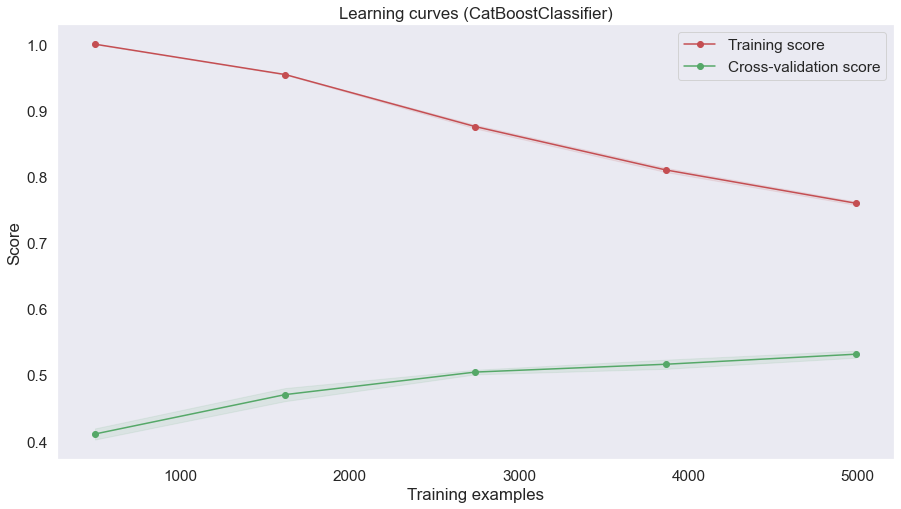

In [2083]:
show_learning_curve_plot(final_model, X, y)

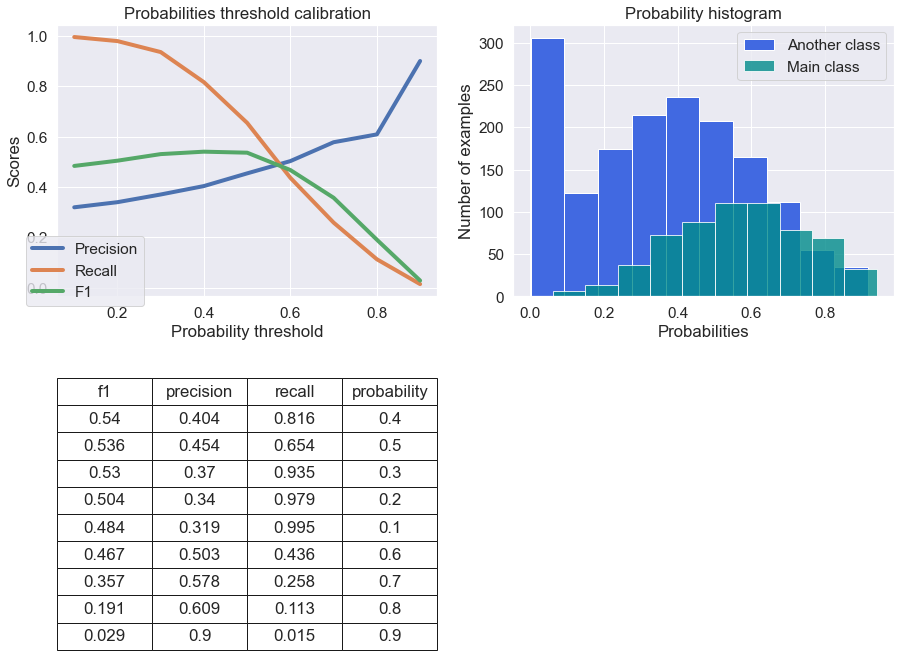

In [2084]:
show_proba_calibration_plots(y_test_pred_probs[:, 1], y_test)

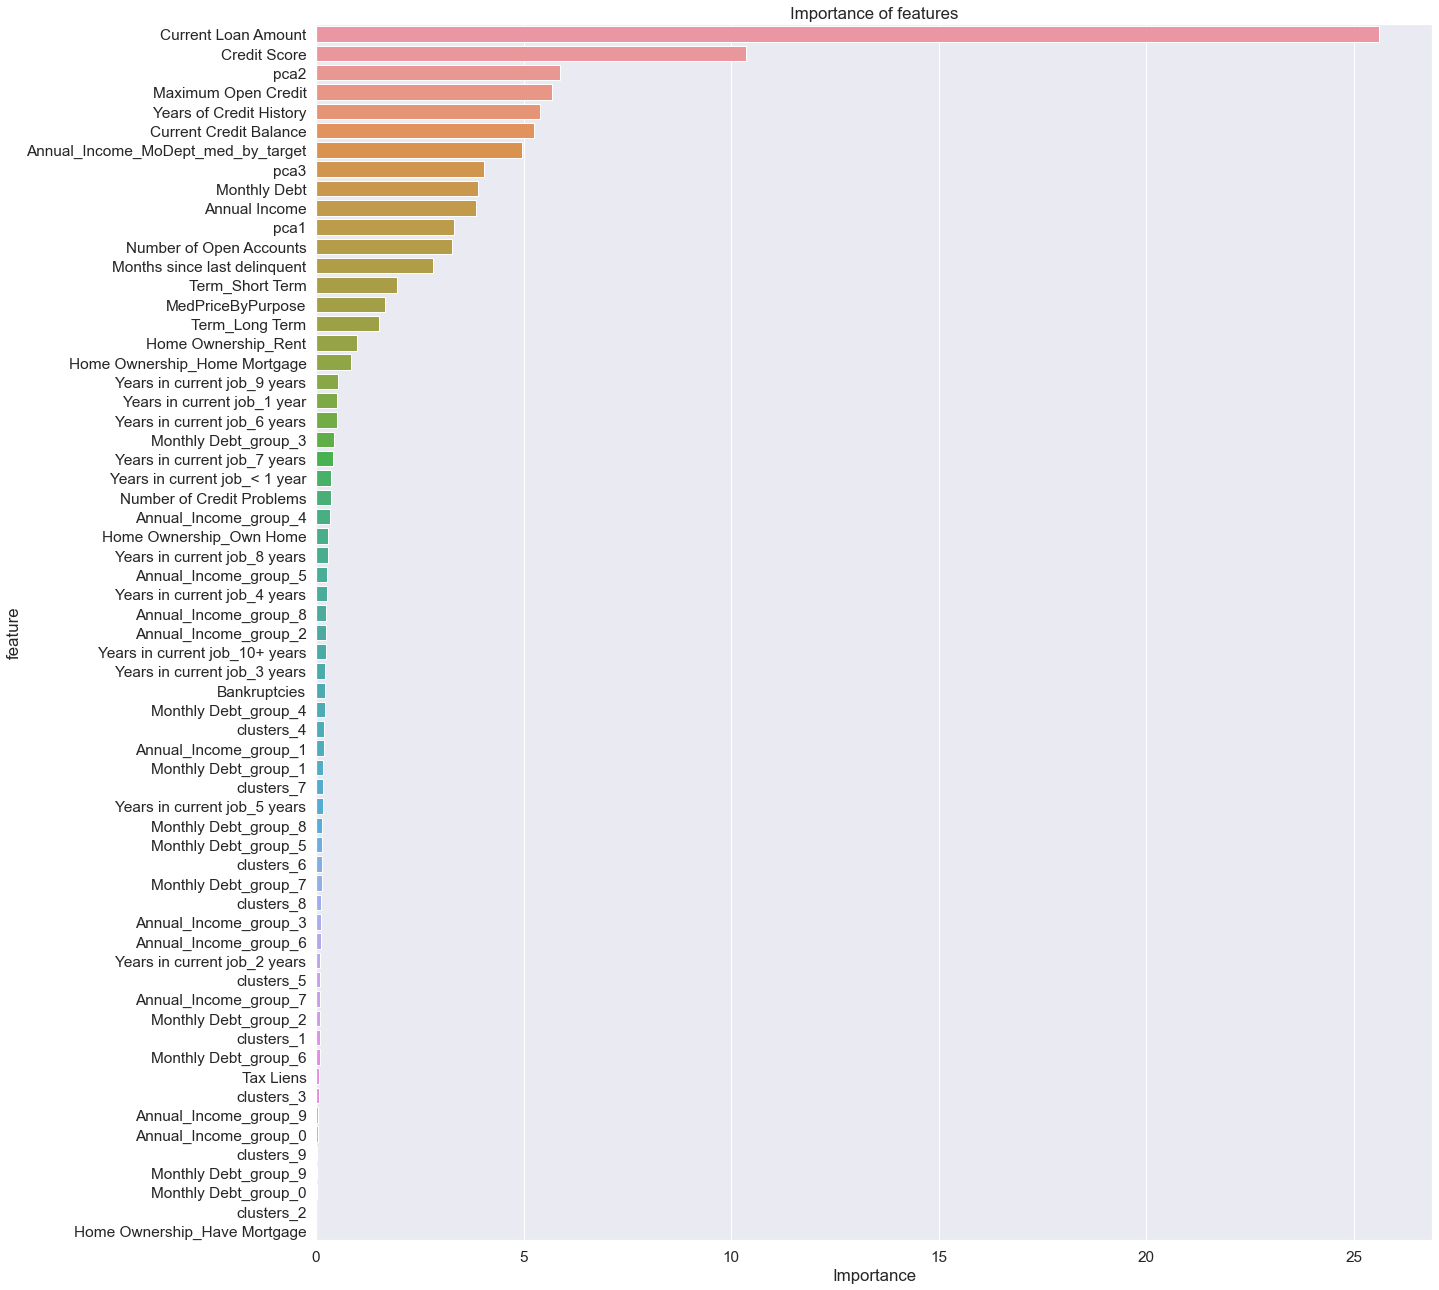

In [2085]:
important_features_top = show_feature_importances(X_train.columns, final_model.feature_importances_, get_top=55)

In [2086]:
important_features_top

['Current Loan Amount',
 'Credit Score',
 'pca2',
 'Maximum Open Credit',
 'Years of Credit History',
 'Current Credit Balance',
 'Annual_Income_MoDept_med_by_target',
 'pca3',
 'Monthly Debt',
 'Annual Income',
 'pca1',
 'Number of Open Accounts',
 'Months since last delinquent',
 'Term_Short Term',
 'MedPriceByPurpose',
 'Term_Long Term',
 'Home Ownership_Rent',
 'Home Ownership_Home Mortgage',
 'Years in current job_9 years',
 'Years in current job_1 year',
 'Years in current job_6 years',
 'Monthly Debt_group_3',
 'Years in current job_7 years',
 'Years in current job_< 1 year',
 'Number of Credit Problems',
 'Annual_Income_group_4',
 'Home Ownership_Own Home',
 'Years in current job_8 years',
 'Annual_Income_group_5',
 'Years in current job_4 years',
 'Annual_Income_group_8',
 'Annual_Income_group_2',
 'Years in current job_10+ years',
 'Years in current job_3 years',
 'Bankruptcies',
 'Monthly Debt_group_4',
 'clusters_4',
 'Annual_Income_group_1',
 'Monthly Debt_group_1',
 'clus

In [2087]:
final_model = catb.CatBoostClassifier(n_estimators=800, max_depth=5,
                                      l2_leaf_reg=3,
                                      silent=True, random_state=21,
                                      class_weights=[2, 5],
                                      eval_metric="AUC",
                                      learning_rate=0.03)
final_model.fit(X_train[important_features_top], y_train)

y_train_pred = final_model.predict(X_train[important_features_top])
y_test_pred = final_model.predict(X_test[important_features_top])
y_test_pred_probs = final_model.predict_proba(X_test[important_features_top])

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.95      0.81      0.88      3760
           1       0.65      0.89      0.75      1478

    accuracy                           0.84      5238
   macro avg       0.80      0.85      0.81      5238
weighted avg       0.87      0.84      0.84      5238

TEST

              precision    recall  f1-score   support

           0       0.84      0.71      0.77      1627
           1       0.46      0.65      0.54       619

    accuracy                           0.69      2246
   macro avg       0.65      0.68      0.65      2246
weighted avg       0.73      0.69      0.70      2246

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1148  479
1                218  401


In [2088]:
feature_importances = pd.DataFrame(zip(X_train.columns, final_model.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
0,Annual Income,25.194150
1,Tax Liens,10.529810
2,Number of Open Accounts,6.158346
3,Years of Credit History,5.842757
4,Maximum Open Credit,5.507324
6,Months since last delinquent,5.128076
5,Number of Credit Problems,5.115997
8,Current Loan Amount,4.561218
9,Current Credit Balance,4.387944
7,Bankruptcies,3.872884


In [2089]:
final_model = catb.CatBoostClassifier(n_estimators=800, max_depth=5,
                                      l2_leaf_reg=3,
                                      silent=True, random_state=21,
                                      class_weights=[2, 5],
                                      eval_metric="AUC",
                                      learning_rate=0.03)
final_model.fit(X[important_features_top], y)

y_train_pred = final_model.predict(X[important_features_top])
y_test_pred = final_model.predict(X_test[important_features_top])
y_test_pred_probs = final_model.predict_proba(X[important_features_top])


In [2090]:
print('TRAIN\n\n' + classification_report(y, y_train_pred))

TRAIN

              precision    recall  f1-score   support

           0       0.94      0.76      0.84      5387
           1       0.59      0.86      0.70      2097

    accuracy                           0.79      7484
   macro avg       0.76      0.81      0.77      7484
weighted avg       0.84      0.79      0.80      7484



In [2092]:
pred_df = pd.DataFrame()
pred_df["Credit Default"] = y_test_pred

In [2093]:
pred_df = pd.read_csv("./ASShubin_predictions_.csv")
pred_df.head(n=2)

FileNotFoundError: [Errno 2] No such file or directory: './ASShubin_predictions_.csv'